In [1]:

import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)


In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#!pip install ipython-autotime

#%load_ext autotime

In [4]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [5]:
#!pip install opencv-python==4.4.0.44
#!pip install opencv-contrib-python==4.4.0.44

In [6]:

class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()
  


In [7]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers




In [6]:
tqdm = partial(tqdm, position=0, leave=True)

In [7]:

files_all=[]
for file in os.listdir("/content/drive/My Drive/Uni_img"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/My Drive/Uni_img/'

centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []

for file in files_all[:61]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[60:120]:
  right_files_path.append(folder_path + file)


In [8]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  #lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  #lab[...,0] = clahe.apply(lab[...,0])
  #left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.3, fy=0.3, interpolation = cv2.INTER_CUBIC)
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  #lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  #lab[...,0] = clahe.apply(lab[...,0])
  #right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.3,fy=0.3, interpolation = cv2.INTER_CUBIC)
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)



100%|██████████| 60/60 [00:18<00:00,  3.25it/s]


In [7]:

images_left_bgr_no_enhance = []
images_right_bgr_no_enhance = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
  images_left_bgr_no_enhance.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
  images_right_bgr_no_enhance.append(right_img)



 45%|████▌     | 5/11 [00:01<00:02,  2.78it/s]


KeyboardInterrupt: ignored

###**BRISK**

In [9]:
Threshl=100;
Octaves=8; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for imgs in tqdm(images_left_bgr):
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 60/60 [00:05<00:00, 10.41it/s]


###**ORB**

In [ ]:
orb = cv2.ORB_create(5000)


keypoints_all_left_orb = []
descriptors_all_left_orb = []
points_all_left_orb=[]

keypoints_all_right_orb = []
descriptors_all_right_orb = []
points_all_right_orb=[]

for imgs in tqdm(images_left_bgr):
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_left_orb.append(kpt)
  descriptors_all_left_orb.append(descrip)
  points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_right_orb.append(kpt)
  descriptors_all_right_orb.append(descrip)
  points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))


100%|██████████| 61/61 [00:11<00:00,  5.19it/s]

100%|██████████| 40/40 [00:07<00:00,  5.21it/s]


###**KAZE**

In [ ]:
kaze = cv2.KAZE_create()


keypoints_all_left_kaze = []
descriptors_all_left_kaze = []
points_all_left_kaze=[]

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []
points_all_right_kaze=[]

for imgs in tqdm(images_left_bgr):
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_left_kaze.append(kpt)
  descriptors_all_left_kaze.append(descrip)
  points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_right_kaze.append(kpt)
  descriptors_all_right_kaze.append(descrip)
  points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 40/40 [04:02<00:00,  6.07s/it]


###**AKAZE**

In [ ]:
akaze = cv2.AKAZE_create()


keypoints_all_left_akaze = []
descriptors_all_left_akaze = []
points_all_left_akaze=[]

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []
points_all_right_akaze=[]

for imgs in tqdm(images_left_bgr):
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_left_akaze.append(kpt)
  descriptors_all_left_akaze.append(descrip)
  points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_right_akaze.append(kpt)
  descriptors_all_right_akaze.append(descrip)
  points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 40/40 [00:43<00:00,  1.08s/it]


###**STAR + BRIEF**

In [77]:
star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

keypoints_all_left_star = []
descriptors_all_left_brief = []
points_all_left_star=[]

keypoints_all_right_star = []
descriptors_all_right_brief = []
points_all_right_star=[]

for imgs in tqdm(images_left_bgr):
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_left_star.append(kpt)
  descriptors_all_left_brief.append(descrip)
  points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_right_star.append(kpt)
  descriptors_all_right_brief.append(descrip)
  points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

 20%|██        | 2/10 [00:00<00:02,  2.85it/s]

KeyboardInterrupt: ignored

###**BRISK + FREAK**

In [22]:
Threshl=60;
Octaves=8; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)

freak = cv2.xfeatures2d.FREAK_create()
keypoints_all_left_freak = []
descriptors_all_left_freak = []
points_all_left_freak=[]

keypoints_all_right_freak = []
descriptors_all_right_freak = []
points_all_right_freak=[]


for imgs in tqdm(images_left_bgr):
  kpt = brisk.detect(imgs)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_left_freak.append(kpt)
  descriptors_all_left_freak.append(descrip)
  points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_right_freak.append(kpt)
  descriptors_all_right_freak.append(descrip)
  points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))




  0%|          | 0/11 [00:00<?, ?it/s]

  9%|▉         | 1/11 [00:00<00:02,  3.34it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.26it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.13it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.13it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.02it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.08it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  3.12it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.98it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.03it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.83it/s]

100%|██████████| 11/11 [00:03<00:00,  2.93it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:00<00:03,  2.76it/s]

 20%|██        | 2/10 [00:00<00:02,  2.96it/s]

 30%|███       | 3/10 [00:01<00:02,  2.81it/s]

 40%|████      | 4/10 [00:01<00:02,  2.62it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.67it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.76it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.84it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.54it/s]

 90

###**MSER + SIFT**

In [ ]:
mser = cv2.MSER_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]

for imgs in tqdm(images_left_bgr_no_enhance):
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_mser.append(kpt)
  descriptors_all_left_mser.append(descrip)
  points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr_no_enhance):
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_mser.append(kpt)
  descriptors_all_right_mser.append(descrip)
  points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 40/40 [02:48<00:00,  4.22s/it]


###**AGAST + SIFT**

In [ ]:
agast = cv2.AgastFeatureDetector_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_agast = []
descriptors_all_left_agast = []
points_all_left_agast=[]

keypoints_all_right_agast = []
descriptors_all_right_agast = []
points_all_right_agast=[]

for imgs in tqdm(images_left_bgr_no_enhance):
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_agast.append(kpt)
  descriptors_all_left_agast.append(descrip)
  points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr_no_enhance):
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_agast.append(kpt)
  descriptors_all_right_agast.append(descrip)
  points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

NameError: ignored

###**FAST + SIFT**

In [ ]:
fast = cv2.FastFeatureDetector_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_fast = []
descriptors_all_left_fast = []
points_all_left_fast=[]

keypoints_all_right_fast = []
descriptors_all_right_fast = []
points_all_right_fast=[]

for imgs in tqdm(images_left_bgr_no_enhance):
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_fast.append(kpt)
  descriptors_all_left_fast.append(descrip)
  points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr_no_enhance):
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_fast.append(kpt)
  descriptors_all_right_fast.append(descrip)
  points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 40/40 [03:19<00:00,  4.99s/it]


###**GFTT + SIFT**

In [ ]:
gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]

for imgs in tqdm(images_left_bgr_no_enhance):
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_gftt.append(kpt)
  descriptors_all_left_gftt.append(descrip)
  points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr_no_enhance):
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_gftt.append(kpt)
  descriptors_all_right_gftt.append(descrip)
  points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 40/40 [00:09<00:00,  4.19it/s]


###**DAISY + SIFT**

In [ ]:
daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for imgs in tqdm(images_left_bgr_no_enhance):
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_left_daisy.append(kpt)
  descriptors_all_left_daisy.append(descrip)
  points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr_no_enhance):
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_right_daisy.append(kpt)
  descriptors_all_right_daisy.append(descrip)
  points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 40/40 [00:52<00:00,  1.31s/it]


###**SURF + SIFT**

In [ ]:
surf = cv2.xfeatures2d.SURF_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []
points_all_left_surfsift=[]

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []
points_all_right_surfsift=[]

for imgs in tqdm(images_left_bgr_no_enhance):
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_surfsift.append(kpt)
  descriptors_all_left_surfsift.append(descrip)
  points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr_no_enhance):
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_surfsift.append(kpt)
  descriptors_all_right_surfsift.append(descrip)
  points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 40/40 [06:35<00:00,  9.90s/it]


###**SIFT**

In [28]:
sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]

for imgs in tqdm(images_left_bgr_no_enhance):
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr_no_enhance):
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 60/60 [01:05<00:00,  1.09s/it]


###**SURF**

In [47]:
surf  = cv2.xfeatures2d.SURF_create()
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]

for imgs in tqdm(images_left_bgr):
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_left_surf.append(kpt)
  descriptors_all_left_surf.append(descrip)
  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_right_surf.append(kpt)
  descriptors_all_right_surf.append(descrip)
  points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 10/10 [00:22<00:00,  2.29s/it]


###**ROOTSIFT**

In [ ]:
class RootSIFT:
  def __init__(self):
    # initialize the SIFT feature extractor
    #self.extractor = cv2.DescriptorExtractor_create("SIFT")
    self.sift = cv2.xfeatures2d.SIFT_create()

  def compute(self, image, kps, eps=1e-7):
    # compute SIFT descriptors
    (kps, descs) = self.sift.compute(image, kps)

    # if there are no keypoints or descriptors, return an empty tuple
    if len(kps) == 0:
      return ([], None)

    # apply the Hellinger kernel by first L1-normalizing, taking the
    # square-root, and then L2-normalizing
    descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
    descs /= (descs.sum(axis=0) + eps)
    descs = np.sqrt(descs)
    #descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)

    # return a tuple of the keypoints and descriptors
    return (kps, descs)

In [ ]:
sift = cv2.xfeatures2d.SIFT_create()
rootsift = RootSIFT()
keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []
points_all_left_rootsift=[]

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []
points_all_right_rootsift=[]

for imgs in tqdm(images_left_bgr):
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_left_rootsift.append(kpt)
  descriptors_all_left_rootsift.append(descrip)
  points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_right_rootsift.append(kpt)
  descriptors_all_right_rootsift.append(descrip)
  points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 40/40 [01:14<00:00,  1.87s/it]


###**SuperPoint**

In [24]:
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

Cloning into 'SuperPointPretrainedNetwork'...
remote: Enumerating objects: 81, done.
remote: Total 81 (delta 0), reused 0 (delta 0), pack-reused 81
Unpacking objects: 100% (81/81), done.


In [11]:
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'

cuda = 'True'

In [12]:
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[0], pt[1], size) for pt in pts]

In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.cuda.empty_cache()

class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
        desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
        return semi, desc


class SuperPointFrontend(object):
    def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,cuda=True):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
        self.cell = 8 # Size of each output cell. Keep this fixed.
        self.border_remove = 4 # Remove points this close to the border.

        # Load the network in inference mode.
        self.net = SuperPointNet()
        if cuda:
          # Train on GPU, deploy on GPU.
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
          # Train on GPU, deploy on CPU.
            self.net.load_state_dict(torch.load(weights_path, map_location=lambda storage, loc: storage))
        self.net.eval()

    def nms_fast(self, in_corners, H, W, dist_thresh):

        grid = np.zeros((H, W)).astype(int) # Track NMS data.
        inds = np.zeros((H, W)).astype(int) # Store indices of points.
        # Sort by confidence and round to nearest int.
        inds1 = np.argsort(-in_corners[2,:])
        corners = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int) # Rounded corners.
        # Check for edge case of 0 or 1 corners.
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
            return out, np.zeros((1)).astype(int)
        # Initialize the grid.
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1,i], rcorners[0,i]] = 1
            inds[rcorners[1,i], rcorners[0,i]] = i
        # Pad the border of the grid, so that we can NMS points near the border.
        pad = dist_thresh
        grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
        # Iterate through points, highest to lowest conf, suppress neighborhood.
        count = 0
        for i, rc in enumerate(rcorners.T):
          # Account for top and left padding.
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
                grid[pt[1], pt[0]] = -1
                count += 1
        # Get all surviving -1's and return sorted array of remaining corners.
        keepy, keepx = np.where(grid==-1)
        keepy, keepx = keepy - pad, keepx - pad
        inds_keep = inds[keepy, keepx]
        out = corners[:, inds_keep]
        values = out[-1, :]
        inds2 = np.argsort(-values)
        out = out[:, inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds

    def run(self, img):
        assert img.ndim == 2 #Image must be grayscale.
        assert img.dtype == np.float32 #Image must be float32.
        H, W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1, H, W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1, 1, H, W)
        if self.cuda:
            inp = inp.cuda()
        # Forward pass of network.
        outs = self.net.forward(inp)
        semi, coarse_desc = outs[0], outs[1]
        # Convert pytorch -> numpy.
        semi = semi.data.cpu().numpy().squeeze()
        
        # --- Process points.
        dense = np.exp(semi) # Softmax.
        dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
        nodust = dense[:-1, :, :]
        # Reshape to get full resolution heatmap.
        Hc = int(H / self.cell)
        Wc = int(W / self.cell)
        nodust = np.transpose(nodust, [1, 2, 0])
        heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
        heatmap = np.transpose(heatmap, [0, 2, 1, 3])
        heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell]) 
        prob_map = heatmap/np.sum(np.sum(heatmap))
        
        return heatmap, coarse_desc


    def key_pt_sampling(self, img, heat_map, coarse_desc, sampled):
        
        H, W = img.shape[0], img.shape[1]

        xs, ys = np.where(heat_map >= self.conf_thresh) # Confidence threshold.
        if len(xs) == 0:
            return np.zeros((3, 0)), None, None
        print("number of pts selected :", len(xs))
        
        
        pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
        pts[0, :] = ys
        pts[1, :] = xs
        pts[2, :] = heat_map[xs, ys]
        pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
        inds = np.argsort(pts[2,:])
        pts = pts[:,inds[::-1]] # Sort by confidence.
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
        toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:, ~toremove]
        pts = pts[:,0:sampled] #we take 2000 keypoints with highest probability from heatmap for our benchmark
        
        # --- Process descriptor.
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D, 0))
        else:
          # Interpolate into descriptor map using 2D point locations.
            samp_pts = torch.from_numpy(pts[:2, :].copy())
            samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
            samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
            samp_pts = samp_pts.transpose(0, 1).contiguous()
            samp_pts = samp_pts.view(1, 1, -1, 2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()            
            desc = nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D, -1)
            desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]

            
        return pts, desc

In [14]:
print('Loading pre-trained network.')
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path=weights_path,nms_dist = 3,conf_thresh = 0.01,nn_thresh=0.5)
print('Successfully loaded pre-trained network.')

Loading pre-trained network.
Successfully loaded pre-trained network.


In [60]:
keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []
points_all_left_superpoint=[]

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []
points_all_right_superpoint=[]

tqdm = partial(tqdm, position=0, leave=True)

for lfpth in tqdm(images_left):
  heatmap1, coarse_desc1 = fe.run(lfpth)
  pts_1, desc_1 = fe.key_pt_sampling(lfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_left_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_left_superpoint.append(desc_1.T)
  points_all_left_superpoint.append(pts_1.T)


for rfpth in tqdm(images_right):
  heatmap1, coarse_desc1 = fe.run(rfpth)
  pts_1, desc_1 = fe.key_pt_sampling(rfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_right_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_right_superpoint.append(desc_1.T)
  points_all_right_superpoint.append(pts_1.T)

  0%|          | 0/11 [00:00<?, ?it/s]

number of pts selected : 74932


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3829: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
  9%|▉         | 1/11 [00:00<00:06,  1.56it/s]

number of pts selected : 80846


 18%|█▊        | 2/11 [00:01<00:05,  1.56it/s]

number of pts selected : 91271


 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

number of pts selected : 94394


 36%|███▋      | 4/11 [00:02<00:04,  1.50it/s]

number of pts selected : 87326


 45%|████▌     | 5/11 [00:03<00:03,  1.50it/s]

number of pts selected : 82758


 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

number of pts selected : 86510


 64%|██████▎   | 7/11 [00:04<00:02,  1.51it/s]

number of pts selected : 101217


 73%|███████▎  | 8/11 [00:05<00:02,  1.48it/s]

number of pts selected : 85932


 82%|████████▏ | 9/11 [00:06<00:01,  1.49it/s]

number of pts selected : 111386


 91%|█████████ | 10/11 [00:06<00:00,  1.43it/s]

number of pts selected : 104463


  0%|          | 0/10 [00:00<?, ?it/s]

number of pts selected : 74932


 10%|█         | 1/10 [00:00<00:05,  1.63it/s]

number of pts selected : 82170


 20%|██        | 2/10 [00:01<00:04,  1.60it/s]

number of pts selected : 94567


 30%|███       | 3/10 [00:01<00:04,  1.55it/s]

number of pts selected : 97331


 40%|████      | 4/10 [00:02<00:03,  1.51it/s]

number of pts selected : 112874


 50%|█████     | 5/10 [00:03<00:03,  1.44it/s]

number of pts selected : 104766


 60%|██████    | 6/10 [00:04<00:02,  1.43it/s]

number of pts selected : 100976


 70%|███████   | 7/10 [00:04<00:02,  1.43it/s]

number of pts selected : 107728


 80%|████████  | 8/10 [00:05<00:01,  1.40it/s]

number of pts selected : 105085


 90%|█████████ | 9/10 [00:06<00:00,  1.38it/s]

number of pts selected : 100311


100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


###**R2D2**

In [ ]:
!git clone https://github.com/naver/r2d2.git


In [ ]:
for files in left_files_path + right_files_path[1:]:
  !python r2d2/extract.py --model r2d2/models/r2d2_WASF_N8_big.pt --images files --top-k 10000 --min-size 400 --max-size 3000  


In [ ]:
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[0], pt[1], size) for pt in pts]

In [ ]:

keypoints_all_left_r2d2 = []
descriptors_all_left_r2d2 = []
points_all_left_r2d2=[]

keypoints_all_right_r2d2 = []
descriptors_all_right_r2d2 = []
points_all_right_r2d2=[]

for lfpth in tqdm(left_files_path):
  mat = np.load(lfpth + '.r2d2')
  kpt = mat.get('keypoints')
  descrip = mat.get('descriptors') 
  keypoints_all_left_r2d2.append(to_kpts(kpt))
  descriptors_all_left_r2d2.append(descrip)
  points_all_left.append(np.asarray([[p[0], p[1]] for p in kpt]))

for rfpth in tqdm(right_files_path):
  mat = np.load(rfpth + '.r2d2')
  kpt = mat.get('keypoints')
  descrip = mat.get('descriptors') 
  keypoints_all_right_r2d2.append(to_kpts(kpt))
  descriptors_all_right_r2d2.append(descrip)
  points_all_right_r2d2.append(np.asarray([[p[0], p[1]] for p in kpt]))


###**D2-Net**

In [ ]:
!git clone https://github.com/mihaidusmanu/d2-net.git

In [ ]:
!mkdir models
!wget https://dsmn.ml/files/d2-net/d2_ots.pth -O models/d2_ots.pth
!wget https://dsmn.ml/files/d2-net/d2_tf.pth -O models/d2_tf.pth
!wget https://dsmn.ml/files/d2-net/d2_tf_no_phototourism.pth -O models/d2_tf_no_phototourism.pth

In [ ]:
!python d2-net/extract_features.py --image_list_file drive/MyDrive/Uni-Img/uni_images_train.txt --output_type 'mat' --multiscale
#!python d2-net/extract_features.py --image_list_file drive/MyDrive/tech_park/test_images.txt --output_type 'mat'

In [ ]:

keypoints_all_left_d2net = []
descriptors_all_left_d2net = []
points_all_left_d2net=[]

keypoints_all_right_d2net = []
descriptors_all_right_d2net = []
points_all_right_d2net=[]

for lfpth in tqdm(left_files_path):
  mat = scipy.io.loadmat(lfpth + '.d2-net')
  kpt = mat.get('keypoints')
  descrip = mat.get('descriptors') 
  keypoints_all_left_d2net.append(to_kpts(kpt))
  descriptors_all_left_d2net.append(descrip)
  points_all_left_d2net.append(np.asarray([[p[0], p[1]] for p in kpt]))

for rfpth in tqdm(right_files_path):
  mat = scipy.io.loadmat(rfpth + '.d2-net')
  kpt = mat.get('keypoints')
  descrip = mat.get('descriptors') 
  keypoints_all_right_d2net.append(to_kpts(kpt))
  descriptors_all_right_d2net.append(descrip)
  points_all_right_d2net.append(np.asarray([[p[0], p[1]] for p in kpt]))


###**RF-Net**

In [ ]:
!git clone https://github.com/Xylon-Sean/rfnet.git

In [ ]:
%cd rfnet
from utils.common_utils import gct
from utils.eval_utils import nearest_neighbor_distance_ratio_match
from model.rf_des import HardNetNeiMask
from model.rf_det_so import RFDetSO
from model.rf_net_so import RFNetSO
from config import cfg
import cv2
import torch
import random
import argparse
import numpy as np

In [ ]:
import shutil
shutil.copytree('../drive/MyDrive/rfnet_model/runs', '../rfnet/runs')

In [ ]:
print(f"{gct()} : model init")
det = RFDetSO(
    cfg.TRAIN.score_com_strength,
    cfg.TRAIN.scale_com_strength,
    cfg.TRAIN.NMS_THRESH,
    cfg.TRAIN.NMS_KSIZE,
    cfg.TRAIN.TOPK,
    cfg.MODEL.GAUSSIAN_KSIZE,
    cfg.MODEL.GAUSSIAN_SIGMA,
    cfg.MODEL.KSIZE,
    cfg.MODEL.padding,
    cfg.MODEL.dilation,
    cfg.MODEL.scale_list,
)
des = HardNetNeiMask(cfg.HARDNET.MARGIN, cfg.MODEL.COO_THRSH)
model = RFNetSO(
    det, des, cfg.LOSS.SCORE, cfg.LOSS.PAIR, cfg.PATCH.SIZE, cfg.TRAIN.TOPK
)

print(f"{gct()} : to device")
device = torch.device("cpu")
model = model.to(device)
resume = 'runs/10_24_09_25/model/e121_NN_0.480_NNT_0.655_NNDR_0.813_MeanMS_0.649.pth.tar'
print(f"{gct()} : in {resume}")
checkpoint = torch.load(resume)
model.load_state_dict(checkpoint["state_dict"])

In [ ]:
images_left_rfnet = []
descriptors_all_left_rfnet = []
points_all_left_rfnet=[]

images_rightt_rfnet = []
descriptors_all_rightt_rfnet = []
points_all_rightt_rfnet=[]

for lfpth in tqdm(left_files_path):
  kp1, des1, img1 = model.detectAndCompute(lfpth, device, (240, 320))
  descriptors_all_left_rfnet.append(des1)
  points_all_left_rfnet.append(kp1)
  images_left_rfnet.append(reverse_img(img1))


for rfpth in tqdm(left_files_path):
  kp1, des1, img1 = model.detectAndCompute(rfpth, device, (240, 320))
  descriptors_all_right_rfnet.append(des1)
  points_all_right_rfnet.append(kp1)
  images_right_rfnet.append(reverse_img(img1))

In [ ]:
num_kps_surf = []
num_kps_rootsift = []
num_kps_superpoint = []

for j in tqdm(keypoints_all_left_rootsift + keypoints_all_right_rootsift):
  num_kps_rootsift.append(len(j))

for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf):
  num_kps_surf.append(len(j))

for j in tqdm(keypoints_all_left_superpoint + keypoints_all_right_superpoint):
  num_kps_superpoint.append(len(j))

100%|██████████| 101/101 [00:00<00:00, 299169.99it/s]


In [ ]:
num_kps_sift = []
num_kps_brisk = []
num_kps_agast = []
num_kps_kaze = []
num_kps_akaze = []
num_kps_orb = []
num_kps_mser = []
num_kps_daisy = []
num_kps_surfsift = []
num_kps_fast = []
num_kps_freak = []
num_kps_gftt = []
num_kps_star = []

#for j in tqdm(keypoints_all_left_sift + keypoints_all_right_sift):
#  num_kps_sift.append(len(j))

for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk):
  num_kps_brisk.append(len(j))

#for j in tqdm(keypoints_all_left_agast + keypoints_all_right_agast):
#  num_kps_agast.append(len(j))

#for j in tqdm(keypoints_all_left_kaze + keypoints_all_right_kaze):
#  num_kps_kaze.append(len(j))

for j in tqdm(keypoints_all_left_akaze + keypoints_all_right_akaze):
  num_kps_akaze.append(len(j))

for j in tqdm(keypoints_all_left_orb + keypoints_all_right_orb):
  num_kps_orb.append(len(j))

#for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser):
#  num_kps_mser.append(len(j))

#for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy):
#  num_kps_daisy.append(len(j))

#for j in tqdm(keypoints_all_left_surfsift + keypoints_all_right_surfsift):
#  num_kps_surfsift.append(len(j))

#for j in tqdm(keypoints_all_left_fast + keypoints_all_right_fast):
#  num_kps_fast.append(len(j))

for j in tqdm(keypoints_all_left_freak + keypoints_all_right_freak):
  num_kps_freak.append(len(j))

#for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt):
#  num_kps_gftt.append(len(j))

for j in tqdm(keypoints_all_left_star + keypoints_all_right_star):
  num_kps_star.append(len(j))

100%|██████████| 101/101 [00:00<00:00, 404608.12it/s]


In [ ]:
print(len(num_kps_sift + num_kps_agast))

202


In [ ]:
d = {'Dataset': ['University Campus']*(13*101), 'Number of Keypoints': num_kps_agast + num_kps_akaze + num_kps_brisk + num_kps_daisy + num_kps_fast + num_kps_freak + num_kps_gftt + num_kps_kaze + num_kps_mser + num_kps_orb + num_kps_sift + num_kps_star + num_kps_surfsift, 'Detector/Descriptor':['AGAST+SIFT']*101 + ['AKAZE']*101 + ['BRISK']*101 + ['DAISY+SIFT']*101 + ['FAST+SIFT']*101 + ['BRISK+FREAK']*101 + ['GFTT+SIFT']*101 + ['KAZE']*101 + ['MSER+SIFT']*101 + ['ORB']*101 + ['SIFT']*101 + ['STAR+BRIEF']*101 + ['SURF+SIFT']*101 }
df = pd.DataFrame(data=d)

In [ ]:
d = {'Dataset': ['University Campus']*(3*101), 'Number of Keypoints': num_kps_rootsift + num_kps_superpoint + num_kps_surf, 'Detector/Descriptor':['ROOTSIFT']*101 + ['SuperPoint']*101 + ['SURF']*101  }
df = pd.DataFrame(data=d)

In [ ]:
df_13 = pd.read_csv('drive/MyDrive/Num_Key_13.csv')
frames = [df_13, df]
df_16 = pd.concat(frames)

In [ ]:
df_16.to_csv('drive/MyDrive/Num_Key_16.csv')

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

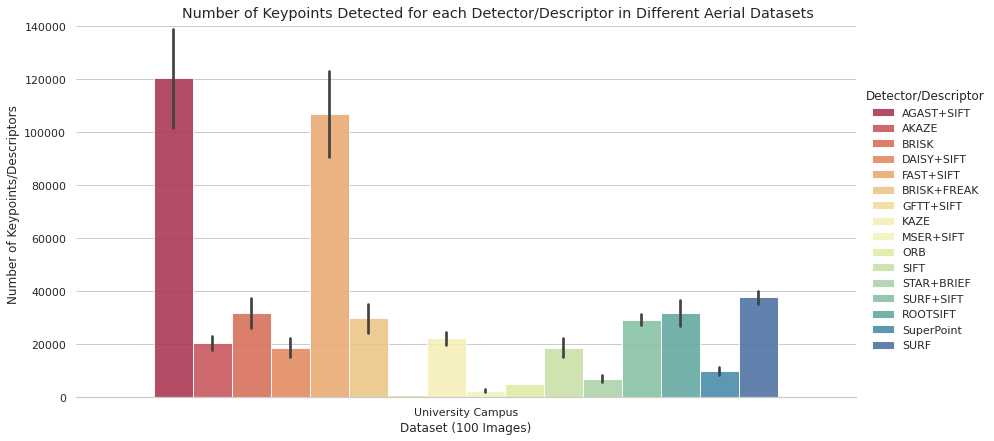

In [ ]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_16, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset (100 Images)", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig('drive/MyDrive/Num_Kypoints_16.png')

In [10]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh)
    inliers = inliers.flatten()
    return H, inliers

In [11]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [12]:

def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.8,thresh=4,use_lowe=True,disp=False,no_ransac=False,binary=False):
  lff1 = descripts[0]
  lff = descripts[1]

  if use_lowe==False:
    #FLANN_INDEX_KDTREE = 2
    #index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    #search_params = dict(checks=50)
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    #matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    matches_4 = bf.match(lff1, lff)
    matches_lf1_lf = []


    print("\nNumber of matches",len(matches_4))
    '''
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      #if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_4.append(m[0])
    '''
    print("Number of matches After Lowe's Ratio",len(matches_4))
  else:
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])
    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    #matches_lf1_lf = bf.knnMatch(lff1, lff,k=2)


    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])
  
    print("Number of matches After Lowe's Ratio",len(matches_4))


  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  if no_ransac==True:
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
  else:
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  

  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  '''
  if len(inlier_matchset)<50:
    matches_4 = []
    ratio = 0.67
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
    '''
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [ ]:

def get_Hmatrix_rfnet(imgs,pts,descripts,disp=True):

  des1 = descripts[0]
  des2 = descripts[1]

  kp1 = pts[0]
  kp2 = pts[1]


  predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
  idx = predict_label.nonzero().view(-1)
  mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
  mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2

  #img1, img2 = reverse_img(img1), reverse_img(img2)
  keypoints1 = list(map(to_cv2_kp, mkp1))
  keypoints2 = list(map(to_cv2_kp, mkp2))
  DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))

  imm1_pts=np.empty((len(DMatch),2))
  imm2_pts=np.empty((len(DMatch),2))
  for i in range(0,len(DMatch)):
    m = DMatch[i]
    (a_x, a_y) = keypoints1[m.queryIdx].pt
    (b_x, b_y) = keypoints2[m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography_fast(imm1_pts,imm2_pts) 


  if disp==True:
    dispimg1 = cv2.drawMatches(imgs[0], keypoints1, imgs[1], keypoints2, DMatch, None)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return H/H[2,2]


In [13]:
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
print(left_files_path)

['/content/drive/My Drive/Uni_img/IX-11-01917_0004_0031.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0030.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0029.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0028.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0027.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0026.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0025.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0024.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0023.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0022.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0021.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0020.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0019.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0018.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0017.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0016.JPG', '/content/drive/My Driv

In [ ]:
print(right_files_path)

['/content/drive/My Drive/Uni_img/IX-11-01917_0004_0031.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0032.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0033.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0034.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0035.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0036.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0037.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0038.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0039.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0040.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0041.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0042.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0043.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0044.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0045.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0046.JPG', '/content/drive/My Driv

In [14]:
H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.85,4,use_lowe=True,binary=True)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.85,4,use_lowe=True,binary=True)
  H_right_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

  3%|▎         | 2/61 [00:00<00:06,  8.87it/s]


Number of matches 2612
Number of matches After Lowe's Ratio 260
Number of Robust matches 94



Number of matches 2610
Number of matches After Lowe's Ratio 198
Number of Robust matches 65




  5%|▍         | 3/61 [00:00<00:06,  8.47it/s]


Number of matches 2307
Number of matches After Lowe's Ratio 123
Number of Robust matches 7



Number of matches 1979
Number of matches After Lowe's Ratio 326
Number of Robust matches 173




 10%|▉         | 6/61 [00:00<00:05,  9.32it/s]


Number of matches 2347
Number of matches After Lowe's Ratio 391
Number of Robust matches 235



Number of matches 2496
Number of matches After Lowe's Ratio 311
Number of Robust matches 153




 13%|█▎        | 8/61 [00:00<00:06,  8.73it/s]


Number of matches 3042
Number of matches After Lowe's Ratio 504
Number of Robust matches 313



Number of matches 3779
Number of matches After Lowe's Ratio 324
Number of Robust matches 168




 16%|█▋        | 10/61 [00:01<00:07,  7.24it/s]


Number of matches 4147
Number of matches After Lowe's Ratio 645
Number of Robust matches 434



Number of matches 6406
Number of matches After Lowe's Ratio 610
Number of Robust matches 340




 18%|█▊        | 11/61 [00:01<00:09,  5.25it/s]


Number of matches 6878
Number of matches After Lowe's Ratio 984
Number of Robust matches 667




 20%|█▉        | 12/61 [00:01<00:10,  4.78it/s]


Number of matches 8191
Number of matches After Lowe's Ratio 1161
Number of Robust matches 880




 21%|██▏       | 13/61 [00:02<00:10,  4.47it/s]


Number of matches 7422
Number of matches After Lowe's Ratio 1094
Number of Robust matches 786




 23%|██▎       | 14/61 [00:02<00:10,  4.30it/s]


Number of matches 7763
Number of matches After Lowe's Ratio 1392
Number of Robust matches 1023




 26%|██▌       | 16/61 [00:02<00:10,  4.48it/s]


Number of matches 6551
Number of matches After Lowe's Ratio 1145
Number of Robust matches 847



Number of matches 4734
Number of matches After Lowe's Ratio 958
Number of Robust matches 729




 30%|██▉       | 18/61 [00:02<00:07,  5.68it/s]


Number of matches 3471
Number of matches After Lowe's Ratio 598
Number of Robust matches 441



Number of matches 3719
Number of matches After Lowe's Ratio 609
Number of Robust matches 414




 33%|███▎      | 20/61 [00:03<00:05,  7.04it/s]


Number of matches 2907
Number of matches After Lowe's Ratio 597
Number of Robust matches 469



Number of matches 2530
Number of matches After Lowe's Ratio 462
Number of Robust matches 328




 36%|███▌      | 22/61 [00:03<00:05,  7.56it/s]


Number of matches 3336
Number of matches After Lowe's Ratio 431
Number of Robust matches 261



Number of matches 3765
Number of matches After Lowe's Ratio 634
Number of Robust matches 435




 39%|███▉      | 24/61 [00:03<00:05,  7.16it/s]


Number of matches 4173
Number of matches After Lowe's Ratio 743
Number of Robust matches 561



Number of matches 4063
Number of matches After Lowe's Ratio 609
Number of Robust matches 428




 41%|████      | 25/61 [00:03<00:05,  6.43it/s]


Number of matches 7284
Number of matches After Lowe's Ratio 674
Number of Robust matches 385




 44%|████▍     | 27/61 [00:04<00:05,  5.70it/s]


Number of matches 6093
Number of matches After Lowe's Ratio 759
Number of Robust matches 375



Number of matches 3592
Number of matches After Lowe's Ratio 580
Number of Robust matches 339




 49%|████▉     | 30/61 [00:04<00:04,  7.64it/s]


Number of matches 2852
Number of matches After Lowe's Ratio 347
Number of Robust matches 159



Number of matches 1215
Number of matches After Lowe's Ratio 135
Number of Robust matches 77



Number of matches 1822
Number of matches After Lowe's Ratio 213
Number of Robust matches 103



Number of matches 1030
Number of matches After Lowe's Ratio 84
Number of Robust matches 51




 56%|█████▌    | 34/61 [00:04<00:02,  9.70it/s]


Number of matches 1875
Number of matches After Lowe's Ratio 134
Number of Robust matches 22



Number of matches 1993
Number of matches After Lowe's Ratio 353
Number of Robust matches 175



Number of matches 1538
Number of matches After Lowe's Ratio 316
Number of Robust matches 190




 62%|██████▏   | 38/61 [00:05<00:01, 12.11it/s]


Number of matches 1801
Number of matches After Lowe's Ratio 250
Number of Robust matches 131



Number of matches 1312
Number of matches After Lowe's Ratio 246
Number of Robust matches 145



Number of matches 1687
Number of matches After Lowe's Ratio 215
Number of Robust matches 94



Number of matches 1400
Number of matches After Lowe's Ratio 194
Number of Robust matches 105




 66%|██████▌   | 40/61 [00:05<00:01, 11.25it/s]


Number of matches 2639
Number of matches After Lowe's Ratio 268
Number of Robust matches 131



Number of matches 3543
Number of matches After Lowe's Ratio 584
Number of Robust matches 372




 69%|██████▉   | 42/61 [00:05<00:02,  9.33it/s]


Number of matches 4551
Number of matches After Lowe's Ratio 890
Number of Robust matches 566



Number of matches 4950
Number of matches After Lowe's Ratio 970
Number of Robust matches 671




 72%|███████▏  | 44/61 [00:05<00:02,  8.12it/s]


Number of matches 4459
Number of matches After Lowe's Ratio 969
Number of Robust matches 705



Number of matches 5031
Number of matches After Lowe's Ratio 905
Number of Robust matches 594




 75%|███████▌  | 46/61 [00:06<00:02,  6.84it/s]


Number of matches 4993
Number of matches After Lowe's Ratio 896
Number of Robust matches 571



Number of matches 4581
Number of matches After Lowe's Ratio 808
Number of Robust matches 473




 77%|███████▋  | 47/61 [00:06<00:02,  6.47it/s]


Number of matches 5890
Number of matches After Lowe's Ratio 839
Number of Robust matches 418




 79%|███████▊  | 48/61 [00:06<00:02,  5.02it/s]


Number of matches 6858
Number of matches After Lowe's Ratio 814
Number of Robust matches 447




 80%|████████  | 49/61 [00:07<00:02,  4.81it/s]


Number of matches 6844
Number of matches After Lowe's Ratio 1425
Number of Robust matches 1031




 84%|████████▎ | 51/61 [00:07<00:02,  4.85it/s]


Number of matches 6336
Number of matches After Lowe's Ratio 1316
Number of Robust matches 957



Number of matches 5017
Number of matches After Lowe's Ratio 781
Number of Robust matches 505




 87%|████████▋ | 53/61 [00:07<00:01,  5.57it/s]


Number of matches 4314
Number of matches After Lowe's Ratio 626
Number of Robust matches 372



Number of matches 4326
Number of matches After Lowe's Ratio 821
Number of Robust matches 547




 90%|█████████ | 55/61 [00:08<00:01,  5.67it/s]


Number of matches 6063
Number of matches After Lowe's Ratio 804
Number of Robust matches 420



Number of matches 4236
Number of matches After Lowe's Ratio 729
Number of Robust matches 497




 93%|█████████▎| 57/61 [00:08<00:00,  6.26it/s]


Number of matches 3981
Number of matches After Lowe's Ratio 584
Number of Robust matches 312



Number of matches 4577
Number of matches After Lowe's Ratio 805
Number of Robust matches 452




 97%|█████████▋| 59/61 [00:08<00:00,  6.57it/s]


Number of matches 3624
Number of matches After Lowe's Ratio 460
Number of Robust matches 175



Number of matches 4259
Number of matches After Lowe's Ratio 618
Number of Robust matches 263




  2%|▏         | 1/60 [00:00<00:06,  9.34it/s]


Number of matches 2799
Number of matches After Lowe's Ratio 234
Number of Robust matches 64



Number of matches 2822
Number of matches After Lowe's Ratio 321
Number of Robust matches 178




  5%|▌         | 3/60 [00:00<00:07,  7.63it/s]


Number of matches 3967
Number of matches After Lowe's Ratio 640
Number of Robust matches 477



Number of matches 5911
Number of matches After Lowe's Ratio 862
Number of Robust matches 629




  8%|▊         | 5/60 [00:00<00:08,  6.17it/s]


Number of matches 6424
Number of matches After Lowe's Ratio 718
Number of Robust matches 484



Number of matches 3668
Number of matches After Lowe's Ratio 286
Number of Robust matches 139




 12%|█▏        | 7/60 [00:01<00:07,  6.74it/s]


Number of matches 4178
Number of matches After Lowe's Ratio 616
Number of Robust matches 490



Number of matches 3322
Number of matches After Lowe's Ratio 347
Number of Robust matches 210




 15%|█▌        | 9/60 [00:01<00:06,  7.39it/s]


Number of matches 3378
Number of matches After Lowe's Ratio 715
Number of Robust matches 576



Number of matches 3291
Number of matches After Lowe's Ratio 703
Number of Robust matches 565




 20%|██        | 12/60 [00:01<00:05,  8.57it/s]


Number of matches 2533
Number of matches After Lowe's Ratio 481
Number of Robust matches 394



Number of matches 2349
Number of matches After Lowe's Ratio 408
Number of Robust matches 344



Number of matches 1902
Number of matches After Lowe's Ratio 262
Number of Robust matches 183




 23%|██▎       | 14/60 [00:01<00:05,  8.67it/s]


Number of matches 2340
Number of matches After Lowe's Ratio 397
Number of Robust matches 310



Number of matches 3765
Number of matches After Lowe's Ratio 560
Number of Robust matches 417




 27%|██▋       | 16/60 [00:02<00:05,  8.07it/s]


Number of matches 3460
Number of matches After Lowe's Ratio 628
Number of Robust matches 386



Number of matches 3790
Number of matches After Lowe's Ratio 702
Number of Robust matches 497




 30%|███       | 18/60 [00:02<00:05,  8.25it/s]


Number of matches 3494
Number of matches After Lowe's Ratio 710
Number of Robust matches 453



Number of matches 2548
Number of matches After Lowe's Ratio 442
Number of Robust matches 303




 33%|███▎      | 20/60 [00:02<00:04,  8.86it/s]


Number of matches 2697
Number of matches After Lowe's Ratio 496
Number of Robust matches 292



Number of matches 2279
Number of matches After Lowe's Ratio 440
Number of Robust matches 245



Number of matches 2130
Number of matches After Lowe's Ratio 373
Number of Robust matches 229




 42%|████▏     | 25/60 [00:02<00:03, 11.19it/s]


Number of matches 2397
Number of matches After Lowe's Ratio 331
Number of Robust matches 210



Number of matches 655
Number of matches After Lowe's Ratio 56
Number of Robust matches 25



Number of matches 940
Number of matches After Lowe's Ratio 75
Number of Robust matches 37



Number of matches 1354
Number of matches After Lowe's Ratio 60
Number of Robust matches 6




 45%|████▌     | 27/60 [00:03<00:02, 11.05it/s]


Number of matches 2372
Number of matches After Lowe's Ratio 190
Number of Robust matches 61



Number of matches 2286
Number of matches After Lowe's Ratio 350
Number of Robust matches 191




 48%|████▊     | 29/60 [00:03<00:03, 10.30it/s]


Number of matches 3165
Number of matches After Lowe's Ratio 385
Number of Robust matches 202



Number of matches 2800
Number of matches After Lowe's Ratio 421
Number of Robust matches 216




 52%|█████▏    | 31/60 [00:03<00:02, 10.03it/s]


Number of matches 2676
Number of matches After Lowe's Ratio 347
Number of Robust matches 161



Number of matches 2787
Number of matches After Lowe's Ratio 272
Number of Robust matches 103




 55%|█████▌    | 33/60 [00:03<00:02,  9.51it/s]


Number of matches 3289
Number of matches After Lowe's Ratio 536
Number of Robust matches 197



Number of matches 2713
Number of matches After Lowe's Ratio 320
Number of Robust matches 171




 58%|█████▊    | 35/60 [00:03<00:02,  9.42it/s]


Number of matches 2297
Number of matches After Lowe's Ratio 444
Number of Robust matches 285



Number of matches 3243
Number of matches After Lowe's Ratio 421
Number of Robust matches 208




 62%|██████▏   | 37/60 [00:04<00:02,  9.96it/s]


Number of matches 1990
Number of matches After Lowe's Ratio 268
Number of Robust matches 137



Number of matches 1878
Number of matches After Lowe's Ratio 288
Number of Robust matches 235



Number of matches 1887
Number of matches After Lowe's Ratio 382
Number of Robust matches 325




 65%|██████▌   | 39/60 [00:04<00:02, 10.34it/s]


Number of matches 2089
Number of matches After Lowe's Ratio 387
Number of Robust matches 292



Number of matches 2144
Number of matches After Lowe's Ratio 532
Number of Robust matches 455



Number of matches 2614
Number of matches After Lowe's Ratio

 68%|██████▊   | 41/60 [00:04<00:01, 10.22it/s]

 341
Number of Robust matches 246



Number of matches 2821
Number of matches After Lowe's Ratio 630
Number of Robust matches 525




 75%|███████▌  | 45/60 [00:04<00:01, 10.43it/s]


Number of matches 2573
Number of matches After Lowe's Ratio 241
Number of Robust matches 147



Number of matches 1744
Number of matches After Lowe's Ratio 321
Number of Robust matches 236



Number of matches 2161
Number of matches After Lowe's Ratio 314
Number of Robust matches 222




 78%|███████▊  | 47/60 [00:05<00:01,  9.94it/s]


Number of matches 2492
Number of matches After Lowe's Ratio 567
Number of Robust matches 478



Number of matches 3885
Number of matches After Lowe's Ratio 536
Number of Robust matches 400




 82%|████████▏ | 49/60 [00:05<00:01,  8.83it/s]


Number of matches 4301
Number of matches After Lowe's Ratio 929
Number of Robust matches 706



Number of matches 4161
Number of matches After Lowe's Ratio 876
Number of Robust matches 667




 85%|████████▌ | 51/60 [00:05<00:01,  7.27it/s]


Number of matches 4749
Number of matches After Lowe's Ratio 771
Number of Robust matches 514



Number of matches 5025
Number of matches After Lowe's Ratio 712
Number of Robust matches 386




 88%|████████▊ | 53/60 [00:06<00:01,  6.27it/s]


Number of matches 3988
Number of matches After Lowe's Ratio 490
Number of Robust matches 241



Number of matches 5229
Number of matches After Lowe's Ratio 263
Number of Robust matches 60




 92%|█████████▏| 55/60 [00:06<00:00,  5.34it/s]


Number of matches 5550
Number of matches After Lowe's Ratio 526
Number of Robust matches 263



Number of matches 4567
Number of matches After Lowe's Ratio 661
Number of Robust matches 343




 95%|█████████▌| 57/60 [00:06<00:00,  6.54it/s]


Number of matches 3196
Number of matches After Lowe's Ratio 418
Number of Robust matches 219



Number of matches 2642
Number of matches After Lowe's Ratio 629
Number of Robust matches 503




 98%|█████████▊| 59/60 [00:06<00:00,  8.44it/s]


Number of matches 2615
Number of matches After Lowe's Ratio 563
Number of Robust matches 477



Number of matches 2564
Number of matches After Lowe's Ratio 514
Number of Robust matches 412




In [29]:
H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.5)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.5)
  H_right_sift.append(H_a)
  #num_matches.append(matches)
  #num_good_matches.append(gd_matches)

  2%|▏         | 1/61 [00:01<01:07,  1.12s/it]


Number of matches 15850
Number of matches After Lowe's Ratio 561
Number of Robust matches 477




  3%|▎         | 2/61 [00:02<01:05,  1.11s/it]


Number of matches 20463
Number of matches After Lowe's Ratio 396
Number of Robust matches 329




  5%|▍         | 3/61 [00:03<01:09,  1.20s/it]


Number of matches 16891
Number of matches After Lowe's Ratio 74
Number of Robust matches 52




  7%|▋         | 4/61 [00:04<01:09,  1.23s/it]


Number of matches 16828
Number of matches After Lowe's Ratio 1072
Number of Robust matches 706




  8%|▊         | 5/61 [00:06<01:07,  1.20s/it]


Number of matches 17667
Number of matches After Lowe's Ratio 1367
Number of Robust matches 908




 10%|▉         | 6/61 [00:07<01:07,  1.22s/it]


Number of matches 17727
Number of matches After Lowe's Ratio 1247
Number of Robust matches 856




 11%|█▏        | 7/61 [00:08<01:06,  1.23s/it]


Number of matches 19250
Number of matches After Lowe's Ratio 1460
Number of Robust matches 919




 13%|█▎        | 8/61 [00:09<01:05,  1.23s/it]


Number of matches 12557
Number of matches After Lowe's Ratio 464
Number of Robust matches 340




 15%|█▍        | 9/61 [00:10<01:00,  1.15s/it]


Number of matches 19090
Number of matches After Lowe's Ratio 946
Number of Robust matches 633




 16%|█▋        | 10/61 [00:11<00:59,  1.17s/it]


Number of matches 12039
Number of matches After Lowe's Ratio 326
Number of Robust matches 252




 18%|█▊        | 11/61 [00:12<00:53,  1.07s/it]


Number of matches 17448
Number of matches After Lowe's Ratio 978
Number of Robust matches 768




 20%|█▉        | 12/61 [00:13<00:53,  1.09s/it]


Number of matches 15221
Number of matches After Lowe's Ratio 1127
Number of Robust matches 907




 21%|██▏       | 13/61 [00:14<00:51,  1.07s/it]


Number of matches 19009
Number of matches After Lowe's Ratio 1147
Number of Robust matches 1014




 23%|██▎       | 14/61 [00:16<00:54,  1.16s/it]


Number of matches 18724
Number of matches After Lowe's Ratio 1949
Number of Robust matches 1755




 25%|██▍       | 15/61 [00:17<00:56,  1.23s/it]


Number of matches 18161
Number of matches After Lowe's Ratio 1369
Number of Robust matches 1195




 26%|██▌       | 16/61 [00:18<00:55,  1.23s/it]


Number of matches 17507
Number of matches After Lowe's Ratio 1725
Number of Robust matches 1280




 28%|██▊       | 17/61 [00:20<00:53,  1.22s/it]


Number of matches 16984
Number of matches After Lowe's Ratio 1684
Number of Robust matches 1408




 30%|██▉       | 18/61 [00:21<00:51,  1.20s/it]


Number of matches 16971
Number of matches After Lowe's Ratio 2148
Number of Robust matches 1818




 31%|███       | 19/61 [00:22<00:49,  1.19s/it]


Number of matches 17121
Number of matches After Lowe's Ratio 2433
Number of Robust matches 2111




 33%|███▎      | 20/61 [00:23<00:50,  1.23s/it]


Number of matches 17331
Number of matches After Lowe's Ratio 1943
Number of Robust matches 1694




 34%|███▍      | 21/61 [00:25<00:49,  1.23s/it]


Number of matches 19219
Number of matches After Lowe's Ratio 1484
Number of Robust matches 958




 36%|███▌      | 22/61 [00:26<00:50,  1.28s/it]


Number of matches 18480
Number of matches After Lowe's Ratio 1367
Number of Robust matches 1149




 38%|███▊      | 23/61 [00:27<00:48,  1.29s/it]


Number of matches 19423
Number of matches After Lowe's Ratio 1458
Number of Robust matches 1233




 39%|███▉      | 24/61 [00:29<00:49,  1.32s/it]


Number of matches 19540
Number of matches After Lowe's Ratio 1068
Number of Robust matches 876




 41%|████      | 25/61 [00:30<00:50,  1.41s/it]


Number of matches 23070
Number of matches After Lowe's Ratio 865
Number of Robust matches 669




 43%|████▎     | 26/61 [00:32<00:52,  1.49s/it]


Number of matches 19327
Number of matches After Lowe's Ratio 881
Number of Robust matches 645




 44%|████▍     | 27/61 [00:33<00:50,  1.48s/it]


Number of matches 21616
Number of matches After Lowe's Ratio 898
Number of Robust matches 681




 46%|████▌     | 28/61 [00:35<00:49,  1.50s/it]


Number of matches 19935
Number of matches After Lowe's Ratio 913
Number of Robust matches 533




 48%|████▊     | 29/61 [00:36<00:48,  1.51s/it]


Number of matches 22791
Number of matches After Lowe's Ratio 548
Number of Robust matches 391




 49%|████▉     | 30/61 [00:38<00:49,  1.59s/it]


Number of matches 21497
Number of matches After Lowe's Ratio 910
Number of Robust matches 703




 51%|█████     | 31/61 [00:40<00:47,  1.59s/it]


Number of matches 20351
Number of matches After Lowe's Ratio 319
Number of Robust matches 258




 52%|█████▏    | 32/61 [00:41<00:44,  1.52s/it]


Number of matches 17412
Number of matches After Lowe's Ratio 125
Number of Robust matches 87




 54%|█████▍    | 33/61 [00:42<00:39,  1.42s/it]


Number of matches 16896
Number of matches After Lowe's Ratio 850
Number of Robust matches 668




 56%|█████▌    | 34/61 [00:44<00:35,  1.33s/it]


Number of matches 16303
Number of matches After Lowe's Ratio 1005
Number of Robust matches 704




 57%|█████▋    | 35/61 [00:45<00:33,  1.27s/it]


Number of matches 18249
Number of matches After Lowe's Ratio 848
Number of Robust matches 694




 59%|█████▉    | 36/61 [00:46<00:32,  1.30s/it]


Number of matches 21853
Number of matches After Lowe's Ratio 1129
Number of Robust matches 919




 61%|██████    | 37/61 [00:48<00:33,  1.42s/it]


Number of matches 24851
Number of matches After Lowe's Ratio 788
Number of Robust matches 611




 62%|██████▏   | 38/61 [00:50<00:37,  1.63s/it]


Number of matches 28347
Number of matches After Lowe's Ratio 841
Number of Robust matches 540




 64%|██████▍   | 39/61 [00:52<00:41,  1.87s/it]


Number of matches 24822
Number of matches After Lowe's Ratio 786
Number of Robust matches 479




 66%|██████▌   | 40/61 [00:54<00:39,  1.89s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1053
Number of Robust matches 817




 67%|██████▋   | 41/61 [00:56<00:34,  1.75s/it]


Number of matches 18074
Number of matches After Lowe's Ratio 1304
Number of Robust matches 1148




 69%|██████▉   | 42/61 [00:57<00:30,  1.60s/it]


Number of matches 16132
Number of matches After Lowe's Ratio 1500
Number of Robust matches 1159




 70%|███████   | 43/61 [00:58<00:25,  1.44s/it]


Number of matches 16505
Number of matches After Lowe's Ratio 1737
Number of Robust matches 1516




 72%|███████▏  | 44/61 [00:59<00:23,  1.39s/it]


Number of matches 17795
Number of matches After Lowe's Ratio 1678
Number of Robust matches 1399




 74%|███████▍  | 45/61 [01:01<00:21,  1.37s/it]


Number of matches 19052
Number of matches After Lowe's Ratio 1890
Number of Robust matches 1281




 75%|███████▌  | 46/61 [01:02<00:20,  1.37s/it]


Number of matches 18726
Number of matches After Lowe's Ratio 2155
Number of Robust matches 1557




 77%|███████▋  | 47/61 [01:03<00:19,  1.39s/it]


Number of matches 18580
Number of matches After Lowe's Ratio 2100
Number of Robust matches 1583




 79%|███████▊  | 48/61 [01:05<00:17,  1.36s/it]


Number of matches 15741
Number of matches After Lowe's Ratio 1115
Number of Robust matches 984




 80%|████████  | 49/61 [01:06<00:15,  1.28s/it]


Number of matches 14586
Number of matches After Lowe's Ratio 2020
Number of Robust matches 1522




 82%|████████▏ | 50/61 [01:07<00:13,  1.18s/it]


Number of matches 16381
Number of matches After Lowe's Ratio 1888
Number of Robust matches 1692




 84%|████████▎ | 51/61 [01:08<00:11,  1.16s/it]


Number of matches 15190
Number of matches After Lowe's Ratio 1102
Number of Robust matches 876




 85%|████████▌ | 52/61 [01:09<00:09,  1.11s/it]


Number of matches 16204
Number of matches After Lowe's Ratio 1046
Number of Robust matches 880




 87%|████████▋ | 53/61 [01:10<00:08,  1.10s/it]


Number of matches 16360
Number of matches After Lowe's Ratio 1497
Number of Robust matches 1152




 89%|████████▊ | 54/61 [01:11<00:07,  1.10s/it]


Number of matches 16749
Number of matches After Lowe's Ratio 1099
Number of Robust matches 796




 90%|█████████ | 55/61 [01:12<00:06,  1.15s/it]


Number of matches 16958
Number of matches After Lowe's Ratio 1358
Number of Robust matches 967




 92%|█████████▏| 56/61 [01:13<00:05,  1.17s/it]


Number of matches 16883
Number of matches After Lowe's Ratio 1306
Number of Robust matches 906




 93%|█████████▎| 57/61 [01:15<00:04,  1.17s/it]


Number of matches 16697
Number of matches After Lowe's Ratio 1903
Number of Robust matches 1216




 95%|█████████▌| 58/61 [01:16<00:03,  1.17s/it]


Number of matches 17245
Number of matches After Lowe's Ratio 1005
Number of Robust matches 504




 97%|█████████▋| 59/61 [01:17<00:02,  1.18s/it]


Number of matches 16937
Number of matches After Lowe's Ratio 1525
Number of Robust matches 769




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 14790
Number of matches After Lowe's Ratio 395
Number of Robust matches 224




  2%|▏         | 1/60 [00:01<01:10,  1.19s/it]


Number of matches 17910
Number of matches After Lowe's Ratio 630
Number of Robust matches 508




  3%|▎         | 2/60 [00:02<01:12,  1.25s/it]


Number of matches 20488
Number of matches After Lowe's Ratio 1123
Number of Robust matches 960




  5%|▌         | 3/60 [00:03<01:13,  1.29s/it]


Number of matches 14865
Number of matches After Lowe's Ratio 957
Number of Robust matches 888




  7%|▋         | 4/60 [00:04<01:05,  1.17s/it]


Number of matches 10652
Number of matches After Lowe's Ratio 313
Number of Robust matches 276




  8%|▊         | 5/60 [00:05<00:56,  1.03s/it]


Number of matches 14443
Number of matches After Lowe's Ratio 204
Number of Robust matches 175




 10%|█         | 6/60 [00:06<00:52,  1.02it/s]


Number of matches 10456
Number of matches After Lowe's Ratio 896
Number of Robust matches 716




 12%|█▏        | 7/60 [00:07<00:49,  1.06it/s]


Number of matches 17715
Number of matches After Lowe's Ratio 400
Number of Robust matches 323




 13%|█▎        | 8/60 [00:08<00:54,  1.04s/it]


Number of matches 18284
Number of matches After Lowe's Ratio 2078
Number of Robust matches 1938




 15%|█▌        | 9/60 [00:09<00:56,  1.11s/it]


Number of matches 17764
Number of matches After Lowe's Ratio 2454
Number of Robust matches 2063




 17%|█▋        | 10/60 [00:11<00:58,  1.16s/it]


Number of matches 17499
Number of matches After Lowe's Ratio 1932
Number of Robust matches 1680




 18%|█▊        | 11/60 [00:12<00:58,  1.19s/it]


Number of matches 19138
Number of matches After Lowe's Ratio 1822
Number of Robust matches 1624




 20%|██        | 12/60 [00:13<01:02,  1.29s/it]


Number of matches 21978
Number of matches After Lowe's Ratio 1270
Number of Robust matches 1001




 22%|██▏       | 13/60 [00:15<01:07,  1.44s/it]


Number of matches 23315
Number of matches After Lowe's Ratio 1654
Number of Robust matches 1381




 23%|██▎       | 14/60 [00:17<01:14,  1.62s/it]


Number of matches 25930
Number of matches After Lowe's Ratio 1337
Number of Robust matches 1073




 25%|██▌       | 15/60 [00:19<01:21,  1.81s/it]


Number of matches 25725
Number of matches After Lowe's Ratio 1564
Number of Robust matches 1141




 27%|██▋       | 16/60 [00:22<01:26,  1.96s/it]


Number of matches 25272
Number of matches After Lowe's Ratio 1581
Number of Robust matches 1167




 28%|██▊       | 17/60 [00:24<01:24,  1.97s/it]


Number of matches 23716
Number of matches After Lowe's Ratio 1732
Number of Robust matches 1062




 30%|███       | 18/60 [00:26<01:20,  1.92s/it]


Number of matches 21541
Number of matches After Lowe's Ratio 1351
Number of Robust matches 785




 32%|███▏      | 19/60 [00:27<01:15,  1.83s/it]


Number of matches 20126
Number of matches After Lowe's Ratio 1809
Number of Robust matches 1072




 33%|███▎      | 20/60 [00:29<01:10,  1.76s/it]


Number of matches 18854
Number of matches After Lowe's Ratio 1456
Number of Robust matches 809




 35%|███▌      | 21/60 [00:30<01:03,  1.63s/it]


Number of matches 17303
Number of matches After Lowe's Ratio 1277
Number of Robust matches 694




 37%|███▋      | 22/60 [00:31<00:57,  1.51s/it]


Number of matches 18642
Number of matches After Lowe's Ratio 1003
Number of Robust matches 564




 38%|███▊      | 23/60 [00:33<00:56,  1.51s/it]


Number of matches 27086
Number of matches After Lowe's Ratio 169
Number of Robust matches 117




 40%|████      | 24/60 [00:35<01:02,  1.73s/it]


Number of matches 22491
Number of matches After Lowe's Ratio 322
Number of Robust matches 183




 42%|████▏     | 25/60 [00:37<01:03,  1.81s/it]


Number of matches 31012
Number of matches After Lowe's Ratio 15
Number of Robust matches 12




 43%|████▎     | 26/60 [00:40<01:10,  2.08s/it]


Number of matches 24213
Number of matches After Lowe's Ratio 333
Number of Robust matches 180




 45%|████▌     | 27/60 [00:42<01:07,  2.04s/it]


Number of matches 22667
Number of matches After Lowe's Ratio 1178
Number of Robust matches 635




 47%|████▋     | 28/60 [00:44<01:03,  1.97s/it]


Number of matches 19376
Number of matches After Lowe's Ratio 985
Number of Robust matches 464




 48%|████▊     | 29/60 [00:45<00:56,  1.81s/it]


Number of matches 18221
Number of matches After Lowe's Ratio 874
Number of Robust matches 442




 50%|█████     | 30/60 [00:46<00:49,  1.66s/it]


Number of matches 19609
Number of matches After Lowe's Ratio 873
Number of Robust matches 452




 52%|█████▏    | 31/60 [00:48<00:46,  1.59s/it]


Number of matches 19236
Number of matches After Lowe's Ratio 1076
Number of Robust matches 597




 53%|█████▎    | 32/60 [00:49<00:43,  1.55s/it]


Number of matches 18754
Number of matches After Lowe's Ratio 2000
Number of Robust matches 1074




 55%|█████▌    | 33/60 [00:51<00:41,  1.53s/it]


Number of matches 20522
Number of matches After Lowe's Ratio 1164
Number of Robust matches 557




 57%|█████▋    | 34/60 [00:52<00:40,  1.54s/it]


Number of matches 20368
Number of matches After Lowe's Ratio 2021
Number of Robust matches 1155




 58%|█████▊    | 35/60 [00:54<00:38,  1.52s/it]


Number of matches 19692
Number of matches After Lowe's Ratio 1344
Number of Robust matches 784




 60%|██████    | 36/60 [00:55<00:35,  1.49s/it]


Number of matches 17996
Number of matches After Lowe's Ratio 1245
Number of Robust matches 850




 62%|██████▏   | 37/60 [00:56<00:32,  1.42s/it]


Number of matches 17038
Number of matches After Lowe's Ratio 1036
Number of Robust matches 907




 63%|██████▎   | 38/60 [00:58<00:30,  1.37s/it]


Number of matches 17238
Number of matches After Lowe's Ratio 1220
Number of Robust matches 1054




 65%|██████▌   | 39/60 [00:59<00:27,  1.31s/it]


Number of matches 16004
Number of matches After Lowe's Ratio 915
Number of Robust matches 814




 67%|██████▋   | 40/60 [01:00<00:24,  1.23s/it]


Number of matches 15671
Number of matches After Lowe's Ratio 1520
Number of Robust matches 1324




 68%|██████▊   | 41/60 [01:01<00:22,  1.17s/it]


Number of matches 16163
Number of matches After Lowe's Ratio 784
Number of Robust matches 653




 70%|███████   | 42/60 [01:02<00:20,  1.14s/it]


Number of matches 16142
Number of matches After Lowe's Ratio 1684
Number of Robust matches 1431




 72%|███████▏  | 43/60 [01:03<00:18,  1.06s/it]


Number of matches 8007
Number of matches After Lowe's Ratio 213
Number of Robust matches 158




 73%|███████▎  | 44/60 [01:03<00:14,  1.14it/s]


Number of matches 6211
Number of matches After Lowe's Ratio 648
Number of Robust matches 403




 75%|███████▌  | 45/60 [01:04<00:11,  1.34it/s]


Number of matches 6223
Number of matches After Lowe's Ratio 406
Number of Robust matches 272




 77%|███████▋  | 46/60 [01:04<00:08,  1.58it/s]


Number of matches 7000
Number of matches After Lowe's Ratio 895
Number of Robust matches 593




 78%|███████▊  | 47/60 [01:05<00:07,  1.69it/s]


Number of matches 12304
Number of matches After Lowe's Ratio 481
Number of Robust matches 414




 80%|████████  | 48/60 [01:05<00:07,  1.51it/s]


Number of matches 15735
Number of matches After Lowe's Ratio 1198
Number of Robust matches 843




 82%|████████▏ | 49/60 [01:06<00:08,  1.28it/s]


Number of matches 15790
Number of matches After Lowe's Ratio 1174
Number of Robust matches 934




 83%|████████▎ | 50/60 [01:07<00:08,  1.18it/s]


Number of matches 14547
Number of matches After Lowe's Ratio 986
Number of Robust matches 764




 85%|████████▌ | 51/60 [01:08<00:07,  1.13it/s]


Number of matches 17635
Number of matches After Lowe's Ratio 1300
Number of Robust matches 1003




 87%|████████▋ | 52/60 [01:10<00:08,  1.03s/it]


Number of matches 19220
Number of matches After Lowe's Ratio 923
Number of Robust matches 747




 88%|████████▊ | 53/60 [01:11<00:08,  1.15s/it]


Number of matches 19780
Number of matches After Lowe's Ratio 237
Number of Robust matches 178




 90%|█████████ | 54/60 [01:13<00:07,  1.24s/it]


Number of matches 18461
Number of matches After Lowe's Ratio 848
Number of Robust matches 682




 92%|█████████▏| 55/60 [01:14<00:06,  1.28s/it]


Number of matches 17816
Number of matches After Lowe's Ratio 1505
Number of Robust matches 989




 93%|█████████▎| 56/60 [01:15<00:05,  1.25s/it]


Number of matches 13667
Number of matches After Lowe's Ratio 828
Number of Robust matches 476




 95%|█████████▌| 57/60 [01:16<00:03,  1.11s/it]


Number of matches 9734
Number of matches After Lowe's Ratio 1105
Number of Robust matches 928




 97%|█████████▋| 58/60 [01:17<00:01,  1.03it/s]


Number of matches 7680
Number of matches After Lowe's Ratio 952
Number of Robust matches 582




 98%|█████████▊| 59/60 [01:17<00:00,  1.23it/s]


Number of matches 6592
Number of matches After Lowe's Ratio 872
Number of Robust matches 592




In [ ]:
H_left_fast = []
H_right_fast = []

num_matches_fast = []
num_good_matches_fast = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr_no_enhance[j:j+2][::-1],keypoints_all_left_fast[j:j+2][::-1],points_all_left_fast[j:j+2][::-1],descriptors_all_left_fast[j:j+2][::-1],0.9,6)
  H_left_fast.append(H_a)
  #num_matches_sift.append(matches)
  #num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr_no_enhance[j:j+2][::-1],keypoints_all_right_fast[j:j+2][::-1],points_all_right_fast[j:j+2][::-1],descriptors_all_right_fast[j:j+2][::-1],0.9,6)
  H_right_fast.append(H_a)
  #num_matches.append(matches)
  #num_good_matches.append(gd_matches)

  2%|▏         | 1/61 [00:19<19:17, 19.30s/it]


Number of matches 109090
Number of matches After Lowe's Ratio 15501
Number of Robust matches 6300




  3%|▎         | 2/61 [00:40<19:31, 19.86s/it]


Number of matches 121549
Number of matches After Lowe's Ratio 9522
Number of Robust matches 3998




  5%|▍         | 3/61 [01:01<19:25, 20.10s/it]


Number of matches 106987
Number of matches After Lowe's Ratio 2177
Number of Robust matches 93



Number of matches 107417
Number of matches After Lowe's Ratio 33716


  7%|▋         | 4/61 [01:20<18:49, 19.82s/it]

Number of Robust matches 21301




  8%|▊         | 5/61 [01:40<18:41, 20.03s/it]


Number of matches 109972
Number of matches After Lowe's Ratio 8262
Number of Robust matches 3787




 10%|▉         | 6/61 [02:01<18:27, 20.13s/it]


Number of matches 105684
Number of matches After Lowe's Ratio 16975
Number of Robust matches 9623




 11%|█▏        | 7/61 [02:20<18:01, 20.02s/it]


Number of matches 113643
Number of matches After Lowe's Ratio 11007
Number of Robust matches 6403




 13%|█▎        | 8/61 [02:38<17:08, 19.41s/it]


Number of matches 85258
Number of matches After Lowe's Ratio 17918
Number of Robust matches 10171




 15%|█▍        | 9/61 [02:55<16:10, 18.67s/it]


Number of matches 104129
Number of matches After Lowe's Ratio 20301
Number of Robust matches 13670




 16%|█▋        | 10/61 [03:11<15:01, 17.67s/it]


Number of matches 63147
Number of matches After Lowe's Ratio 9044
Number of Robust matches 6868




 18%|█▊        | 11/61 [03:25<13:46, 16.53s/it]


Number of matches 87536
Number of matches After Lowe's Ratio 25423
Number of Robust matches 17465




 20%|█▉        | 12/61 [03:39<13:06, 16.05s/it]


Number of matches 75857
Number of matches After Lowe's Ratio 6014
Number of Robust matches 3695




 21%|██▏       | 13/61 [03:55<12:47, 15.99s/it]


Number of matches 97150
Number of matches After Lowe's Ratio 14583
Number of Robust matches 9326



Number of matches 98403
Number of matches After Lowe's Ratio 24977


 23%|██▎       | 14/61 [04:13<12:52, 16.44s/it]

Number of Robust matches 18328




 25%|██▍       | 15/61 [04:30<12:43, 16.60s/it]


Number of matches 94577
Number of matches After Lowe's Ratio 25423
Number of Robust matches 19858



Number of matches 94935
Number of matches After Lowe's Ratio 21856


 26%|██▌       | 16/61 [04:47<12:33, 16.75s/it]

Number of Robust matches 16194



Number of matches 101108
Number of matches After Lowe's Ratio 28220


 28%|██▊       | 17/61 [05:04<12:27, 16.99s/it]

Number of Robust matches 25079



Number of matches 103611
Number of matches After Lowe's Ratio 41507


 30%|██▉       | 18/61 [05:24<12:37, 17.62s/it]

Number of Robust matches 31009



Number of matches 106411
Number of matches After Lowe's Ratio 42382


 31%|███       | 19/61 [05:43<12:41, 18.14s/it]

Number of Robust matches 30465



Number of matches 115231
Number of matches After Lowe's Ratio 34329


 33%|███▎      | 20/61 [06:03<12:44, 18.66s/it]

Number of Robust matches 28639




 34%|███▍      | 21/61 [06:24<12:52, 19.30s/it]


Number of matches 117947
Number of matches After Lowe's Ratio 18562
Number of Robust matches 12142



Number of matches 111829
Number of matches After Lowe's Ratio 45771


 36%|███▌      | 22/61 [06:45<12:52, 19.80s/it]

Number of Robust matches 30363




 38%|███▊      | 23/61 [07:04<12:29, 19.73s/it]


Number of matches 112111
Number of matches After Lowe's Ratio 19453
Number of Robust matches 13231



Number of matches 116212
Number of matches After Lowe's Ratio 39185


 39%|███▉      | 24/61 [07:32<13:42, 22.24s/it]

Number of Robust matches 28200




 41%|████      | 25/61 [07:53<13:00, 21.68s/it]


Number of matches 123205
Number of matches After Lowe's Ratio 2452
Number of Robust matches 125




 43%|████▎     | 26/61 [08:13<12:24, 21.28s/it]


Number of matches 109372
Number of matches After Lowe's Ratio 4697
Number of Robust matches 1467



Number of matches 112914
Number of matches After Lowe's Ratio 29762


 44%|████▍     | 27/61 [08:32<11:43, 20.70s/it]

Number of Robust matches 17105




 46%|████▌     | 28/61 [08:51<11:07, 20.22s/it]


Number of matches 109913
Number of matches After Lowe's Ratio 5253
Number of Robust matches 1866




 48%|████▊     | 29/61 [09:11<10:42, 20.07s/it]


Number of matches 120423
Number of matches After Lowe's Ratio 3559
Number of Robust matches 1020




 49%|████▉     | 30/61 [09:33<10:38, 20.60s/it]


Number of matches 121925
Number of matches After Lowe's Ratio 22149
Number of Robust matches 11928




 51%|█████     | 31/61 [09:54<10:17, 20.60s/it]


Number of matches 116705
Number of matches After Lowe's Ratio 14529
Number of Robust matches 8559




 52%|█████▏    | 32/61 [10:15<10:03, 20.81s/it]


Number of matches 109716
Number of matches After Lowe's Ratio 1788
Number of Robust matches 33



Number of matches 110779
Number of matches After Lowe's Ratio 36908


 54%|█████▍    | 33/61 [10:34<09:28, 20.30s/it]

Number of Robust matches 24332



Number of matches 109349
Number of matches After Lowe's Ratio 38270


 56%|█████▌    | 34/61 [10:53<08:59, 19.99s/it]

Number of Robust matches 24998



Number of matches 115938
Number of matches After Lowe's Ratio 35296


 57%|█████▋    | 35/61 [11:13<08:34, 19.79s/it]

Number of Robust matches 19120



Number of matches 122855
Number of matches After Lowe's Ratio 35840


 59%|█████▉    | 36/61 [11:34<08:29, 20.37s/it]

Number of Robust matches 22853



Number of matches 133153
Number of matches After Lowe's Ratio 37827


 61%|██████    | 37/61 [11:56<08:20, 20.85s/it]

Number of Robust matches 18931



Number of matches 139272
Number of matches After Lowe's Ratio 45172


 62%|██████▏   | 38/61 [12:20<08:17, 21.64s/it]

Number of Robust matches 22953



Number of matches 132310
Number of matches After Lowe's Ratio 42381


 64%|██████▍   | 39/61 [12:59<09:50, 26.86s/it]

Number of Robust matches 23231



Number of matches 117037
Number of matches After Lowe's Ratio 43674


 66%|██████▌   | 40/61 [13:21<08:54, 25.45s/it]

Number of Robust matches 29715



Number of matches 112444
Number of matches After Lowe's Ratio 45915


 67%|██████▋   | 41/61 [13:44<08:15, 24.75s/it]

Number of Robust matches 31686



Number of matches 105817
Number of matches After Lowe's Ratio 43996


 69%|██████▉   | 42/61 [14:13<08:13, 25.98s/it]

Number of Robust matches 35370



Number of matches 103385
Number of matches After Lowe's Ratio 42513


 70%|███████   | 43/61 [14:32<07:09, 23.87s/it]

Number of Robust matches 34896



Number of matches 109002
Number of matches After Lowe's Ratio 38636


 72%|███████▏  | 44/61 [14:51<06:24, 22.60s/it]

Number of Robust matches 29633



Number of matches 112071
Number of matches After Lowe's Ratio 41903


 74%|███████▍  | 45/61 [15:21<06:36, 24.78s/it]

Number of Robust matches 30356



Number of matches 106802
Number of matches After Lowe's Ratio 44371


 75%|███████▌  | 46/61 [15:51<06:32, 26.15s/it]

Number of Robust matches 30606



Number of matches 101920
Number of matches After Lowe's Ratio 36421


 77%|███████▋  | 47/61 [16:09<05:35, 23.94s/it]

Number of Robust matches 25697




 79%|███████▊  | 48/61 [16:28<04:48, 22.18s/it]


Number of matches 85971
Number of matches After Lowe's Ratio 22248
Number of Robust matches 13541



Number of matches 81836
Number of matches After Lowe's Ratio 37383


 80%|████████  | 49/61 [16:45<04:08, 20.74s/it]

Number of Robust matches 25612




 82%|████████▏ | 50/61 [17:03<03:39, 19.95s/it]


Number of matches 87852
Number of matches After Lowe's Ratio 32676
Number of Robust matches 27159



Number of matches 90007
Number of matches After Lowe's Ratio 31248


 84%|████████▎ | 51/61 [17:22<03:15, 19.60s/it]

Number of Robust matches 22928



Number of matches 89119
Number of matches After Lowe's Ratio 32179
Number of Robust matches 22142




 85%|████████▌ | 52/61 [17:40<02:51, 19.06s/it]


Number of matches 93962
Number of matches After Lowe's Ratio 43258


 87%|████████▋ | 53/61 [17:59<02:32, 19.03s/it]

Number of Robust matches 34966




 89%|████████▊ | 54/61 [18:16<02:10, 18.66s/it]


Number of matches 90558
Number of matches After Lowe's Ratio 21344
Number of Robust matches 14279



Number of matches 89788
Number of matches After Lowe's Ratio 17374


 90%|█████████ | 55/61 [18:35<01:52, 18.67s/it]

Number of Robust matches 11559



Number of matches 94690
Number of matches After Lowe's Ratio 25051


 92%|█████████▏| 56/61 [18:54<01:34, 18.86s/it]

Number of Robust matches 13713



Number of matches 98372
Number of matches After Lowe's Ratio 27892


 93%|█████████▎| 57/61 [19:14<01:16, 19.20s/it]

Number of Robust matches 17001



Number of matches 97482
Number of matches After Lowe's Ratio 17490


 95%|█████████▌| 58/61 [19:34<00:57, 19.29s/it]

Number of Robust matches 8129



Number of matches 100849
Number of matches After Lowe's Ratio 29472


 97%|█████████▋| 59/61 [19:53<00:38, 19.40s/it]

Number of Robust matches 14757




  0%|          | 0/40 [00:00<?, ?it/s]


Number of matches 92828
Number of matches After Lowe's Ratio 5679
Number of Robust matches 1943




  2%|▎         | 1/40 [00:18<12:11, 18.76s/it]


Number of matches 108435
Number of matches After Lowe's Ratio 18706
Number of Robust matches 12093



Number of matches 123694
Number of matches After Lowe's Ratio 39634


  5%|▌         | 2/40 [00:49<14:14, 22.49s/it]

Number of Robust matches 29186



Number of matches 96343
Number of matches After Lowe's Ratio 32799


  8%|▊         | 3/40 [01:10<13:26, 21.79s/it]

Number of Robust matches 24971




 10%|█         | 4/40 [01:24<11:47, 19.65s/it]


Number of matches 54457
Number of matches After Lowe's Ratio 12684
Number of Robust matches 9955




 12%|█▎        | 5/40 [01:42<11:08, 19.11s/it]


Number of matches 74343
Number of matches After Lowe's Ratio 9583
Number of Robust matches 6021




 15%|█▌        | 6/40 [01:58<10:18, 18.18s/it]


Number of matches 57064
Number of matches After Lowe's Ratio 20430
Number of Robust matches 17709




 18%|█▊        | 7/40 [02:21<10:49, 19.68s/it]


Number of matches 104262
Number of matches After Lowe's Ratio 20462
Number of Robust matches 15110



Number of matches 105631
Number of matches After Lowe's Ratio 42762


 20%|██        | 8/40 [02:42<10:34, 19.83s/it]

Number of Robust matches 33386



Number of matches 108249
Number of matches After Lowe's Ratio 42159


 22%|██▎       | 9/40 [03:01<10:15, 19.87s/it]

Number of Robust matches 33724



Number of matches 106606
Number of matches After Lowe's Ratio 44087


 25%|██▌       | 10/40 [03:32<11:35, 23.20s/it]

Number of Robust matches 39600



Number of matches 120200
Number of matches After Lowe's Ratio 54773


 28%|██▊       | 11/40 [04:06<12:39, 26.19s/it]

Number of Robust matches 45064



Number of matches 125528
Number of matches After Lowe's Ratio 28422
Number of Robust matches 20209




 30%|███       | 12/40 [04:31<12:04, 25.86s/it]


Number of matches 129552
Number of matches After Lowe's Ratio 39503


 32%|███▎      | 13/40 [04:55<11:23, 25.33s/it]

Number of Robust matches 30100



Number of matches 131203
Number of matches After Lowe's Ratio 42731


 35%|███▌      | 14/40 [05:18<10:42, 24.73s/it]

Number of Robust matches 29944



Number of matches 128349
Number of matches After Lowe's Ratio 38129


 38%|███▊      | 15/40 [05:41<10:02, 24.10s/it]

Number of Robust matches 25035



Number of matches 125112
Number of matches After Lowe's Ratio 29652


 40%|████      | 16/40 [06:04<09:30, 23.77s/it]

Number of Robust matches 17721



Number of matches 115397
Number of matches After Lowe's Ratio 41899


 42%|████▎     | 17/40 [06:27<09:01, 23.55s/it]

Number of Robust matches 27116



Number of matches 107757
Number of matches After Lowe's Ratio 33716


 45%|████▌     | 18/40 [06:50<08:36, 23.47s/it]

Number of Robust matches 18403



Number of matches 108520
Number of matches After Lowe's Ratio 44111


 48%|████▊     | 19/40 [07:21<08:57, 25.60s/it]

Number of Robust matches 23351



Number of matches 105170
Number of matches After Lowe's Ratio 40958


 50%|█████     | 20/40 [07:51<08:59, 26.99s/it]

Number of Robust matches 20533




 52%|█████▎    | 21/40 [08:09<07:42, 24.35s/it]


Number of matches 101842
Number of matches After Lowe's Ratio 21472
Number of Robust matches 11264




 55%|█████▌    | 22/40 [08:29<06:52, 22.93s/it]


Number of matches 114806
Number of matches After Lowe's Ratio 24210
Number of Robust matches 14489




 57%|█████▊    | 23/40 [08:55<06:47, 23.97s/it]


Number of matches 144158
Number of matches After Lowe's Ratio 12446
Number of Robust matches 5083



Number of matches 129327
Number of matches After Lowe's Ratio 31855


 60%|██████    | 24/40 [09:42<08:15, 30.97s/it]

Number of Robust matches 17979




 62%|██████▎   | 25/40 [10:08<07:20, 29.34s/it]


Number of matches 150305
Number of matches After Lowe's Ratio 2281
Number of Robust matches 52




 65%|██████▌   | 26/40 [10:53<07:59, 34.22s/it]


Number of matches 125780
Number of matches After Lowe's Ratio 26155
Number of Robust matches 14253




 68%|██████▊   | 27/40 [11:18<06:45, 31.23s/it]


Number of matches 122865
Number of matches After Lowe's Ratio 24886
Number of Robust matches 10891



Number of matches 105783
Number of matches After Lowe's Ratio 34963


 70%|███████   | 28/40 [11:39<05:37, 28.13s/it]

Number of Robust matches 18462




 72%|███████▎  | 29/40 [11:57<04:37, 25.27s/it]


Number of matches 102138
Number of matches After Lowe's Ratio 17806
Number of Robust matches 9595




 75%|███████▌  | 30/40 [12:15<03:49, 22.94s/it]


Number of matches 89671
Number of matches After Lowe's Ratio 22857
Number of Robust matches 11182



Number of matches 96125
Number of matches After Lowe's Ratio 28947


 78%|███████▊  | 31/40 [12:32<03:11, 21.31s/it]

Number of Robust matches 13913



Number of matches 100177
Number of matches After Lowe's Ratio 44667


 80%|████████  | 32/40 [12:51<02:43, 20.46s/it]

Number of Robust matches 25427




 82%|████████▎ | 33/40 [13:10<02:20, 20.13s/it]


Number of matches 107031
Number of matches After Lowe's Ratio 28343
Number of Robust matches 16205




 85%|████████▌ | 34/40 [13:29<01:58, 19.67s/it]


Number of matches 103108
Number of matches After Lowe's Ratio 5449
Number of Robust matches 1977




 88%|████████▊ | 35/40 [13:48<01:37, 19.45s/it]


Number of matches 107375
Number of matches After Lowe's Ratio 28330
Number of Robust matches 18070




 90%|█████████ | 36/40 [14:07<01:17, 19.33s/it]


Number of matches 108739
Number of matches After Lowe's Ratio 21213
Number of Robust matches 12304




 92%|█████████▎| 37/40 [14:26<00:58, 19.37s/it]


Number of matches 116973
Number of matches After Lowe's Ratio 16824
Number of Robust matches 10674




 95%|█████████▌| 38/40 [14:46<00:39, 19.62s/it]


Number of matches 116549
Number of matches After Lowe's Ratio 26352
Number of Robust matches 17955




 98%|█████████▊| 39/40 [15:06<00:19, 19.72s/it]


Number of matches 107771
Number of matches After Lowe's Ratio 22707
Number of Robust matches 16462




In [ ]:
H_left_orb = []
H_right_orb = []

num_matches_orb = []
num_good_matches_orb = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_orb[j:j+2][::-1],points_all_left_orb[j:j+2][::-1],descriptors_all_left_orb[j:j+2][::-1],0.9)
  H_left_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_orb[j:j+2][::-1],points_all_right_orb[j:j+2][::-1],descriptors_all_right_orb[j:j+2][::-1],0.9)
  H_right_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

  2%|▏         | 1/61 [00:00<00:10,  5.55it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1001
Number of Robust matches 77



Number of matches 5000
Number of matches After Lowe's Ratio 1044


  5%|▍         | 3/61 [00:00<00:10,  5.51it/s]

Number of Robust matches 27



Number of matches 5000
Number of matches After Lowe's Ratio 995
Number of Robust matches 10




  7%|▋         | 4/61 [00:00<00:10,  5.67it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1297
Number of Robust matches 346




  8%|▊         | 5/61 [00:01<00:12,  4.39it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1362
Number of Robust matches 417



Number of matches 5000
Number of matches After Lowe's Ratio 1222


 11%|█▏        | 7/61 [00:01<00:10,  5.09it/s]

Number of Robust matches 257



Number of matches 5000
Number of matches After Lowe's Ratio 1281
Number of Robust matches 360




 13%|█▎        | 8/61 [00:01<00:10,  5.09it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1110
Number of Robust matches 212



Number of matches 5000
Number of matches After Lowe's Ratio 1280


 16%|█▋        | 10/61 [00:01<00:09,  5.62it/s]

Number of Robust matches 379



Number of matches 5000
Number of matches After Lowe's Ratio 1128
Number of Robust matches 296




 20%|█▉        | 12/61 [00:02<00:07,  6.19it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1335
Number of Robust matches 434



Number of matches 5000
Number of matches After Lowe's Ratio 1325
Number of Robust matches 470




 23%|██▎       | 14/61 [00:02<00:07,  6.55it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1293
Number of Robust matches 422



Number of matches 5000
Number of matches After Lowe's Ratio 1401
Number of Robust matches 628




 26%|██▌       | 16/61 [00:02<00:06,  6.63it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1275
Number of Robust matches 490



Number of matches 5000
Number of matches After Lowe's Ratio 1450
Number of Robust matches 594




 30%|██▉       | 18/61 [00:03<00:06,  6.75it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1372
Number of Robust matches 516



Number of matches 5000
Number of matches After Lowe's Ratio 1445
Number of Robust matches 582




 33%|███▎      | 20/61 [00:03<00:06,  6.78it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1548
Number of Robust matches 634



Number of matches 5000
Number of matches After Lowe's Ratio 1330
Number of Robust matches 422




 36%|███▌      | 22/61 [00:03<00:05,  6.58it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1215
Number of Robust matches 341



Number of matches 5000
Number of matches After Lowe's Ratio 1270
Number of Robust matches 410




 39%|███▉      | 24/61 [00:03<00:05,  6.65it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1329
Number of Robust matches 497



Number of matches 5000
Number of matches After Lowe's Ratio 1234
Number of Robust matches 395




 41%|████      | 25/61 [00:04<00:05,  6.53it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1269
Number of Robust matches 354



Number of matches 5000
Number of matches After Lowe's Ratio 1267


 44%|████▍     | 27/61 [00:04<00:05,  6.26it/s]

Number of Robust matches 292



Number of matches 5000
Number of matches After Lowe's Ratio 1306
Number of Robust matches 395




 46%|████▌     | 28/61 [00:04<00:05,  5.90it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1241
Number of Robust matches 254



Number of matches 5000
Number of matches After Lowe's Ratio 1077


 49%|████▉     | 30/61 [00:05<00:05,  5.62it/s]

Number of Robust matches 107



Number of matches 5000
Number of matches After Lowe's Ratio 1182
Number of Robust matches 213




 51%|█████     | 31/61 [00:05<00:05,  5.54it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1044
Number of Robust matches 22




 52%|█████▏    | 32/61 [00:05<00:07,  4.14it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1043
Number of Robust matches 8



Number of matches 5000
Number of matches After Lowe's Ratio 1256


 56%|█████▌    | 34/61 [00:05<00:05,  4.86it/s]

Number of Robust matches 293



Number of matches 5000
Number of matches After Lowe's Ratio 1380
Number of Robust matches 398




 57%|█████▋    | 35/61 [00:06<00:05,  4.98it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1195
Number of Robust matches 271



Number of matches 5000
Number of matches After Lowe's Ratio 1139


 61%|██████    | 37/61 [00:06<00:04,  5.23it/s]

Number of Robust matches 248



Number of matches 5000
Number of matches After Lowe's Ratio 1121
Number of Robust matches 59




 62%|██████▏   | 38/61 [00:06<00:04,  5.28it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1250
Number of Robust matches 130



Number of matches 5000
Number of matches After Lowe's Ratio 1103


 66%|██████▌   | 40/61 [00:07<00:03,  5.58it/s]

Number of Robust matches 80



Number of matches 5000
Number of matches After Lowe's Ratio 1260
Number of Robust matches 366




 69%|██████▉   | 42/61 [00:07<00:03,  6.13it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1342
Number of Robust matches 444



Number of matches 5000
Number of matches After Lowe's Ratio 1409
Number of Robust matches 567




 72%|███████▏  | 44/61 [00:07<00:02,  6.40it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1435
Number of Robust matches 692



Number of matches 5000
Number of matches After Lowe's Ratio 1461
Number of Robust matches 482




 75%|███████▌  | 46/61 [00:07<00:02,  6.52it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1383
Number of Robust matches 499



Number of matches 5000
Number of matches After Lowe's Ratio 1351
Number of Robust matches 426




 79%|███████▊  | 48/61 [00:08<00:02,  6.27it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1219
Number of Robust matches 338



Number of matches 5000
Number of matches After Lowe's Ratio 1248
Number of Robust matches 311




 82%|████████▏ | 50/61 [00:08<00:01,  6.67it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1525
Number of Robust matches 694



Number of matches 5000
Number of matches After Lowe's Ratio 1507
Number of Robust matches 705




 84%|████████▎ | 51/61 [00:08<00:01,  6.55it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1272
Number of Robust matches 357



Number of matches 5000
Number of matches After Lowe's Ratio 1217


 87%|████████▋ | 53/61 [00:09<00:01,  6.36it/s]

Number of Robust matches 289



Number of matches 5000
Number of matches After Lowe's Ratio 1366
Number of Robust matches 530




 90%|█████████ | 55/61 [00:09<00:00,  6.46it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1209
Number of Robust matches 332



Number of matches 5000
Number of matches After Lowe's Ratio 1260
Number of Robust matches 401




 92%|█████████▏| 56/61 [00:09<00:00,  6.05it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1299
Number of Robust matches 229



Number of matches 5000
Number of matches After Lowe's Ratio 1305


 95%|█████████▌| 58/61 [00:09<00:00,  5.73it/s]

Number of Robust matches 320



Number of matches 5000
Number of matches After Lowe's Ratio 1237
Number of Robust matches 134




 97%|█████████▋| 59/61 [00:10<00:00,  5.52it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1369
Number of Robust matches 261



Number of matches 5000
Number of matches After Lowe's Ratio 1057


  0%|          | 0/40 [00:00<?, ?it/s]

Number of Robust matches 11




  2%|▎         | 1/40 [00:00<00:14,  2.65it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1137
Number of Robust matches 223



Number of matches 5000
Number of matches After Lowe's Ratio 1429


  8%|▊         | 3/40 [00:00<00:09,  3.86it/s]

Number of Robust matches 581



Number of matches 5000
Number of matches After Lowe's Ratio 1403
Number of Robust matches 609




 10%|█         | 4/40 [00:00<00:08,  4.38it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1243
Number of Robust matches 362



Number of matches 5000
Number of matches After Lowe's Ratio 1034


 15%|█▌        | 6/40 [00:01<00:06,  5.11it/s]

Number of Robust matches 58



Number of matches 5000
Number of matches After Lowe's Ratio 1365
Number of Robust matches 552




 20%|██        | 8/40 [00:01<00:05,  5.56it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1149
Number of Robust matches 263



Number of matches 5000
Number of matches After Lowe's Ratio 1541
Number of Robust matches 683




 25%|██▌       | 10/40 [00:01<00:04,  6.14it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1622
Number of Robust matches 737



Number of matches 5000
Number of matches After Lowe's Ratio 1296
Number of Robust matches 467




 30%|███       | 12/40 [00:02<00:04,  6.32it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1408
Number of Robust matches 570



Number of matches 5000
Number of matches After Lowe's Ratio 1220
Number of Robust matches 375




 35%|███▌      | 14/40 [00:02<00:03,  6.53it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1376
Number of Robust matches 607



Number of matches 5000
Number of matches After Lowe's Ratio 1330
Number of Robust matches 521




 40%|████      | 16/40 [00:02<00:03,  6.57it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1375
Number of Robust matches 472



Number of matches 5000
Number of matches After Lowe's Ratio 1326
Number of Robust matches 436




 45%|████▌     | 18/40 [00:03<00:03,  6.27it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1247
Number of Robust matches 347



Number of matches 5000
Number of matches After Lowe's Ratio 1280
Number of Robust matches 345




 48%|████▊     | 19/40 [00:03<00:03,  6.27it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1287
Number of Robust matches 362



Number of matches 5000
Number of matches After Lowe's Ratio 1356


 52%|█████▎    | 21/40 [00:03<00:03,  6.05it/s]

Number of Robust matches 321



Number of matches 5000
Number of matches After Lowe's Ratio 1329
Number of Robust matches 373




 55%|█████▌    | 22/40 [00:03<00:02,  6.17it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1316
Number of Robust matches 450



Number of matches 5000
Number of matches After Lowe's Ratio 942


 60%|██████    | 24/40 [00:04<00:02,  5.68it/s]

Number of Robust matches 8



Number of matches 5000
Number of matches After Lowe's Ratio 1116
Number of Robust matches 53




 62%|██████▎   | 25/40 [00:04<00:02,  5.57it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 947
Number of Robust matches 8



Number of matches 5000
Number of matches After Lowe's Ratio 1139


 68%|██████▊   | 27/40 [00:04<00:02,  5.74it/s]

Number of Robust matches 59



Number of matches 5000
Number of matches After Lowe's Ratio 1344
Number of Robust matches 402




 70%|███████   | 28/40 [00:04<00:02,  5.77it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1276
Number of Robust matches 332




 72%|███████▎  | 29/40 [00:05<00:02,  4.22it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1329
Number of Robust matches 281



Number of matches 5000
Number of matches After Lowe's Ratio 1206


 78%|███████▊  | 31/40 [00:05<00:01,  4.72it/s]

Number of Robust matches 190



Number of matches 5000
Number of matches After Lowe's Ratio 1193
Number of Robust matches 127




 80%|████████  | 32/40 [00:05<00:01,  4.89it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1330
Number of Robust matches 311



Number of matches 5000
Number of matches After Lowe's Ratio 1086


 85%|████████▌ | 34/40 [00:06<00:01,  5.36it/s]

Number of Robust matches 119



Number of matches 5000
Number of matches After Lowe's Ratio 1282
Number of Robust matches 365




 88%|████████▊ | 35/40 [00:06<00:00,  5.28it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1177
Number of Robust matches 255



Number of matches 5000
Number of matches After Lowe's Ratio 1211


 92%|█████████▎| 37/40 [00:06<00:00,  5.47it/s]

Number of Robust matches 208



Number of matches 5000
Number of matches After Lowe's Ratio 1173
Number of Robust matches 327




 98%|█████████▊| 39/40 [00:06<00:00,  5.64it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 1511
Number of Robust matches 648



Number of matches 5000
Number of matches After Lowe's Ratio 1404
Number of Robust matches 503




In [ ]:
H_left_kaze = []
H_right_kaze = []

num_matches_kaze = []
num_good_matches_kaze = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_kaze[j:j+2][::-1],points_all_left_kaze[j:j+2][::-1],descriptors_all_left_kaze[j:j+2][::-1])
  H_left_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_kaze[j:j+2][::-1],points_all_right_kaze[j:j+2][::-1],descriptors_all_right_kaze[j:j+2][::-1])
  H_right_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

  2%|▏         | 1/61 [00:01<01:08,  1.14s/it]


Number of matches 17200
Number of matches After Lowe's Ratio 2169
Number of Robust matches 1029




  3%|▎         | 2/61 [00:02<01:14,  1.26s/it]


Number of matches 22638
Number of matches After Lowe's Ratio 1950
Number of Robust matches 836




  5%|▍         | 3/61 [00:04<01:19,  1.37s/it]


Number of matches 19825
Number of matches After Lowe's Ratio 641
Number of Robust matches 138




  7%|▋         | 4/61 [00:05<01:18,  1.37s/it]


Number of matches 19010
Number of matches After Lowe's Ratio 5040
Number of Robust matches 2687




  8%|▊         | 5/61 [00:07<01:17,  1.38s/it]


Number of matches 19512
Number of matches After Lowe's Ratio 5377
Number of Robust matches 3097




 10%|▉         | 6/61 [00:08<01:21,  1.48s/it]


Number of matches 19864
Number of matches After Lowe's Ratio 5125
Number of Robust matches 2844




 11%|█▏        | 7/61 [00:10<01:19,  1.48s/it]


Number of matches 22129
Number of matches After Lowe's Ratio 5831
Number of Robust matches 3516




 13%|█▎        | 8/61 [00:11<01:17,  1.47s/it]


Number of matches 16854
Number of matches After Lowe's Ratio 2963
Number of Robust matches 1638




 15%|█▍        | 9/61 [00:13<01:19,  1.53s/it]


Number of matches 23114
Number of matches After Lowe's Ratio 4649
Number of Robust matches 2926




 16%|█▋        | 10/61 [00:14<01:19,  1.55s/it]


Number of matches 17758
Number of matches After Lowe's Ratio 2701
Number of Robust matches 1732




 18%|█▊        | 11/61 [00:16<01:14,  1.50s/it]


Number of matches 21867
Number of matches After Lowe's Ratio 5383
Number of Robust matches 3660




 20%|█▉        | 12/61 [00:18<01:16,  1.56s/it]


Number of matches 21551
Number of matches After Lowe's Ratio 6572
Number of Robust matches 4272




 21%|██▏       | 13/61 [00:20<01:21,  1.69s/it]


Number of matches 23761
Number of matches After Lowe's Ratio 6219
Number of Robust matches 4417




 23%|██▎       | 14/61 [00:22<01:23,  1.78s/it]


Number of matches 24257
Number of matches After Lowe's Ratio 8999
Number of Robust matches 6866




 25%|██▍       | 15/61 [00:23<01:23,  1.82s/it]


Number of matches 22817
Number of matches After Lowe's Ratio 6732
Number of Robust matches 4991




 26%|██▌       | 16/61 [00:26<01:27,  1.95s/it]


Number of matches 21304
Number of matches After Lowe's Ratio 7010
Number of Robust matches 4814




 28%|██▊       | 17/61 [00:28<01:24,  1.92s/it]


Number of matches 20883
Number of matches After Lowe's Ratio 6217
Number of Robust matches 5063




 30%|██▉       | 18/61 [00:29<01:21,  1.89s/it]


Number of matches 20532
Number of matches After Lowe's Ratio 7053
Number of Robust matches 5179



Number of matches 20898
Number of matches After Lowe's Ratio 8034


 31%|███       | 19/61 [00:31<01:20,  1.93s/it]

Number of Robust matches 5270




 33%|███▎      | 20/61 [00:33<01:15,  1.83s/it]


Number of matches 20141
Number of matches After Lowe's Ratio 6553
Number of Robust matches 4911




 34%|███▍      | 21/61 [00:35<01:09,  1.74s/it]


Number of matches 21197
Number of matches After Lowe's Ratio 5836
Number of Robust matches 3641




 36%|███▌      | 22/61 [00:36<01:07,  1.72s/it]


Number of matches 20566
Number of matches After Lowe's Ratio 5684
Number of Robust matches 4004




 38%|███▊      | 23/61 [00:38<01:07,  1.77s/it]


Number of matches 21732
Number of matches After Lowe's Ratio 5657
Number of Robust matches 3633




 39%|███▉      | 24/61 [00:40<01:03,  1.72s/it]


Number of matches 21207
Number of matches After Lowe's Ratio 4806
Number of Robust matches 3038




 41%|████      | 25/61 [00:41<01:01,  1.72s/it]


Number of matches 23950
Number of matches After Lowe's Ratio 4448
Number of Robust matches 2513




 43%|████▎     | 26/61 [00:44<01:04,  1.84s/it]


Number of matches 20936
Number of matches After Lowe's Ratio 4712
Number of Robust matches 2325




 44%|████▍     | 27/61 [00:45<01:00,  1.78s/it]


Number of matches 22063
Number of matches After Lowe's Ratio 4940
Number of Robust matches 2565




 46%|████▌     | 28/61 [00:47<00:57,  1.75s/it]


Number of matches 21390
Number of matches After Lowe's Ratio 4695
Number of Robust matches 2151




 48%|████▊     | 29/61 [00:49<00:55,  1.75s/it]


Number of matches 24535
Number of matches After Lowe's Ratio 3062
Number of Robust matches 1487




 49%|████▉     | 30/61 [00:51<00:59,  1.91s/it]


Number of matches 23902
Number of matches After Lowe's Ratio 4322
Number of Robust matches 1953




 51%|█████     | 31/61 [00:53<00:57,  1.92s/it]


Number of matches 24329
Number of matches After Lowe's Ratio 2373
Number of Robust matches 991




 52%|█████▏    | 32/61 [00:55<00:55,  1.90s/it]


Number of matches 21149
Number of matches After Lowe's Ratio 1127
Number of Robust matches 332



Number of matches 20533
Number of matches After Lowe's Ratio 4188


 54%|█████▍    | 33/61 [00:57<00:53,  1.91s/it]

Number of Robust matches 2084




 56%|█████▌    | 34/61 [00:58<00:48,  1.81s/it]


Number of matches 18521
Number of matches After Lowe's Ratio 4572
Number of Robust matches 2475




 57%|█████▋    | 35/61 [01:00<00:44,  1.70s/it]


Number of matches 20568
Number of matches After Lowe's Ratio 4100
Number of Robust matches 2115




 59%|█████▉    | 36/61 [01:01<00:43,  1.72s/it]


Number of matches 24759
Number of matches After Lowe's Ratio 5526
Number of Robust matches 2570




 61%|██████    | 37/61 [01:04<00:47,  1.96s/it]


Number of matches 28390
Number of matches After Lowe's Ratio 5074
Number of Robust matches 2027




 62%|██████▏   | 38/61 [01:07<00:50,  2.19s/it]


Number of matches 30615
Number of matches After Lowe's Ratio 6998
Number of Robust matches 3207



Number of matches 27523
Number of matches After Lowe's Ratio 6669


 64%|██████▍   | 39/61 [01:09<00:52,  2.39s/it]

Number of Robust matches 2713




 66%|██████▌   | 40/61 [01:12<00:49,  2.34s/it]


Number of matches 24042
Number of matches After Lowe's Ratio 6460
Number of Robust matches 3594




 67%|██████▋   | 41/61 [01:14<00:44,  2.22s/it]


Number of matches 22179
Number of matches After Lowe's Ratio 6480
Number of Robust matches 3961




 69%|██████▉   | 42/61 [01:15<00:38,  2.05s/it]


Number of matches 20627
Number of matches After Lowe's Ratio 6157
Number of Robust matches 4448




 70%|███████   | 43/61 [01:17<00:35,  1.97s/it]


Number of matches 21153
Number of matches After Lowe's Ratio 7113
Number of Robust matches 4933




 72%|███████▏  | 44/61 [01:19<00:31,  1.87s/it]


Number of matches 22725
Number of matches After Lowe's Ratio 6310
Number of Robust matches 4331




 74%|███████▍  | 45/61 [01:20<00:29,  1.83s/it]


Number of matches 23729
Number of matches After Lowe's Ratio 7360
Number of Robust matches 5048




 75%|███████▌  | 46/61 [01:23<00:28,  1.92s/it]


Number of matches 23399
Number of matches After Lowe's Ratio 7730
Number of Robust matches 4368




 77%|███████▋  | 47/61 [01:24<00:26,  1.89s/it]


Number of matches 23166
Number of matches After Lowe's Ratio 7439
Number of Robust matches 4718




 79%|███████▊  | 48/61 [01:26<00:23,  1.84s/it]


Number of matches 21376
Number of matches After Lowe's Ratio 4608
Number of Robust matches 3138



Number of matches 20520
Number of matches After Lowe's Ratio 7762


 80%|████████  | 49/61 [01:28<00:22,  1.87s/it]

Number of Robust matches 5315




 82%|████████▏ | 50/61 [01:30<00:19,  1.77s/it]


Number of matches 21026
Number of matches After Lowe's Ratio 7605
Number of Robust matches 5955




 84%|████████▎ | 51/61 [01:31<00:16,  1.69s/it]


Number of matches 19119
Number of matches After Lowe's Ratio 4731
Number of Robust matches 3354




 85%|████████▌ | 52/61 [01:33<00:14,  1.60s/it]


Number of matches 20404
Number of matches After Lowe's Ratio 4899
Number of Robust matches 3555




 87%|████████▋ | 53/61 [01:34<00:13,  1.68s/it]


Number of matches 20596
Number of matches After Lowe's Ratio 6765
Number of Robust matches 4338




 89%|████████▊ | 54/61 [01:36<00:11,  1.64s/it]


Number of matches 20723
Number of matches After Lowe's Ratio 4861
Number of Robust matches 2596




 90%|█████████ | 55/61 [01:38<00:09,  1.64s/it]


Number of matches 20356
Number of matches After Lowe's Ratio 5567
Number of Robust matches 3682



Number of matches 20241
Number of matches After Lowe's Ratio 4758


 92%|█████████▏| 56/61 [01:39<00:08,  1.69s/it]

Number of Robust matches 2633




 93%|█████████▎| 57/61 [01:41<00:06,  1.62s/it]


Number of matches 20897
Number of matches After Lowe's Ratio 6431
Number of Robust matches 3533




 95%|█████████▌| 58/61 [01:42<00:04,  1.60s/it]


Number of matches 21699
Number of matches After Lowe's Ratio 4489
Number of Robust matches 1790




 97%|█████████▋| 59/61 [01:44<00:03,  1.62s/it]


Number of matches 21587
Number of matches After Lowe's Ratio 5928
Number of Robust matches 2077




  0%|          | 0/40 [00:00<?, ?it/s]


Number of matches 18567
Number of matches After Lowe's Ratio 1782
Number of Robust matches 552




  2%|▎         | 1/40 [00:01<00:49,  1.27s/it]


Number of matches 18858
Number of matches After Lowe's Ratio 2968
Number of Robust matches 1509




  5%|▌         | 2/40 [00:03<00:53,  1.41s/it]


Number of matches 21771
Number of matches After Lowe's Ratio 5318
Number of Robust matches 3701




  8%|▊         | 3/40 [00:04<00:54,  1.49s/it]


Number of matches 19528
Number of matches After Lowe's Ratio 5502
Number of Robust matches 3917




 10%|█         | 4/40 [00:06<00:54,  1.52s/it]


Number of matches 17625
Number of matches After Lowe's Ratio 2860
Number of Robust matches 1965




 12%|█▎        | 5/40 [00:07<00:50,  1.44s/it]


Number of matches 21067
Number of matches After Lowe's Ratio 1753
Number of Robust matches 908




 15%|█▌        | 6/40 [00:08<00:49,  1.45s/it]


Number of matches 17751
Number of matches After Lowe's Ratio 4624
Number of Robust matches 3437




 18%|█▊        | 7/40 [00:10<00:46,  1.41s/it]


Number of matches 22676
Number of matches After Lowe's Ratio 3585
Number of Robust matches 2357




 20%|██        | 8/40 [00:12<00:51,  1.61s/it]


Number of matches 22820
Number of matches After Lowe's Ratio 8406
Number of Robust matches 5257




 22%|██▎       | 9/40 [00:14<00:51,  1.65s/it]


Number of matches 21818
Number of matches After Lowe's Ratio 8707
Number of Robust matches 7088




 25%|██▌       | 10/40 [00:15<00:48,  1.63s/it]


Number of matches 20209
Number of matches After Lowe's Ratio 6823
Number of Robust matches 5862




 28%|██▊       | 11/40 [00:17<00:48,  1.66s/it]


Number of matches 20549
Number of matches After Lowe's Ratio 7035
Number of Robust matches 5781




 30%|███       | 12/40 [00:19<00:45,  1.64s/it]


Number of matches 21982
Number of matches After Lowe's Ratio 5465
Number of Robust matches 4109




 32%|███▎      | 13/40 [00:20<00:45,  1.68s/it]


Number of matches 22276
Number of matches After Lowe's Ratio 6870
Number of Robust matches 3911




 35%|███▌      | 14/40 [00:22<00:44,  1.70s/it]


Number of matches 23325
Number of matches After Lowe's Ratio 6285
Number of Robust matches 4110




 38%|███▊      | 15/40 [00:24<00:47,  1.89s/it]


Number of matches 24825
Number of matches After Lowe's Ratio 7032
Number of Robust matches 4054




 40%|████      | 16/40 [00:26<00:46,  1.93s/it]


Number of matches 25136
Number of matches After Lowe's Ratio 7362
Number of Robust matches 3494



Number of matches 23961
Number of matches After Lowe's Ratio 7744


 42%|████▎     | 17/40 [00:29<00:46,  2.02s/it]

Number of Robust matches 3455




 45%|████▌     | 18/40 [00:30<00:43,  1.96s/it]


Number of matches 22389
Number of matches After Lowe's Ratio 6320
Number of Robust matches 2571




 48%|████▊     | 19/40 [00:32<00:39,  1.87s/it]


Number of matches 21926
Number of matches After Lowe's Ratio 7225
Number of Robust matches 3347




 50%|█████     | 20/40 [00:34<00:36,  1.85s/it]


Number of matches 21223
Number of matches After Lowe's Ratio 5747
Number of Robust matches 2343




 52%|█████▎    | 21/40 [00:36<00:34,  1.84s/it]


Number of matches 20556
Number of matches After Lowe's Ratio 5461
Number of Robust matches 2235




 55%|█████▌    | 22/40 [00:37<00:31,  1.73s/it]


Number of matches 20437
Number of matches After Lowe's Ratio 4399
Number of Robust matches 2282




 57%|█████▊    | 23/40 [00:39<00:29,  1.74s/it]


Number of matches 28138
Number of matches After Lowe's Ratio 2074
Number of Robust matches 859




 60%|██████    | 24/40 [00:42<00:32,  2.01s/it]


Number of matches 26158
Number of matches After Lowe's Ratio 4062
Number of Robust matches 1652




 62%|██████▎   | 25/40 [00:44<00:31,  2.10s/it]


Number of matches 30500
Number of matches After Lowe's Ratio 495
Number of Robust matches 60




 65%|██████▌   | 26/40 [00:46<00:30,  2.17s/it]


Number of matches 25118
Number of matches After Lowe's Ratio 3269
Number of Robust matches 1226



Number of matches 22713
Number of matches After Lowe's Ratio 5595


 68%|██████▊   | 27/40 [00:48<00:27,  2.15s/it]

Number of Robust matches 2484




 70%|███████   | 28/40 [00:50<00:24,  2.02s/it]


Number of matches 20766
Number of matches After Lowe's Ratio 4866
Number of Robust matches 2190




 72%|███████▎  | 29/40 [00:52<00:20,  1.87s/it]


Number of matches 20026
Number of matches After Lowe's Ratio 4379
Number of Robust matches 1759




 75%|███████▌  | 30/40 [00:53<00:17,  1.76s/it]


Number of matches 21823
Number of matches After Lowe's Ratio 4680
Number of Robust matches 1589




 78%|███████▊  | 31/40 [00:55<00:16,  1.81s/it]


Number of matches 21335
Number of matches After Lowe's Ratio 4617
Number of Robust matches 1811




 80%|████████  | 32/40 [00:57<00:13,  1.75s/it]


Number of matches 21514
Number of matches After Lowe's Ratio 7666
Number of Robust matches 3537




 82%|████████▎ | 33/40 [00:58<00:11,  1.71s/it]


Number of matches 22767
Number of matches After Lowe's Ratio 4129
Number of Robust matches 1762



Number of matches 22008
Number of matches After Lowe's Ratio 6987


 85%|████████▌ | 34/40 [01:00<00:10,  1.78s/it]

Number of Robust matches 3468




 88%|████████▊ | 35/40 [01:02<00:08,  1.72s/it]


Number of matches 20864
Number of matches After Lowe's Ratio 5382
Number of Robust matches 2734




 90%|█████████ | 36/40 [01:03<00:06,  1.63s/it]


Number of matches 19541
Number of matches After Lowe's Ratio 4559
Number of Robust matches 2624




 92%|█████████▎| 37/40 [01:05<00:04,  1.55s/it]


Number of matches 19747
Number of matches After Lowe's Ratio 3670
Number of Robust matches 2629



Number of matches 19583
Number of matches After Lowe's Ratio 4627


 95%|█████████▌| 38/40 [01:06<00:03,  1.57s/it]

Number of Robust matches 2982




 98%|█████████▊| 39/40 [01:08<00:01,  1.50s/it]


Number of matches 19248
Number of matches After Lowe's Ratio 4530
Number of Robust matches 3398




In [ ]:
H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
  H_left_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
  H_right_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

  2%|▏         | 1/61 [00:01<01:13,  1.23s/it]


Number of matches 16165
Number of matches After Lowe's Ratio 1021
Number of Robust matches 429




  3%|▎         | 2/61 [00:02<01:07,  1.14s/it]


Number of matches 21718
Number of matches After Lowe's Ratio 860
Number of Robust matches 255




  5%|▍         | 3/61 [00:03<01:10,  1.22s/it]


Number of matches 18548
Number of matches After Lowe's Ratio 408
Number of Robust matches 42




  7%|▋         | 4/61 [00:04<01:08,  1.20s/it]


Number of matches 18109
Number of matches After Lowe's Ratio 2268
Number of Robust matches 1380




  8%|▊         | 5/61 [00:05<01:05,  1.18s/it]


Number of matches 18755
Number of matches After Lowe's Ratio 2344
Number of Robust matches 1252




 10%|▉         | 6/61 [00:07<01:08,  1.24s/it]


Number of matches 19047
Number of matches After Lowe's Ratio 2405
Number of Robust matches 1290




 11%|█▏        | 7/61 [00:08<01:06,  1.24s/it]


Number of matches 20431
Number of matches After Lowe's Ratio 2502
Number of Robust matches 1503




 13%|█▎        | 8/61 [00:09<01:05,  1.23s/it]


Number of matches 15750
Number of matches After Lowe's Ratio 1174
Number of Robust matches 591




 15%|█▍        | 9/61 [00:10<00:59,  1.14s/it]


Number of matches 21468
Number of matches After Lowe's Ratio 2048
Number of Robust matches 1389




 16%|█▋        | 10/61 [00:11<01:00,  1.18s/it]


Number of matches 15853
Number of matches After Lowe's Ratio 1130
Number of Robust matches 734




 18%|█▊        | 11/61 [00:13<00:58,  1.17s/it]


Number of matches 20465
Number of matches After Lowe's Ratio 2240
Number of Robust matches 1553




 20%|█▉        | 12/61 [00:14<00:59,  1.20s/it]


Number of matches 19278
Number of matches After Lowe's Ratio 2576
Number of Robust matches 1897




 21%|██▏       | 13/61 [00:15<00:58,  1.22s/it]


Number of matches 21352
Number of matches After Lowe's Ratio 2778
Number of Robust matches 1735




 23%|██▎       | 14/61 [00:16<01:00,  1.28s/it]


Number of matches 21342
Number of matches After Lowe's Ratio 4068
Number of Robust matches 3140




 25%|██▍       | 15/61 [00:18<01:02,  1.37s/it]


Number of matches 20543
Number of matches After Lowe's Ratio 3130
Number of Robust matches 2197




 26%|██▌       | 16/61 [00:19<01:00,  1.34s/it]


Number of matches 19544
Number of matches After Lowe's Ratio 3404
Number of Robust matches 2130




 28%|██▊       | 17/61 [00:21<00:57,  1.30s/it]


Number of matches 19556
Number of matches After Lowe's Ratio 3222
Number of Robust matches 2261




 30%|██▉       | 18/61 [00:22<00:55,  1.29s/it]


Number of matches 19397
Number of matches After Lowe's Ratio 4087
Number of Robust matches 3198




 31%|███       | 19/61 [00:23<00:56,  1.34s/it]


Number of matches 19839
Number of matches After Lowe's Ratio 4547
Number of Robust matches 3563




 33%|███▎      | 20/61 [00:25<00:54,  1.32s/it]


Number of matches 19745
Number of matches After Lowe's Ratio 4042
Number of Robust matches 2907




 34%|███▍      | 21/61 [00:26<00:52,  1.32s/it]


Number of matches 20625
Number of matches After Lowe's Ratio 3376
Number of Robust matches 2435




 36%|███▌      | 22/61 [00:27<00:51,  1.33s/it]


Number of matches 19952
Number of matches After Lowe's Ratio 3029
Number of Robust matches 2271




 38%|███▊      | 23/61 [00:29<00:52,  1.39s/it]


Number of matches 20566
Number of matches After Lowe's Ratio 2791
Number of Robust matches 1963




 39%|███▉      | 24/61 [00:30<00:51,  1.38s/it]


Number of matches 20556
Number of matches After Lowe's Ratio 2376
Number of Robust matches 1444




 41%|████      | 25/61 [00:32<00:50,  1.40s/it]


Number of matches 24260
Number of matches After Lowe's Ratio 2042
Number of Robust matches 1044




 43%|████▎     | 26/61 [00:33<00:51,  1.46s/it]


Number of matches 20957
Number of matches After Lowe's Ratio 1836
Number of Robust matches 793




 44%|████▍     | 27/61 [00:35<00:52,  1.53s/it]


Number of matches 22247
Number of matches After Lowe's Ratio 2195
Number of Robust matches 1047




 46%|████▌     | 28/61 [00:36<00:50,  1.52s/it]


Number of matches 20946
Number of matches After Lowe's Ratio 2189
Number of Robust matches 1044




 48%|████▊     | 29/61 [00:38<00:48,  1.52s/it]


Number of matches 24080
Number of matches After Lowe's Ratio 1529
Number of Robust matches 702




 49%|████▉     | 30/61 [00:39<00:48,  1.56s/it]


Number of matches 22616
Number of matches After Lowe's Ratio 1524
Number of Robust matches 738




 51%|█████     | 31/61 [00:41<00:49,  1.64s/it]


Number of matches 23543
Number of matches After Lowe's Ratio 942
Number of Robust matches 326




 52%|█████▏    | 32/61 [00:43<00:47,  1.63s/it]


Number of matches 19838
Number of matches After Lowe's Ratio 518
Number of Robust matches 80




 54%|█████▍    | 33/61 [00:44<00:42,  1.52s/it]


Number of matches 19393
Number of matches After Lowe's Ratio 1910
Number of Robust matches 1132




 56%|█████▌    | 34/61 [00:45<00:38,  1.42s/it]


Number of matches 17978
Number of matches After Lowe's Ratio 1998
Number of Robust matches 1204




 57%|█████▋    | 35/61 [00:47<00:35,  1.35s/it]


Number of matches 19409
Number of matches After Lowe's Ratio 2027
Number of Robust matches 1370




 59%|█████▉    | 36/61 [00:48<00:35,  1.42s/it]


Number of matches 23040
Number of matches After Lowe's Ratio 2413
Number of Robust matches 1241




 61%|██████    | 37/61 [00:50<00:36,  1.52s/it]


Number of matches 26556
Number of matches After Lowe's Ratio 2024
Number of Robust matches 937




 62%|██████▏   | 38/61 [00:52<00:39,  1.71s/it]


Number of matches 28678
Number of matches After Lowe's Ratio 2348
Number of Robust matches 849




 64%|██████▍   | 39/61 [00:54<00:40,  1.85s/it]


Number of matches 25250
Number of matches After Lowe's Ratio 2283
Number of Robust matches 1079




 66%|██████▌   | 40/61 [00:56<00:39,  1.88s/it]


Number of matches 22060
Number of matches After Lowe's Ratio 2532
Number of Robust matches 1358




 67%|██████▋   | 41/61 [00:58<00:35,  1.77s/it]


Number of matches 20519
Number of matches After Lowe's Ratio 2763
Number of Robust matches 1788




 69%|██████▉   | 42/61 [00:59<00:31,  1.64s/it]


Number of matches 19126
Number of matches After Lowe's Ratio 2877
Number of Robust matches 2000




 70%|███████   | 43/61 [01:00<00:27,  1.53s/it]


Number of matches 20187
Number of matches After Lowe's Ratio 3470
Number of Robust matches 2549




 72%|███████▏  | 44/61 [01:02<00:26,  1.53s/it]


Number of matches 21213
Number of matches After Lowe's Ratio 3252
Number of Robust matches 2198




 74%|███████▍  | 45/61 [01:03<00:24,  1.51s/it]


Number of matches 21934
Number of matches After Lowe's Ratio 3679
Number of Robust matches 2579




 75%|███████▌  | 46/61 [01:05<00:22,  1.49s/it]


Number of matches 21266
Number of matches After Lowe's Ratio 3825
Number of Robust matches 2391




 77%|███████▋  | 47/61 [01:06<00:20,  1.47s/it]


Number of matches 20833
Number of matches After Lowe's Ratio 3465
Number of Robust matches 2455




 79%|███████▊  | 48/61 [01:08<00:19,  1.48s/it]


Number of matches 18699
Number of matches After Lowe's Ratio 2061
Number of Robust matches 1458




 80%|████████  | 49/61 [01:09<00:16,  1.38s/it]


Number of matches 17732
Number of matches After Lowe's Ratio 3724
Number of Robust matches 2696




 82%|████████▏ | 50/61 [01:10<00:14,  1.31s/it]


Number of matches 18294
Number of matches After Lowe's Ratio 3620
Number of Robust matches 2541




 84%|████████▎ | 51/61 [01:11<00:12,  1.24s/it]


Number of matches 16472
Number of matches After Lowe's Ratio 2103
Number of Robust matches 1407




 85%|████████▌ | 52/61 [01:12<00:10,  1.18s/it]


Number of matches 17760
Number of matches After Lowe's Ratio 2221
Number of Robust matches 1497




 87%|████████▋ | 53/61 [01:13<00:09,  1.22s/it]


Number of matches 18252
Number of matches After Lowe's Ratio 2906
Number of Robust matches 2166




 89%|████████▊ | 54/61 [01:15<00:08,  1.22s/it]


Number of matches 18717
Number of matches After Lowe's Ratio 1938
Number of Robust matches 1351




 90%|█████████ | 55/61 [01:16<00:07,  1.21s/it]


Number of matches 18944
Number of matches After Lowe's Ratio 2381
Number of Robust matches 1704




 92%|█████████▏| 56/61 [01:17<00:06,  1.21s/it]


Number of matches 18447
Number of matches After Lowe's Ratio 2247
Number of Robust matches 1286




 93%|█████████▎| 57/61 [01:18<00:05,  1.27s/it]


Number of matches 19152
Number of matches After Lowe's Ratio 2765
Number of Robust matches 1342




 95%|█████████▌| 58/61 [01:20<00:03,  1.27s/it]


Number of matches 20676
Number of matches After Lowe's Ratio 1824
Number of Robust matches 731




 97%|█████████▋| 59/61 [01:21<00:02,  1.29s/it]


Number of matches 20313
Number of matches After Lowe's Ratio 2129
Number of Robust matches 922




  0%|          | 0/40 [00:00<?, ?it/s]


Number of matches 17533
Number of matches After Lowe's Ratio 768
Number of Robust matches 201




  2%|▎         | 1/40 [00:01<00:40,  1.05s/it]


Number of matches 18232
Number of matches After Lowe's Ratio 1428
Number of Robust matches 852




  5%|▌         | 2/40 [00:02<00:44,  1.18s/it]


Number of matches 20772
Number of matches After Lowe's Ratio 2639
Number of Robust matches 2032




  8%|▊         | 3/40 [00:03<00:45,  1.22s/it]


Number of matches 18297
Number of matches After Lowe's Ratio 2781
Number of Robust matches 2144




 10%|█         | 4/40 [00:04<00:42,  1.19s/it]


Number of matches 15661
Number of matches After Lowe's Ratio 1351
Number of Robust matches 807




 12%|█▎        | 5/40 [00:05<00:38,  1.10s/it]


Number of matches 19968
Number of matches After Lowe's Ratio 622
Number of Robust matches 231




 15%|█▌        | 6/40 [00:07<00:38,  1.14s/it]


Number of matches 15729
Number of matches After Lowe's Ratio 2121
Number of Robust matches 1594




 18%|█▊        | 7/40 [00:08<00:37,  1.14s/it]


Number of matches 21692
Number of matches After Lowe's Ratio 1784
Number of Robust matches 1193




 20%|██        | 8/40 [00:09<00:40,  1.26s/it]


Number of matches 21866
Number of matches After Lowe's Ratio 3663
Number of Robust matches 2628




 22%|██▎       | 9/40 [00:11<00:41,  1.33s/it]


Number of matches 21456
Number of matches After Lowe's Ratio 5002
Number of Robust matches 3873




 25%|██▌       | 10/40 [00:12<00:41,  1.38s/it]


Number of matches 19568
Number of matches After Lowe's Ratio 4074
Number of Robust matches 3322




 28%|██▊       | 11/40 [00:14<00:41,  1.42s/it]


Number of matches 20133
Number of matches After Lowe's Ratio 3907
Number of Robust matches 3345




 30%|███       | 12/40 [00:15<00:39,  1.40s/it]


Number of matches 21098
Number of matches After Lowe's Ratio 2898
Number of Robust matches 2131




 32%|███▎      | 13/40 [00:17<00:38,  1.43s/it]


Number of matches 22136
Number of matches After Lowe's Ratio 3563
Number of Robust matches 2577




 35%|███▌      | 14/40 [00:18<00:38,  1.49s/it]


Number of matches 23199
Number of matches After Lowe's Ratio 3001
Number of Robust matches 1939




 38%|███▊      | 15/40 [00:20<00:40,  1.62s/it]


Number of matches 24310
Number of matches After Lowe's Ratio 2954
Number of Robust matches 1670




 40%|████      | 16/40 [00:22<00:40,  1.68s/it]


Number of matches 24654
Number of matches After Lowe's Ratio 3131
Number of Robust matches 1563




 42%|████▎     | 17/40 [00:24<00:39,  1.71s/it]


Number of matches 22982
Number of matches After Lowe's Ratio 3134
Number of Robust matches 1661




 45%|████▌     | 18/40 [00:25<00:37,  1.70s/it]


Number of matches 21715
Number of matches After Lowe's Ratio 2736
Number of Robust matches 1495




 48%|████▊     | 19/40 [00:27<00:35,  1.71s/it]


Number of matches 22410
Number of matches After Lowe's Ratio 3349
Number of Robust matches 1440




 50%|█████     | 20/40 [00:29<00:33,  1.67s/it]


Number of matches 20505
Number of matches After Lowe's Ratio 2753
Number of Robust matches 1280




 52%|█████▎    | 21/40 [00:30<00:30,  1.59s/it]


Number of matches 20203
Number of matches After Lowe's Ratio 2681
Number of Robust matches 1162




 55%|█████▌    | 22/40 [00:32<00:27,  1.53s/it]


Number of matches 20232
Number of matches After Lowe's Ratio 2163
Number of Robust matches 1184




 57%|█████▊    | 23/40 [00:33<00:27,  1.62s/it]


Number of matches 27289
Number of matches After Lowe's Ratio 802
Number of Robust matches 199




 60%|██████    | 24/40 [00:35<00:27,  1.74s/it]


Number of matches 25604
Number of matches After Lowe's Ratio 1254
Number of Robust matches 430




 62%|██████▎   | 25/40 [00:37<00:27,  1.82s/it]


Number of matches 29337
Number of matches After Lowe's Ratio 514
Number of Robust matches 6




 65%|██████▌   | 26/40 [00:40<00:28,  2.06s/it]


Number of matches 24561
Number of matches After Lowe's Ratio 1194
Number of Robust matches 419




 68%|██████▊   | 27/40 [00:42<00:25,  1.97s/it]


Number of matches 22165
Number of matches After Lowe's Ratio 2291
Number of Robust matches 890




 70%|███████   | 28/40 [00:43<00:21,  1.82s/it]


Number of matches 20348
Number of matches After Lowe's Ratio 2220
Number of Robust matches 952




 72%|███████▎  | 29/40 [00:45<00:18,  1.68s/it]


Number of matches 19520
Number of matches After Lowe's Ratio 1907
Number of Robust matches 771




 75%|███████▌  | 30/40 [00:46<00:15,  1.56s/it]


Number of matches 20913
Number of matches After Lowe's Ratio 2013
Number of Robust matches 672




 78%|███████▊  | 31/40 [00:48<00:14,  1.59s/it]


Number of matches 20566
Number of matches After Lowe's Ratio 1820
Number of Robust matches 764




 80%|████████  | 32/40 [00:49<00:12,  1.55s/it]


Number of matches 20347
Number of matches After Lowe's Ratio 3706
Number of Robust matches 1523




 82%|████████▎ | 33/40 [00:51<00:10,  1.53s/it]


Number of matches 22441
Number of matches After Lowe's Ratio 1767
Number of Robust matches 744




 85%|████████▌ | 34/40 [00:52<00:09,  1.55s/it]


Number of matches 21868
Number of matches After Lowe's Ratio 3207
Number of Robust matches 1737




 88%|████████▊ | 35/40 [00:54<00:07,  1.60s/it]


Number of matches 20670
Number of matches After Lowe's Ratio 2373
Number of Robust matches 1285




 90%|█████████ | 36/40 [00:55<00:06,  1.52s/it]


Number of matches 18733
Number of matches After Lowe's Ratio 2368
Number of Robust matches 1268




 92%|█████████▎| 37/40 [00:56<00:04,  1.43s/it]


Number of matches 18772
Number of matches After Lowe's Ratio 1759
Number of Robust matches 1376




 95%|█████████▌| 38/40 [00:58<00:02,  1.37s/it]


Number of matches 18473
Number of matches After Lowe's Ratio 1828
Number of Robust matches 1324




 98%|█████████▊| 39/40 [00:59<00:01,  1.32s/it]


Number of matches 17991
Number of matches After Lowe's Ratio 2179
Number of Robust matches 1557




In [ ]:
H_left_brief = []
H_right_brief = []

num_matches_brief = []
num_good_matches_brief = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_star[j:j+2][::-1],points_all_left_star[j:j+2][::-1],descriptors_all_left_brief[j:j+2][::-1])
  H_left_brief.append(H_a)
  num_matches_brief.append(matches)
  num_good_matches_brief.append(gd_matches)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_star[j:j+2][::-1],points_all_right_star[j:j+2][::-1],descriptors_all_right_brief[j:j+2][::-1])
  H_right_brief.append(H_a)
  num_matches_brief.append(matches)
  num_good_matches_brief.append(gd_matches)

  2%|▏         | 1/61 [00:00<00:12,  4.84it/s]


Number of matches 5297
Number of matches After Lowe's Ratio 395
Number of Robust matches 45




  3%|▎         | 2/61 [00:00<00:12,  4.78it/s]


Number of matches 7657
Number of matches After Lowe's Ratio 465
Number of Robust matches 8




  5%|▍         | 3/61 [00:00<00:12,  4.62it/s]


Number of matches 6558
Number of matches After Lowe's Ratio 386
Number of Robust matches 18




  7%|▋         | 4/61 [00:00<00:11,  4.86it/s]


Number of matches 6607
Number of matches After Lowe's Ratio 758
Number of Robust matches 303



Number of matches 6567
Number of matches After Lowe's Ratio 372


  8%|▊         | 5/61 [00:01<00:11,  4.78it/s]

Number of Robust matches 16



Number of matches 6353
Number of matches After Lowe's Ratio 425


 10%|▉         | 6/61 [00:01<00:11,  4.77it/s]

Number of Robust matches 73



Number of matches 7370
Number of matches After Lowe's Ratio 386


 13%|█▎        | 8/61 [00:01<00:10,  4.82it/s]

Number of Robust matches 15



Number of matches 5056
Number of matches After Lowe's Ratio 459
Number of Robust matches 128




 15%|█▍        | 9/61 [00:01<00:10,  4.74it/s]


Number of matches 8103
Number of matches After Lowe's Ratio 548
Number of Robust matches 119




 18%|█▊        | 11/61 [00:02<00:09,  5.08it/s]


Number of matches 5317
Number of matches After Lowe's Ratio 397
Number of Robust matches 100



Number of matches 6815
Number of matches After Lowe's Ratio 665
Number of Robust matches 310




 20%|█▉        | 12/61 [00:02<00:10,  4.90it/s]


Number of matches 6923
Number of matches After Lowe's Ratio 389
Number of Robust matches 16




 21%|██▏       | 13/61 [00:02<00:10,  4.78it/s]


Number of matches 7080
Number of matches After Lowe's Ratio 457
Number of Robust matches 98




 23%|██▎       | 14/61 [00:03<00:12,  3.79it/s]


Number of matches 7253
Number of matches After Lowe's Ratio 680
Number of Robust matches 285



Number of matches 6567
Number of matches After Lowe's Ratio 738


 26%|██▌       | 16/61 [00:03<00:10,  4.49it/s]

Number of Robust matches 333



Number of matches 6519
Number of matches After Lowe's Ratio 694
Number of Robust matches 307




 30%|██▉       | 18/61 [00:03<00:08,  5.16it/s]


Number of matches 6096
Number of matches After Lowe's Ratio 765
Number of Robust matches 393



Number of matches 6281
Number of matches After Lowe's Ratio 1416
Number of Robust matches 963




 33%|███▎      | 20/61 [00:04<00:07,  5.61it/s]


Number of matches 5984
Number of matches After Lowe's Ratio 1180
Number of Robust matches 733



Number of matches 6106
Number of matches After Lowe's Ratio 764
Number of Robust matches 372




 34%|███▍      | 21/61 [00:04<00:07,  5.36it/s]


Number of matches 6128
Number of matches After Lowe's Ratio 454
Number of Robust matches 100



Number of matches 5938
Number of matches After Lowe's Ratio 950


 36%|███▌      | 22/61 [00:04<00:06,  5.63it/s]

Number of Robust matches 490



Number of matches 6776
Number of matches After Lowe's Ratio 526


 39%|███▉      | 24/61 [00:04<00:06,  5.41it/s]

Number of Robust matches 88



Number of matches 6630
Number of matches After Lowe's Ratio 874
Number of Robust matches 383




 41%|████      | 25/61 [00:05<00:07,  4.90it/s]


Number of matches 7697
Number of matches After Lowe's Ratio 430
Number of Robust matches 10




 43%|████▎     | 26/61 [00:05<00:07,  4.67it/s]


Number of matches 6521
Number of matches After Lowe's Ratio 358
Number of Robust matches 6




 44%|████▍     | 27/61 [00:05<00:07,  4.81it/s]


Number of matches 7165
Number of matches After Lowe's Ratio 778
Number of Robust matches 233



Number of matches 6886
Number of matches After Lowe's Ratio 414


 46%|████▌     | 28/61 [00:05<00:07,  4.67it/s]

Number of Robust matches 10



Number of matches 8653
Number of matches After Lowe's Ratio 482


 48%|████▊     | 29/61 [00:06<00:07,  4.47it/s]

Number of Robust matches 6




 49%|████▉     | 30/61 [00:06<00:09,  3.36it/s]


Number of matches 8409
Number of matches After Lowe's Ratio 634
Number of Robust matches 97




 51%|█████     | 31/61 [00:06<00:08,  3.48it/s]


Number of matches 8439
Number of matches After Lowe's Ratio 527
Number of Robust matches 41




 52%|█████▏    | 32/61 [00:07<00:08,  3.61it/s]


Number of matches 6587
Number of matches After Lowe's Ratio 371
Number of Robust matches 7




 56%|█████▌    | 34/61 [00:07<00:06,  4.39it/s]


Number of matches 6517
Number of matches After Lowe's Ratio 749
Number of Robust matches 285



Number of matches 5701
Number of matches After Lowe's Ratio 696
Number of Robust matches 291




 57%|█████▋    | 35/61 [00:07<00:05,  4.74it/s]


Number of matches 6518
Number of matches After Lowe's Ratio 755
Number of Robust matches 254



Number of matches 8905
Number of matches After Lowe's Ratio 806


 59%|█████▉    | 36/61 [00:07<00:05,  4.74it/s]

Number of Robust matches 247




 61%|██████    | 37/61 [00:08<00:05,  4.29it/s]


Number of matches 10617
Number of matches After Lowe's Ratio 1185
Number of Robust matches 322




 62%|██████▏   | 38/61 [00:08<00:06,  3.83it/s]


Number of matches 11975
Number of matches After Lowe's Ratio 1451
Number of Robust matches 431




 64%|██████▍   | 39/61 [00:08<00:06,  3.59it/s]


Number of matches 10002
Number of matches After Lowe's Ratio 1295
Number of Robust matches 453




 66%|██████▌   | 40/61 [00:08<00:05,  3.59it/s]


Number of matches 8548
Number of matches After Lowe's Ratio 1161
Number of Robust matches 457




 67%|██████▋   | 41/61 [00:09<00:05,  3.80it/s]


Number of matches 7465
Number of matches After Lowe's Ratio 1290
Number of Robust matches 587




 70%|███████   | 43/61 [00:09<00:04,  3.71it/s]


Number of matches 6530
Number of matches After Lowe's Ratio 1246
Number of Robust matches 702



Number of matches 6637
Number of matches After Lowe's Ratio 1193
Number of Robust matches 684




 74%|███████▍  | 45/61 [00:10<00:03,  4.37it/s]


Number of matches 7056
Number of matches After Lowe's Ratio 1218
Number of Robust matches 610



Number of matches 7222
Number of matches After Lowe's Ratio 1227
Number of Robust matches 643




 77%|███████▋  | 47/61 [00:10<00:02,  4.77it/s]


Number of matches 7094
Number of matches After Lowe's Ratio 1244
Number of Robust matches 623



Number of matches 6964
Number of matches After Lowe's Ratio 1032
Number of Robust matches 483




 80%|████████  | 49/61 [00:10<00:02,  5.15it/s]


Number of matches 6391
Number of matches After Lowe's Ratio 723
Number of Robust matches 258



Number of matches 6223
Number of matches After Lowe's Ratio 1430
Number of Robust matches 841




 84%|████████▎ | 51/61 [00:11<00:01,  5.32it/s]


Number of matches 6636
Number of matches After Lowe's Ratio 1146
Number of Robust matches 668



Number of matches 5957
Number of matches After Lowe's Ratio 855
Number of Robust matches 396




 87%|████████▋ | 53/61 [00:11<00:01,  5.44it/s]


Number of matches 6700
Number of matches After Lowe's Ratio 970
Number of Robust matches 490



Number of matches 6682
Number of matches After Lowe's Ratio 1342
Number of Robust matches 699




 90%|█████████ | 55/61 [00:12<00:01,  5.40it/s]


Number of matches 6654
Number of matches After Lowe's Ratio 583
Number of Robust matches 229



Number of matches 6364
Number of matches After Lowe's Ratio 477
Number of Robust matches 152




 93%|█████████▎| 57/61 [00:12<00:00,  5.46it/s]


Number of matches 6030
Number of matches After Lowe's Ratio 662
Number of Robust matches 221



Number of matches 6741
Number of matches After Lowe's Ratio 645
Number of Robust matches 196




 95%|█████████▌| 58/61 [00:12<00:00,  5.07it/s]


Number of matches 7145
Number of matches After Lowe's Ratio 618
Number of Robust matches 123




 97%|█████████▋| 59/61 [00:12<00:00,  4.85it/s]


Number of matches 7262
Number of matches After Lowe's Ratio 804
Number of Robust matches 200




  0%|          | 0/40 [00:00<?, ?it/s]


Number of matches 5783
Number of matches After Lowe's Ratio 320
Number of Robust matches 8




  2%|▎         | 1/40 [00:00<00:08,  4.80it/s]


Number of matches 6606
Number of matches After Lowe's Ratio 542
Number of Robust matches 134




  5%|▌         | 2/40 [00:00<00:07,  4.98it/s]


Number of matches 7279
Number of matches After Lowe's Ratio 1029
Number of Robust matches 553



Number of matches 6308
Number of matches After Lowe's Ratio 1042


 10%|█         | 4/40 [00:00<00:06,  5.33it/s]

Number of Robust matches 527



Number of matches 5562
Number of matches After Lowe's Ratio 577
Number of Robust matches 248




 12%|█▎        | 5/40 [00:00<00:06,  5.19it/s]


Number of matches 6545
Number of matches After Lowe's Ratio 468
Number of Robust matches 71



Number of matches 5072
Number of matches After Lowe's Ratio 648


 18%|█▊        | 7/40 [00:01<00:05,  5.65it/s]

Number of Robust matches 317



Number of matches 7031
Number of matches After Lowe's Ratio 623
Number of Robust matches 197




 22%|██▎       | 9/40 [00:01<00:05,  5.47it/s]


Number of matches 6965
Number of matches After Lowe's Ratio 921
Number of Robust matches 464



Number of matches 6637
Number of matches After Lowe's Ratio 1006
Number of Robust matches 547




 28%|██▊       | 11/40 [00:01<00:05,  5.62it/s]


Number of matches 6184
Number of matches After Lowe's Ratio 1018
Number of Robust matches 506



Number of matches 6019
Number of matches After Lowe's Ratio 1259
Number of Robust matches 811




 30%|███       | 12/40 [00:02<00:05,  5.58it/s]


Number of matches 6760
Number of matches After Lowe's Ratio 666
Number of Robust matches 217



Number of matches 7353
Number of matches After Lowe's Ratio 865


 32%|███▎      | 13/40 [00:02<00:04,  5.48it/s]

Number of Robust matches 387



Number of matches 7848
Number of matches After Lowe's Ratio 869


 38%|███▊      | 15/40 [00:02<00:04,  5.04it/s]

Number of Robust matches 353



Number of matches 8425
Number of matches After Lowe's Ratio 876
Number of Robust matches 308




 40%|████      | 16/40 [00:03<00:05,  4.57it/s]


Number of matches 8570
Number of matches After Lowe's Ratio 712
Number of Robust matches 178




 42%|████▎     | 17/40 [00:03<00:06,  3.50it/s]


Number of matches 7887
Number of matches After Lowe's Ratio 936
Number of Robust matches 315




 45%|████▌     | 18/40 [00:03<00:05,  3.74it/s]


Number of matches 7352
Number of matches After Lowe's Ratio 846
Number of Robust matches 249




 48%|████▊     | 19/40 [00:03<00:05,  4.02it/s]


Number of matches 7424
Number of matches After Lowe's Ratio 1149
Number of Robust matches 433




 50%|█████     | 20/40 [00:04<00:04,  4.18it/s]


Number of matches 6930
Number of matches After Lowe's Ratio 1114
Number of Robust matches 314




 52%|█████▎    | 21/40 [00:04<00:04,  4.21it/s]


Number of matches 6895
Number of matches After Lowe's Ratio 589
Number of Robust matches 116




 55%|█████▌    | 22/40 [00:04<00:04,  4.19it/s]


Number of matches 6802
Number of matches After Lowe's Ratio 573
Number of Robust matches 107




 57%|█████▊    | 23/40 [00:04<00:04,  4.03it/s]


Number of matches 10549
Number of matches After Lowe's Ratio 562
Number of Robust matches 6




 60%|██████    | 24/40 [00:05<00:04,  3.67it/s]


Number of matches 9644
Number of matches After Lowe's Ratio 797
Number of Robust matches 148




 62%|██████▎   | 25/40 [00:05<00:04,  3.47it/s]


Number of matches 10945
Number of matches After Lowe's Ratio 605
Number of Robust matches 5




 65%|██████▌   | 26/40 [00:05<00:04,  3.32it/s]


Number of matches 8678
Number of matches After Lowe's Ratio 759
Number of Robust matches 111




 68%|██████▊   | 27/40 [00:06<00:03,  3.45it/s]


Number of matches 7464
Number of matches After Lowe's Ratio 655
Number of Robust matches 85




 70%|███████   | 28/40 [00:06<00:03,  3.67it/s]


Number of matches 6733
Number of matches After Lowe's Ratio 995
Number of Robust matches 269




 72%|███████▎  | 29/40 [00:06<00:03,  3.17it/s]


Number of matches 6594
Number of matches After Lowe's Ratio 611
Number of Robust matches 145




 75%|███████▌  | 30/40 [00:07<00:02,  3.46it/s]


Number of matches 7133
Number of matches After Lowe's Ratio 752
Number of Robust matches 117




 78%|███████▊  | 31/40 [00:07<00:02,  3.76it/s]


Number of matches 7515
Number of matches After Lowe's Ratio 885
Number of Robust matches 253




 80%|████████  | 32/40 [00:07<00:02,  3.96it/s]


Number of matches 7373
Number of matches After Lowe's Ratio 1483
Number of Robust matches 522




 82%|████████▎ | 33/40 [00:07<00:01,  4.12it/s]


Number of matches 7838
Number of matches After Lowe's Ratio 814
Number of Robust matches 230




 85%|████████▌ | 34/40 [00:07<00:01,  4.11it/s]


Number of matches 7209
Number of matches After Lowe's Ratio 414
Number of Robust matches 5




 88%|████████▊ | 35/40 [00:08<00:01,  4.25it/s]


Number of matches 6918
Number of matches After Lowe's Ratio 657
Number of Robust matches 169



Number of matches 6160
Number of matches After Lowe's Ratio 585


 92%|█████████▎| 37/40 [00:08<00:00,  4.66it/s]

Number of Robust matches 167



Number of matches 5951
Number of matches After Lowe's Ratio 481
Number of Robust matches 129




 98%|█████████▊| 39/40 [00:08<00:00,  5.26it/s]


Number of matches 6067
Number of matches After Lowe's Ratio 576
Number of Robust matches 240



Number of matches 5390
Number of matches After Lowe's Ratio 528
Number of Robust matches 165




In [51]:
H_left_agast = []
H_right_agast = []

num_matches_agast = []
num_good_matches_agast = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_agast[j:j+2][::-1],points_all_left_agast[j:j+2][::-1],descriptors_all_left_agast[j:j+2][::-1],0.7,6)
  H_left_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_agast[j:j+2][::-1],points_all_right_agast[j:j+2][::-1],descriptors_all_right_agast[j:j+2][::-1],0.7,6)
  H_right_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

  0%|          | 0/11 [00:00<?, ?it/s]


NameError: ignored

In [ ]:
H_left_freak = []
H_right_freak = []

num_matches_freak = []
num_good_matches_freak = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_freak[j:j+2][::-1],points_all_left_freak[j:j+2][::-1],descriptors_all_left_freak[j:j+2][::-1],0.85,6)
  H_left_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_freak[j:j+2][::-1],points_all_right_freak[j:j+2][::-1],descriptors_all_right_freak[j:j+2][::-1],0.85,6)
  H_right_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

  2%|▏         | 1/61 [00:01<01:41,  1.69s/it]


Number of matches 23038
Number of matches After Lowe's Ratio 1923
Number of Robust matches 216




  3%|▎         | 2/61 [00:04<01:52,  1.91s/it]


Number of matches 29092
Number of matches After Lowe's Ratio 2189
Number of Robust matches 271




  5%|▍         | 3/61 [00:06<02:00,  2.07s/it]


Number of matches 23985
Number of matches After Lowe's Ratio 1546
Number of Robust matches 9




  7%|▋         | 4/61 [00:08<01:55,  2.02s/it]


Number of matches 21791
Number of matches After Lowe's Ratio 2352
Number of Robust matches 800




  8%|▊         | 5/61 [00:10<01:51,  1.99s/it]


Number of matches 26180
Number of matches After Lowe's Ratio 2939
Number of Robust matches 790




 10%|▉         | 6/61 [00:12<01:56,  2.11s/it]


Number of matches 24535
Number of matches After Lowe's Ratio 2465
Number of Robust matches 749




 11%|█▏        | 7/61 [00:15<01:57,  2.17s/it]


Number of matches 29764
Number of matches After Lowe's Ratio 3193
Number of Robust matches 1176




 13%|█▎        | 8/61 [00:17<01:57,  2.22s/it]


Number of matches 20801
Number of matches After Lowe's Ratio 2078
Number of Robust matches 557




 15%|█▍        | 9/61 [00:19<01:50,  2.12s/it]


Number of matches 28890
Number of matches After Lowe's Ratio 2861
Number of Robust matches 1117




 16%|█▋        | 10/61 [00:21<01:53,  2.23s/it]


Number of matches 24714
Number of matches After Lowe's Ratio 2281
Number of Robust matches 701




 18%|█▊        | 11/61 [00:24<01:52,  2.25s/it]


Number of matches 30964
Number of matches After Lowe's Ratio 3625
Number of Robust matches 1591




 20%|█▉        | 12/61 [00:27<02:02,  2.50s/it]


Number of matches 30335
Number of matches After Lowe's Ratio 3517
Number of Robust matches 1722




 21%|██▏       | 13/61 [00:30<02:06,  2.63s/it]


Number of matches 35223
Number of matches After Lowe's Ratio 3887
Number of Robust matches 1607




 23%|██▎       | 14/61 [00:33<02:12,  2.82s/it]


Number of matches 34586
Number of matches After Lowe's Ratio 4556
Number of Robust matches 2602




 25%|██▍       | 15/61 [00:36<02:15,  2.95s/it]


Number of matches 32538
Number of matches After Lowe's Ratio 3893
Number of Robust matches 1826




 26%|██▌       | 16/61 [00:39<02:10,  2.89s/it]


Number of matches 28721
Number of matches After Lowe's Ratio 3633
Number of Robust matches 1957




 28%|██▊       | 17/61 [00:42<02:05,  2.85s/it]


Number of matches 30224
Number of matches After Lowe's Ratio 3800
Number of Robust matches 1794




 30%|██▉       | 18/61 [00:44<01:59,  2.78s/it]


Number of matches 30988
Number of matches After Lowe's Ratio 4143
Number of Robust matches 2260




 31%|███       | 19/61 [00:47<01:56,  2.76s/it]


Number of matches 29268
Number of matches After Lowe's Ratio 4343
Number of Robust matches 2523




 33%|███▎      | 20/61 [00:50<01:53,  2.76s/it]


Number of matches 29356
Number of matches After Lowe's Ratio 3744
Number of Robust matches 1730




 34%|███▍      | 21/61 [00:52<01:48,  2.71s/it]


Number of matches 30010
Number of matches After Lowe's Ratio 3229
Number of Robust matches 1118




 36%|███▌      | 22/61 [00:55<01:45,  2.70s/it]


Number of matches 29569
Number of matches After Lowe's Ratio 3401
Number of Robust matches 1358




 38%|███▊      | 23/61 [00:58<01:44,  2.75s/it]


Number of matches 30830
Number of matches After Lowe's Ratio 3714
Number of Robust matches 1523




 39%|███▉      | 24/61 [01:01<01:41,  2.75s/it]


Number of matches 33304
Number of matches After Lowe's Ratio 3486
Number of Robust matches 1291




 41%|████      | 25/61 [01:04<01:47,  3.00s/it]


Number of matches 41880
Number of matches After Lowe's Ratio 3829
Number of Robust matches 986




 43%|████▎     | 26/61 [01:08<01:52,  3.23s/it]


Number of matches 35905
Number of matches After Lowe's Ratio 3557
Number of Robust matches 936




 44%|████▍     | 27/61 [01:11<01:47,  3.18s/it]


Number of matches 30388
Number of matches After Lowe's Ratio 3240
Number of Robust matches 963




 46%|████▌     | 28/61 [01:14<01:41,  3.06s/it]


Number of matches 28703
Number of matches After Lowe's Ratio 2766
Number of Robust matches 647




 48%|████▊     | 29/61 [01:16<01:33,  2.91s/it]


Number of matches 31546
Number of matches After Lowe's Ratio 2265
Number of Robust matches 305




 49%|████▉     | 30/61 [01:19<01:29,  2.90s/it]


Number of matches 31849
Number of matches After Lowe's Ratio 2779
Number of Robust matches 756




 51%|█████     | 31/61 [01:22<01:28,  2.94s/it]


Number of matches 32830
Number of matches After Lowe's Ratio 2162
Number of Robust matches 255




 52%|█████▏    | 32/61 [01:25<01:21,  2.82s/it]


Number of matches 22606
Number of matches After Lowe's Ratio 1484
Number of Robust matches 23




 54%|█████▍    | 33/61 [01:27<01:10,  2.52s/it]


Number of matches 23138
Number of matches After Lowe's Ratio 2538
Number of Robust matches 624




 56%|█████▌    | 34/61 [01:28<01:01,  2.29s/it]


Number of matches 19640
Number of matches After Lowe's Ratio 2344
Number of Robust matches 795




 57%|█████▋    | 35/61 [01:30<00:53,  2.04s/it]


Number of matches 24284
Number of matches After Lowe's Ratio 2542
Number of Robust matches 725




 59%|█████▉    | 36/61 [01:32<00:50,  2.02s/it]


Number of matches 29286
Number of matches After Lowe's Ratio 3064
Number of Robust matches 866




 61%|██████    | 37/61 [01:35<00:56,  2.37s/it]


Number of matches 41948
Number of matches After Lowe's Ratio 3558
Number of Robust matches 769




 62%|██████▏   | 38/61 [01:40<01:10,  3.05s/it]


Number of matches 45778
Number of matches After Lowe's Ratio 4247
Number of Robust matches 902




 64%|██████▍   | 39/61 [01:44<01:18,  3.57s/it]


Number of matches 41495
Number of matches After Lowe's Ratio 3858
Number of Robust matches 967




 66%|██████▌   | 40/61 [01:48<01:14,  3.56s/it]


Number of matches 32766
Number of matches After Lowe's Ratio 3541
Number of Robust matches 1111




 67%|██████▋   | 41/61 [01:51<01:06,  3.34s/it]


Number of matches 30814
Number of matches After Lowe's Ratio 3910
Number of Robust matches 1604




 69%|██████▉   | 42/61 [01:54<01:00,  3.17s/it]


Number of matches 28922
Number of matches After Lowe's Ratio 3660
Number of Robust matches 1546




 70%|███████   | 43/61 [01:56<00:52,  2.90s/it]


Number of matches 28545
Number of matches After Lowe's Ratio 3929
Number of Robust matches 1942



Number of matches 34316
Number of matches After Lowe's Ratio 4033


 72%|███████▏  | 44/61 [01:59<00:49,  2.90s/it]

Number of Robust matches 1589




 74%|███████▍  | 45/61 [02:02<00:48,  3.03s/it]


Number of matches 37158
Number of matches After Lowe's Ratio 4606
Number of Robust matches 1719




 75%|███████▌  | 46/61 [02:06<00:47,  3.16s/it]


Number of matches 35440
Number of matches After Lowe's Ratio 4347
Number of Robust matches 1661




 77%|███████▋  | 47/61 [02:09<00:45,  3.28s/it]


Number of matches 36939
Number of matches After Lowe's Ratio 4478
Number of Robust matches 1743




 79%|███████▊  | 48/61 [02:12<00:42,  3.27s/it]


Number of matches 30757
Number of matches After Lowe's Ratio 3158
Number of Robust matches 1077



Number of matches 29513
Number of matches After Lowe's Ratio 4618


 80%|████████  | 49/61 [02:15<00:37,  3.14s/it]

Number of Robust matches 2423




 82%|████████▏ | 50/61 [02:18<00:32,  2.93s/it]


Number of matches 28403
Number of matches After Lowe's Ratio 4050
Number of Robust matches 1970




 84%|████████▎ | 51/61 [02:20<00:27,  2.74s/it]


Number of matches 25854
Number of matches After Lowe's Ratio 2781
Number of Robust matches 1036




 85%|████████▌ | 52/61 [02:22<00:22,  2.53s/it]


Number of matches 25442
Number of matches After Lowe's Ratio 2784
Number of Robust matches 1109




 87%|████████▋ | 53/61 [02:24<00:19,  2.40s/it]


Number of matches 25539
Number of matches After Lowe's Ratio 3243
Number of Robust matches 1501




 89%|████████▊ | 54/61 [02:26<00:16,  2.32s/it]


Number of matches 31109
Number of matches After Lowe's Ratio 3621
Number of Robust matches 1315




 90%|█████████ | 55/61 [02:29<00:14,  2.37s/it]


Number of matches 25422
Number of matches After Lowe's Ratio 3128
Number of Robust matches 1484




 92%|█████████▏| 56/61 [02:31<00:11,  2.33s/it]


Number of matches 27133
Number of matches After Lowe's Ratio 3163
Number of Robust matches 887




 93%|█████████▎| 57/61 [02:33<00:09,  2.31s/it]


Number of matches 30778
Number of matches After Lowe's Ratio 4292
Number of Robust matches 1344




 95%|█████████▌| 58/61 [02:36<00:07,  2.44s/it]


Number of matches 31215
Number of matches After Lowe's Ratio 3249
Number of Robust matches 837




 97%|█████████▋| 59/61 [02:39<00:05,  2.64s/it]


Number of matches 34016
Number of matches After Lowe's Ratio 4400
Number of Robust matches 1220




  0%|          | 0/40 [00:00<?, ?it/s]


Number of matches 23270
Number of matches After Lowe's Ratio 1891
Number of Robust matches 249




  2%|▎         | 1/40 [00:01<01:01,  1.57s/it]


Number of matches 23257
Number of matches After Lowe's Ratio 1859
Number of Robust matches 419




  5%|▌         | 2/40 [00:03<01:08,  1.80s/it]


Number of matches 33001
Number of matches After Lowe's Ratio 3232
Number of Robust matches 1236




  8%|▊         | 3/40 [00:06<01:17,  2.09s/it]


Number of matches 26873
Number of matches After Lowe's Ratio 3293
Number of Robust matches 1593




 10%|█         | 4/40 [00:08<01:13,  2.05s/it]


Number of matches 24439
Number of matches After Lowe's Ratio 2315
Number of Robust matches 792




 12%|█▎        | 5/40 [00:10<01:11,  2.03s/it]


Number of matches 22762
Number of matches After Lowe's Ratio 1724
Number of Robust matches 236




 15%|█▌        | 6/40 [00:12<01:04,  1.88s/it]


Number of matches 19744
Number of matches After Lowe's Ratio 2456
Number of Robust matches 1271




 18%|█▊        | 7/40 [00:13<00:59,  1.80s/it]


Number of matches 29265
Number of matches After Lowe's Ratio 2476
Number of Robust matches 719




 20%|██        | 8/40 [00:16<01:05,  2.05s/it]


Number of matches 29661
Number of matches After Lowe's Ratio 3892
Number of Robust matches 2182




 22%|██▎       | 9/40 [00:19<01:11,  2.30s/it]


Number of matches 31337
Number of matches After Lowe's Ratio 4012
Number of Robust matches 2337




 25%|██▌       | 10/40 [00:21<01:12,  2.42s/it]


Number of matches 28069
Number of matches After Lowe's Ratio 3246
Number of Robust matches 1815




 28%|██▊       | 11/40 [00:24<01:12,  2.50s/it]


Number of matches 30960
Number of matches After Lowe's Ratio 3743
Number of Robust matches 2009




 30%|███       | 12/40 [00:27<01:11,  2.56s/it]


Number of matches 30567
Number of matches After Lowe's Ratio 3126
Number of Robust matches 1289




 32%|███▎      | 13/40 [00:30<01:10,  2.59s/it]


Number of matches 32976
Number of matches After Lowe's Ratio 3710
Number of Robust matches 1665




 35%|███▌      | 14/40 [00:33<01:12,  2.78s/it]


Number of matches 36550
Number of matches After Lowe's Ratio 3804
Number of Robust matches 1589




 38%|███▊      | 15/40 [00:36<01:12,  2.91s/it]


Number of matches 35159
Number of matches After Lowe's Ratio 3963
Number of Robust matches 1579




 40%|████      | 16/40 [00:39<01:14,  3.08s/it]


Number of matches 38169
Number of matches After Lowe's Ratio 4445
Number of Robust matches 1554




 42%|████▎     | 17/40 [00:43<01:12,  3.15s/it]


Number of matches 33491
Number of matches After Lowe's Ratio 3877
Number of Robust matches 1553




 45%|████▌     | 18/40 [00:46<01:06,  3.04s/it]


Number of matches 27254
Number of matches After Lowe's Ratio 3174
Number of Robust matches 1029




 48%|████▊     | 19/40 [00:48<01:00,  2.89s/it]


Number of matches 29921
Number of matches After Lowe's Ratio 3718
Number of Robust matches 1148




 50%|█████     | 20/40 [00:50<00:54,  2.73s/it]


Number of matches 27915
Number of matches After Lowe's Ratio 3462
Number of Robust matches 931




 52%|█████▎    | 21/40 [00:53<00:48,  2.54s/it]


Number of matches 22383
Number of matches After Lowe's Ratio 2552
Number of Robust matches 728




 55%|█████▌    | 22/40 [00:54<00:42,  2.36s/it]


Number of matches 26806
Number of matches After Lowe's Ratio 2702
Number of Robust matches 735




 57%|█████▊    | 23/40 [00:57<00:42,  2.48s/it]


Number of matches 43409
Number of matches After Lowe's Ratio 2672
Number of Robust matches 11




 60%|██████    | 24/40 [01:02<00:48,  3.03s/it]


Number of matches 39640
Number of matches After Lowe's Ratio 2532
Number of Robust matches 539




 62%|██████▎   | 25/40 [01:06<00:51,  3.42s/it]


Number of matches 44415
Number of matches After Lowe's Ratio 2312
Number of Robust matches 9




 65%|██████▌   | 26/40 [01:10<00:49,  3.57s/it]


Number of matches 34574
Number of matches After Lowe's Ratio 2402
Number of Robust matches 372




 68%|██████▊   | 27/40 [01:13<00:44,  3.44s/it]


Number of matches 32318
Number of matches After Lowe's Ratio 3202
Number of Robust matches 789




 70%|███████   | 28/40 [01:16<00:38,  3.20s/it]


Number of matches 30467
Number of matches After Lowe's Ratio 3446
Number of Robust matches 933




 72%|███████▎  | 29/40 [01:18<00:32,  2.97s/it]


Number of matches 26837
Number of matches After Lowe's Ratio 2858
Number of Robust matches 616




 75%|███████▌  | 30/40 [01:20<00:27,  2.74s/it]


Number of matches 24183
Number of matches After Lowe's Ratio 2389
Number of Robust matches 492




 78%|███████▊  | 31/40 [01:22<00:22,  2.47s/it]


Number of matches 25940
Number of matches After Lowe's Ratio 2471
Number of Robust matches 456




 80%|████████  | 32/40 [01:24<00:18,  2.33s/it]


Number of matches 27985
Number of matches After Lowe's Ratio 3616
Number of Robust matches 1114




 82%|████████▎ | 33/40 [01:27<00:16,  2.39s/it]


Number of matches 29906
Number of matches After Lowe's Ratio 2892
Number of Robust matches 651




 85%|████████▌ | 34/40 [01:29<00:14,  2.37s/it]


Number of matches 26648
Number of matches After Lowe's Ratio 3087
Number of Robust matches 1143




 88%|████████▊ | 35/40 [01:31<00:11,  2.34s/it]


Number of matches 30825
Number of matches After Lowe's Ratio 3330
Number of Robust matches 950




 90%|█████████ | 36/40 [01:34<00:09,  2.40s/it]


Number of matches 23863
Number of matches After Lowe's Ratio 2525
Number of Robust matches 726




 92%|█████████▎| 37/40 [01:36<00:06,  2.24s/it]


Number of matches 26385
Number of matches After Lowe's Ratio 2136
Number of Robust matches 651




 95%|█████████▌| 38/40 [01:38<00:04,  2.21s/it]


Number of matches 26936
Number of matches After Lowe's Ratio 2568
Number of Robust matches 1035




 98%|█████████▊| 39/40 [01:40<00:02,  2.21s/it]


Number of matches 26139
Number of matches After Lowe's Ratio 2538
Number of Robust matches 909




In [53]:
H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j+2][::-1],descriptors_all_left_surf[j:j+2][::-1],0.5)
  H_left_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1],0.5)
  H_right_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

  9%|▉         | 1/11 [00:01<00:17,  1.78s/it]


Number of matches 29542
Number of matches After Lowe's Ratio 335
Number of Robust matches 230




 18%|█▊        | 2/11 [00:03<00:16,  1.78s/it]


Number of matches 31455
Number of matches After Lowe's Ratio 144
Number of Robust matches 109




 27%|██▋       | 3/11 [00:05<00:14,  1.78s/it]


Number of matches 28302
Number of matches After Lowe's Ratio 13
Number of Robust matches 7




 36%|███▋      | 4/11 [00:07<00:12,  1.75s/it]


Number of matches 30345
Number of matches After Lowe's Ratio 809
Number of Robust matches 585




 45%|████▌     | 5/11 [00:08<00:10,  1.70s/it]


Number of matches 28154
Number of matches After Lowe's Ratio 574
Number of Robust matches 272




 55%|█████▍    | 6/11 [00:10<00:08,  1.68s/it]


Number of matches 27817
Number of matches After Lowe's Ratio 661
Number of Robust matches 455




 64%|██████▎   | 7/11 [00:11<00:06,  1.64s/it]


Number of matches 29825
Number of matches After Lowe's Ratio 573
Number of Robust matches 409




 73%|███████▎  | 8/11 [00:13<00:04,  1.61s/it]


Number of matches 24923
Number of matches After Lowe's Ratio 248
Number of Robust matches 162




 82%|████████▏ | 9/11 [00:14<00:03,  1.55s/it]


Number of matches 29658
Number of matches After Lowe's Ratio 414
Number of Robust matches 314




  0%|          | 0/10 [00:00<?, ?it/s]


Number of matches 23895
Number of matches After Lowe's Ratio 189
Number of Robust matches 139




 10%|█         | 1/10 [00:01<00:15,  1.72s/it]


Number of matches 28978
Number of matches After Lowe's Ratio 572
Number of Robust matches 467




 20%|██        | 2/10 [00:03<00:13,  1.69s/it]


Number of matches 30771
Number of matches After Lowe's Ratio 1146
Number of Robust matches 1078




 30%|███       | 3/10 [00:05<00:11,  1.71s/it]


Number of matches 27154
Number of matches After Lowe's Ratio 930
Number of Robust matches 672




 40%|████      | 4/10 [00:06<00:09,  1.57s/it]


Number of matches 22283
Number of matches After Lowe's Ratio 271
Number of Robust matches 192




 50%|█████     | 5/10 [00:07<00:07,  1.41s/it]


Number of matches 25926
Number of matches After Lowe's Ratio 189
Number of Robust matches 143




 60%|██████    | 6/10 [00:08<00:05,  1.37s/it]


Number of matches 23827
Number of matches After Lowe's Ratio 718
Number of Robust matches 558




 70%|███████   | 7/10 [00:10<00:04,  1.37s/it]


Number of matches 32890
Number of matches After Lowe's Ratio 298
Number of Robust matches 258




 80%|████████  | 8/10 [00:11<00:03,  1.52s/it]


Number of matches 30678
Number of matches After Lowe's Ratio 1438
Number of Robust matches 1283




 90%|█████████ | 9/10 [00:13<00:01,  1.61s/it]


Number of matches 32756
Number of matches After Lowe's Ratio 1914
Number of Robust matches 1715




In [ ]:
H_left_rootsift = []
H_right_rootsift = []

num_matches_rootsift = []
num_good_matches_rootsift = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_rootsift[j:j+2][::-1],points_all_left_rootsift[j:j+2][::-1],descriptors_all_left_rootsift[j:j+2][::-1],0.7)
  H_left_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_rootsift[j:j+2][::-1],points_all_right_rootsift[j:j+2][::-1],descriptors_all_right_rootsift[j:j+2][::-1],0.7)
  H_right_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

  2%|▏         | 1/61 [00:04<04:37,  4.62s/it]


Number of matches 28871
Number of matches After Lowe's Ratio 1583
Number of Robust matches 1101




  3%|▎         | 2/61 [00:08<04:14,  4.31s/it]


Number of matches 35330
Number of matches After Lowe's Ratio 951
Number of Robust matches 616




  5%|▍         | 3/61 [00:12<04:14,  4.38s/it]


Number of matches 32332
Number of matches After Lowe's Ratio 256
Number of Robust matches 172




  7%|▋         | 4/61 [00:16<04:03,  4.27s/it]


Number of matches 32125
Number of matches After Lowe's Ratio 3638
Number of Robust matches 2283




  8%|▊         | 5/61 [00:21<03:58,  4.26s/it]


Number of matches 32463
Number of matches After Lowe's Ratio 4026
Number of Robust matches 2519




 10%|▉         | 6/61 [00:25<03:49,  4.18s/it]


Number of matches 32266
Number of matches After Lowe's Ratio 3768
Number of Robust matches 2168




 11%|█▏        | 7/61 [00:29<03:46,  4.19s/it]


Number of matches 32877
Number of matches After Lowe's Ratio 4102
Number of Robust matches 2431




 13%|█▎        | 8/61 [00:33<03:35,  4.07s/it]


Number of matches 27613
Number of matches After Lowe's Ratio 2125
Number of Robust matches 1314




 15%|█▍        | 9/61 [00:36<03:19,  3.85s/it]


Number of matches 31966
Number of matches After Lowe's Ratio 3257
Number of Robust matches 2091




 16%|█▋        | 10/61 [00:39<03:12,  3.77s/it]


Number of matches 23666
Number of matches After Lowe's Ratio 1204
Number of Robust matches 812




 18%|█▊        | 11/61 [00:42<02:57,  3.54s/it]


Number of matches 27909
Number of matches After Lowe's Ratio 2922
Number of Robust matches 2135




 20%|█▉        | 12/61 [00:45<02:46,  3.40s/it]


Number of matches 24162
Number of matches After Lowe's Ratio 2953
Number of Robust matches 2068




 21%|██▏       | 13/61 [00:48<02:34,  3.22s/it]


Number of matches 27592
Number of matches After Lowe's Ratio 3034
Number of Robust matches 2132




 23%|██▎       | 14/61 [00:52<02:35,  3.30s/it]


Number of matches 27282
Number of matches After Lowe's Ratio 4777
Number of Robust matches 3863




 25%|██▍       | 15/61 [00:55<02:30,  3.27s/it]


Number of matches 27099
Number of matches After Lowe's Ratio 3394
Number of Robust matches 2866




 26%|██▌       | 16/61 [00:58<02:24,  3.20s/it]


Number of matches 25919
Number of matches After Lowe's Ratio 3806
Number of Robust matches 3075



Number of matches 26581
Number of matches After Lowe's Ratio 3526


 28%|██▊       | 17/61 [01:01<02:20,  3.19s/it]

Number of Robust matches 2884




 30%|██▉       | 18/61 [01:04<02:15,  3.16s/it]


Number of matches 27052
Number of matches After Lowe's Ratio 4676
Number of Robust matches 3540




 31%|███       | 19/61 [01:08<02:14,  3.19s/it]


Number of matches 28182
Number of matches After Lowe's Ratio 5269
Number of Robust matches 4206




 33%|███▎      | 20/61 [01:11<02:13,  3.25s/it]


Number of matches 29913
Number of matches After Lowe's Ratio 4219
Number of Robust matches 3266




 34%|███▍      | 21/61 [01:15<02:20,  3.50s/it]


Number of matches 32208
Number of matches After Lowe's Ratio 3712
Number of Robust matches 2657




 36%|███▌      | 22/61 [01:19<02:23,  3.69s/it]


Number of matches 31209
Number of matches After Lowe's Ratio 3648
Number of Robust matches 2677



Number of matches 31666
Number of matches After Lowe's Ratio 3903


 38%|███▊      | 23/61 [01:23<02:25,  3.83s/it]

Number of Robust matches 2679




 39%|███▉      | 24/61 [01:27<02:24,  3.91s/it]


Number of matches 31039
Number of matches After Lowe's Ratio 3039
Number of Robust matches 2078




 41%|████      | 25/61 [01:31<02:21,  3.92s/it]


Number of matches 35893
Number of matches After Lowe's Ratio 2290
Number of Robust matches 1549




 43%|████▎     | 26/61 [01:37<02:34,  4.40s/it]


Number of matches 30633
Number of matches After Lowe's Ratio 2610
Number of Robust matches 1729




 44%|████▍     | 27/61 [01:41<02:25,  4.29s/it]


Number of matches 35656
Number of matches After Lowe's Ratio 2544
Number of Robust matches 1706




 46%|████▌     | 28/61 [01:46<02:26,  4.42s/it]


Number of matches 34271
Number of matches After Lowe's Ratio 2832
Number of Robust matches 1393




 48%|████▊     | 29/61 [01:51<02:28,  4.64s/it]


Number of matches 39115
Number of matches After Lowe's Ratio 1659
Number of Robust matches 1027




 49%|████▉     | 30/61 [01:57<02:42,  5.24s/it]


Number of matches 38049
Number of matches After Lowe's Ratio 3065
Number of Robust matches 1713




 51%|█████     | 31/61 [02:04<02:47,  5.59s/it]


Number of matches 38187
Number of matches After Lowe's Ratio 1353
Number of Robust matches 785




 52%|█████▏    | 32/61 [02:10<02:45,  5.69s/it]


Number of matches 35025
Number of matches After Lowe's Ratio 470
Number of Robust matches 306




 54%|█████▍    | 33/61 [02:15<02:36,  5.58s/it]


Number of matches 35065
Number of matches After Lowe's Ratio 2746
Number of Robust matches 1793




 56%|█████▌    | 34/61 [02:21<02:30,  5.57s/it]


Number of matches 32733
Number of matches After Lowe's Ratio 3183
Number of Robust matches 2251




 57%|█████▋    | 35/61 [02:25<02:13,  5.14s/it]


Number of matches 33968
Number of matches After Lowe's Ratio 2776
Number of Robust matches 1980




 59%|█████▉    | 36/61 [02:29<02:05,  5.01s/it]


Number of matches 39070
Number of matches After Lowe's Ratio 3714
Number of Robust matches 2481




 61%|██████    | 37/61 [02:37<02:15,  5.63s/it]


Number of matches 41604
Number of matches After Lowe's Ratio 3111
Number of Robust matches 1674




 62%|██████▏   | 38/61 [02:44<02:20,  6.12s/it]


Number of matches 43881
Number of matches After Lowe's Ratio 3114
Number of Robust matches 1514




 64%|██████▍   | 39/61 [02:51<02:23,  6.52s/it]


Number of matches 40123
Number of matches After Lowe's Ratio 2911
Number of Robust matches 1634




 66%|██████▌   | 40/61 [02:58<02:16,  6.49s/it]


Number of matches 36596
Number of matches After Lowe's Ratio 3439
Number of Robust matches 1874




 67%|██████▋   | 41/61 [03:03<02:05,  6.28s/it]


Number of matches 33986
Number of matches After Lowe's Ratio 3840
Number of Robust matches 2754




 69%|██████▉   | 42/61 [03:08<01:51,  5.85s/it]


Number of matches 30652
Number of matches After Lowe's Ratio 3781
Number of Robust matches 2600




 70%|███████   | 43/61 [03:13<01:37,  5.41s/it]


Number of matches 29868
Number of matches After Lowe's Ratio 4438
Number of Robust matches 2797




 72%|███████▏  | 44/61 [03:17<01:26,  5.08s/it]


Number of matches 28588
Number of matches After Lowe's Ratio 3672
Number of Robust matches 2913




 74%|███████▍  | 45/61 [03:21<01:15,  4.75s/it]


Number of matches 28661
Number of matches After Lowe's Ratio 4289
Number of Robust matches 3051




 75%|███████▌  | 46/61 [03:25<01:07,  4.49s/it]


Number of matches 27785
Number of matches After Lowe's Ratio 4633
Number of Robust matches 3244




 77%|███████▋  | 47/61 [03:28<00:58,  4.15s/it]


Number of matches 27261
Number of matches After Lowe's Ratio 4487
Number of Robust matches 3105




 79%|███████▊  | 48/61 [03:31<00:49,  3.78s/it]


Number of matches 23943
Number of matches After Lowe's Ratio 2609
Number of Robust matches 2142




 80%|████████  | 49/61 [03:34<00:41,  3.42s/it]


Number of matches 23206
Number of matches After Lowe's Ratio 4768
Number of Robust matches 3948




 82%|████████▏ | 50/61 [03:36<00:35,  3.20s/it]


Number of matches 27133
Number of matches After Lowe's Ratio 4283
Number of Robust matches 3611




 84%|████████▎ | 51/61 [03:40<00:32,  3.27s/it]


Number of matches 28897
Number of matches After Lowe's Ratio 3089
Number of Robust matches 2626




 85%|████████▌ | 52/61 [03:43<00:29,  3.31s/it]


Number of matches 30356
Number of matches After Lowe's Ratio 3234
Number of Robust matches 2482




 87%|████████▋ | 53/61 [03:48<00:29,  3.63s/it]


Number of matches 30770
Number of matches After Lowe's Ratio 4285
Number of Robust matches 2691




 89%|████████▊ | 54/61 [03:52<00:27,  3.92s/it]


Number of matches 30376
Number of matches After Lowe's Ratio 3203
Number of Robust matches 2276




 90%|█████████ | 55/61 [03:56<00:24,  4.02s/it]


Number of matches 30122
Number of matches After Lowe's Ratio 3560
Number of Robust matches 2633




 92%|█████████▏| 56/61 [04:01<00:20,  4.12s/it]


Number of matches 30579
Number of matches After Lowe's Ratio 3109
Number of Robust matches 1950




 93%|█████████▎| 57/61 [04:05<00:17,  4.25s/it]


Number of matches 29556
Number of matches After Lowe's Ratio 4567
Number of Robust matches 2521




 95%|█████████▌| 58/61 [04:10<00:12,  4.27s/it]


Number of matches 30860
Number of matches After Lowe's Ratio 2474
Number of Robust matches 1279



Number of matches 30396
Number of matches After Lowe's Ratio 4144


 97%|█████████▋| 59/61 [04:14<00:08,  4.38s/it]

Number of Robust matches 2369




  0%|          | 0/40 [00:00<?, ?it/s]


Number of matches 26655
Number of matches After Lowe's Ratio 1060
Number of Robust matches 505




  2%|▎         | 1/40 [00:04<02:56,  4.53s/it]


Number of matches 32312
Number of matches After Lowe's Ratio 1720
Number of Robust matches 1102



Number of matches 32696
Number of matches After Lowe's Ratio 2938


  5%|▌         | 2/40 [00:09<02:58,  4.69s/it]

Number of Robust matches 2359




  8%|▊         | 3/40 [00:14<02:54,  4.72s/it]


Number of matches 31067
Number of matches After Lowe's Ratio 3156
Number of Robust matches 2389




 10%|█         | 4/40 [00:18<02:38,  4.39s/it]


Number of matches 19735
Number of matches After Lowe's Ratio 480
Number of Robust matches 401




 12%|█▎        | 5/40 [00:20<02:16,  3.91s/it]


Number of matches 27026
Number of matches After Lowe's Ratio 662
Number of Robust matches 516




 15%|█▌        | 6/40 [00:24<02:06,  3.71s/it]


Number of matches 19200
Number of matches After Lowe's Ratio 1962
Number of Robust matches 1711




 18%|█▊        | 7/40 [00:26<01:49,  3.32s/it]


Number of matches 28248
Number of matches After Lowe's Ratio 1093
Number of Robust matches 936




 20%|██        | 8/40 [00:30<01:52,  3.51s/it]


Number of matches 29428
Number of matches After Lowe's Ratio 4822
Number of Robust matches 4304




 22%|██▎       | 9/40 [00:34<01:54,  3.68s/it]


Number of matches 28737
Number of matches After Lowe's Ratio 4999
Number of Robust matches 4468




 25%|██▌       | 10/40 [00:38<01:54,  3.82s/it]


Number of matches 28036
Number of matches After Lowe's Ratio 4093
Number of Robust matches 3487




 28%|██▊       | 11/40 [00:42<01:52,  3.87s/it]


Number of matches 31014
Number of matches After Lowe's Ratio 4183
Number of Robust matches 3406




 30%|███       | 12/40 [00:47<01:58,  4.24s/it]


Number of matches 34946
Number of matches After Lowe's Ratio 3287
Number of Robust matches 2419




 32%|███▎      | 13/40 [00:53<02:04,  4.62s/it]


Number of matches 35939
Number of matches After Lowe's Ratio 4184
Number of Robust matches 3021




 35%|███▌      | 14/40 [00:58<02:07,  4.92s/it]


Number of matches 36837
Number of matches After Lowe's Ratio 3628
Number of Robust matches 2654




 38%|███▊      | 15/40 [01:04<02:11,  5.27s/it]


Number of matches 37856
Number of matches After Lowe's Ratio 3848
Number of Robust matches 2225




 40%|████      | 16/40 [01:10<02:10,  5.45s/it]


Number of matches 37941
Number of matches After Lowe's Ratio 3811
Number of Robust matches 1979




 42%|████▎     | 17/40 [01:16<02:08,  5.60s/it]


Number of matches 34580
Number of matches After Lowe's Ratio 3877
Number of Robust matches 1886




 45%|████▌     | 18/40 [01:21<01:59,  5.45s/it]


Number of matches 33372
Number of matches After Lowe's Ratio 2969
Number of Robust matches 1647




 48%|████▊     | 19/40 [01:26<01:51,  5.33s/it]


Number of matches 33599
Number of matches After Lowe's Ratio 4297
Number of Robust matches 2051




 50%|█████     | 20/40 [01:32<01:47,  5.35s/it]


Number of matches 34878
Number of matches After Lowe's Ratio 3669
Number of Robust matches 1776




 52%|█████▎    | 21/40 [01:37<01:40,  5.30s/it]


Number of matches 32992
Number of matches After Lowe's Ratio 3582
Number of Robust matches 1534



Number of matches 34056
Number of matches After Lowe's Ratio 2756


 55%|█████▌    | 22/40 [01:42<01:34,  5.26s/it]

Number of Robust matches 1673




 57%|█████▊    | 23/40 [01:48<01:32,  5.42s/it]


Number of matches 44723
Number of matches After Lowe's Ratio 836
Number of Robust matches 407




 60%|██████    | 24/40 [01:55<01:36,  6.05s/it]


Number of matches 41727
Number of matches After Lowe's Ratio 2052
Number of Robust matches 936




 62%|██████▎   | 25/40 [02:03<01:37,  6.53s/it]


Number of matches 46928
Number of matches After Lowe's Ratio 159
Number of Robust matches 131




 65%|██████▌   | 26/40 [02:10<01:33,  6.71s/it]


Number of matches 39889
Number of matches After Lowe's Ratio 1714
Number of Robust matches 664




 68%|██████▊   | 27/40 [02:17<01:26,  6.63s/it]


Number of matches 38074
Number of matches After Lowe's Ratio 3611
Number of Robust matches 1720




 70%|███████   | 28/40 [02:22<01:13,  6.16s/it]


Number of matches 33707
Number of matches After Lowe's Ratio 2640
Number of Robust matches 1110




 72%|███████▎  | 29/40 [02:26<01:02,  5.65s/it]


Number of matches 32337
Number of matches After Lowe's Ratio 2344
Number of Robust matches 1053




 75%|███████▌  | 30/40 [02:30<00:51,  5.13s/it]


Number of matches 31634
Number of matches After Lowe's Ratio 2399
Number of Robust matches 1045




 78%|███████▊  | 31/40 [02:34<00:42,  4.74s/it]


Number of matches 31779
Number of matches After Lowe's Ratio 2890
Number of Robust matches 1300




 80%|████████  | 32/40 [02:38<00:37,  4.63s/it]


Number of matches 32533
Number of matches After Lowe's Ratio 5003
Number of Robust matches 2230




 82%|████████▎ | 33/40 [02:43<00:31,  4.51s/it]


Number of matches 34689
Number of matches After Lowe's Ratio 2758
Number of Robust matches 1408




 85%|████████▌ | 34/40 [02:47<00:27,  4.52s/it]


Number of matches 32975
Number of matches After Lowe's Ratio 4637
Number of Robust matches 2485




 88%|████████▊ | 35/40 [02:52<00:22,  4.49s/it]


Number of matches 32080
Number of matches After Lowe's Ratio 3542
Number of Robust matches 2262




 90%|█████████ | 36/40 [02:56<00:17,  4.41s/it]


Number of matches 32233
Number of matches After Lowe's Ratio 2963
Number of Robust matches 2072




 92%|█████████▎| 37/40 [03:00<00:12,  4.30s/it]


Number of matches 30573
Number of matches After Lowe's Ratio 2592
Number of Robust matches 2233




 95%|█████████▌| 38/40 [03:04<00:08,  4.18s/it]


Number of matches 30768
Number of matches After Lowe's Ratio 3125
Number of Robust matches 2376




 98%|█████████▊| 39/40 [03:07<00:04,  4.00s/it]


Number of matches 26813
Number of matches After Lowe's Ratio 2349
Number of Robust matches 1638




In [61]:
H_left_superpoint = []
H_right_superpoint = []

num_matches_superpoint = []
num_good_matches_superpoint = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_superpoint[j:j+2][::-1],points_all_left_superpoint[j:j+2][::-1],descriptors_all_left_superpoint[j:j+2][::-1],ratio=0.75,thresh=10,no_ransac=False)
  H_left_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_superpoint[j:j+2][::-1],points_all_right_superpoint[j:j+2][::-1],descriptors_all_right_superpoint[j:j+2][::-1],ratio=0.9,thresh = 10,no_ransac=False)
  H_right_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

  9%|▉         | 1/11 [00:12<02:03, 12.39s/it]

Number of matches After Lowe's Ratio 6361
Number of Robust matches 2458




 18%|█▊        | 2/11 [00:27<01:58, 13.15s/it]

Number of matches After Lowe's Ratio 6577
Number of Robust matches 1962




 27%|██▋       | 3/11 [00:44<01:54, 14.34s/it]

Number of matches After Lowe's Ratio 6666
Number of Robust matches 9




 36%|███▋      | 4/11 [01:00<01:44, 14.91s/it]

Number of matches After Lowe's Ratio 8276
Number of Robust matches 4201




 45%|████▌     | 5/11 [01:14<01:28, 14.68s/it]

Number of matches After Lowe's Ratio 7517
Number of Robust matches 3753




 55%|█████▍    | 6/11 [01:28<01:12, 14.44s/it]

Number of matches After Lowe's Ratio 7480
Number of Robust matches 3992




 64%|██████▎   | 7/11 [01:45<01:00, 15.12s/it]

Number of matches After Lowe's Ratio 7901
Number of Robust matches 4211




 73%|███████▎  | 8/11 [02:01<00:46, 15.42s/it]

Number of matches After Lowe's Ratio 7425
Number of Robust matches 3032




 82%|████████▏ | 9/11 [02:19<00:32, 16.09s/it]

Number of matches After Lowe's Ratio 7771
Number of Robust matches 4716




  0%|          | 0/10 [00:00<?, ?it/s]

Number of matches After Lowe's Ratio 8394
Number of Robust matches 3496




 10%|█         | 1/10 [00:12<01:51, 12.35s/it]

Number of matches After Lowe's Ratio 6481
Number of Robust matches 2785




 20%|██        | 2/10 [00:27<01:46, 13.33s/it]

Number of matches After Lowe's Ratio 7977
Number of Robust matches 4935




 30%|███       | 3/10 [00:46<01:43, 14.79s/it]

Number of matches After Lowe's Ratio 8903
Number of Robust matches 5857




KeyboardInterrupt: ignored

In [ ]:
print(len(num_matches_superpoint))

99


## **Evaluation Criteria/Performance Metrics for each Dataset:**



*   **Total Number of Keypoints/Descriptors** detected for dataset (Higher the better) (Plot for 16 are above) for each detector/descriptor
*   **Total Number of Matches** (Higher the better) for each detector/descriptor (Plot for 9 below)
*  **Total Number of Good Matches after Lowe ratio and RANSAC** (Higher the better) for each detector/descriptor (Plot for 9 Below)
*   **Recall rate** which is the Percentage of Good Matches (Higher the Better) from all total matches b/w corresponding images by each detector/descriptor (Plot for 9 Below)
*   **1-Precision rate** which signifies Percentage of False matches (Lower the Better) from each detector/descriptor (Plot for 9 Below)
*   **F-Score** which which is the Geometric Mean b/w Recall and Precision rate for matches b/w corresponding images (Higher the Better) from each detector/descriptor (Plot for 9 Below)
*   **Time** taken by each descriptor/detector (Lower the Better) (Will Plot this after optimization)



In [ ]:
d = {'Dataset': ['University Campus']*(3*99), 'Number of Total Matches': num_matches_rootsift + num_matches_superpoint + num_matches_surf , 'Number of Good Matches': num_good_matches_rootsift + num_good_matches_superpoint + num_good_matches_surf, 'Detector/Descriptor':['ROOTSIFT']*99 + ['SuperPoint']*99 + ['SURF']*99  }
df_match_3 = pd.DataFrame(data=d)

In [ ]:
df_match3 = pd.read_csv('drive/MyDrive/Matches_3.csv')

In [ ]:
d = {'Dataset': ['University Campus']*(6*99), 'Number of Total Matches': num_matches_akaze + num_matches_brief + num_matches_brisk + num_matches_kaze +num_matches_freak + num_matches_orb , 'Number of Good Matches':  num_good_matches_akaze + num_good_matches_brief + num_good_matches_brisk +num_good_matches_kaze + num_good_matches_freak + num_good_matches_orb, 'Detector/Descriptor':['AKAZE']*99 + ['STAR+BRIEF']*99 + ['BRISK']*99 + ['KAZE']*99 + ['BRISK+FREAK']*99 + ['ORB']*99  }
df_match_6 = pd.DataFrame(data=d)

In [ ]:
frames = [df_match3, df_match_6]
df_match_9 = pd.concat(frames)

Text(0.5, 0.98, 'Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets')

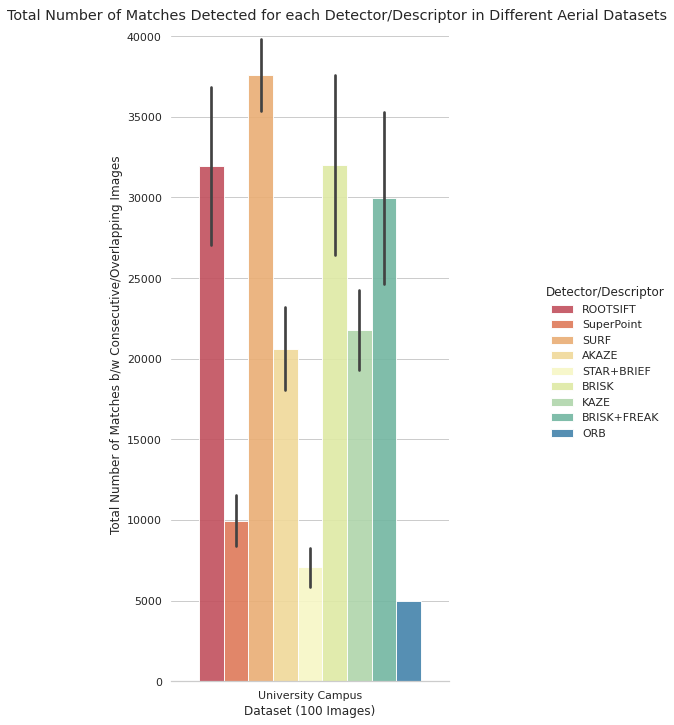

In [ ]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_9, kind="bar",
    x="Dataset", y="Number of Total Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (100 Images)", "Total Number of Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig('drive/MyDrive/Num_Matches_9.png')

Text(0.5, 0.98, 'Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets')

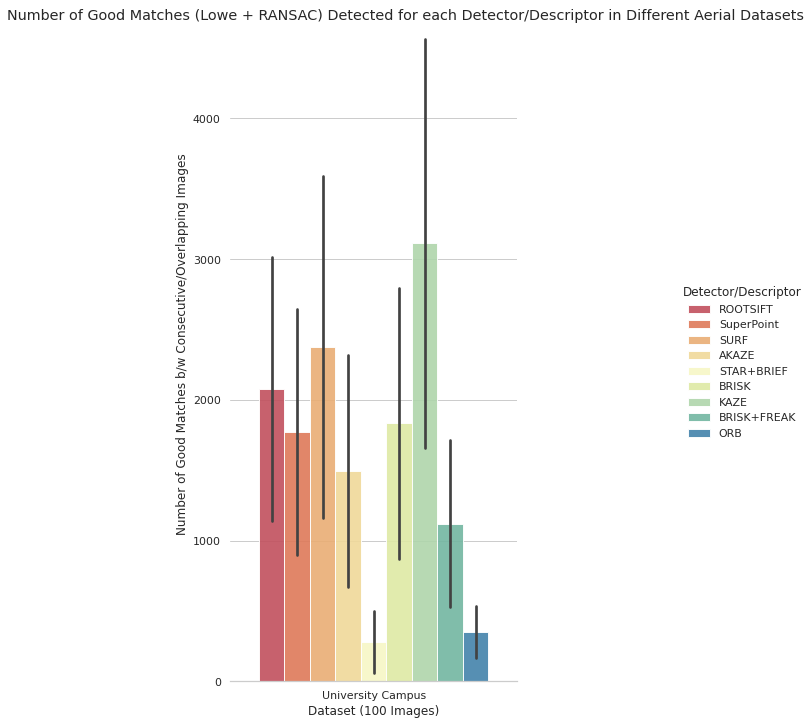

In [ ]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_9, kind="bar",
    x="Dataset", y="Number of Good Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (100 Images)", "Number of Good Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig('drive/MyDrive/Num_Good_Matches_9.png')

In [ ]:
df_match_9['Recall Rate of Matches'] = df_match_9['Number of Good Matches']/df_match_9['Number of Total Matches']

Text(0.5, 0.98, 'Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

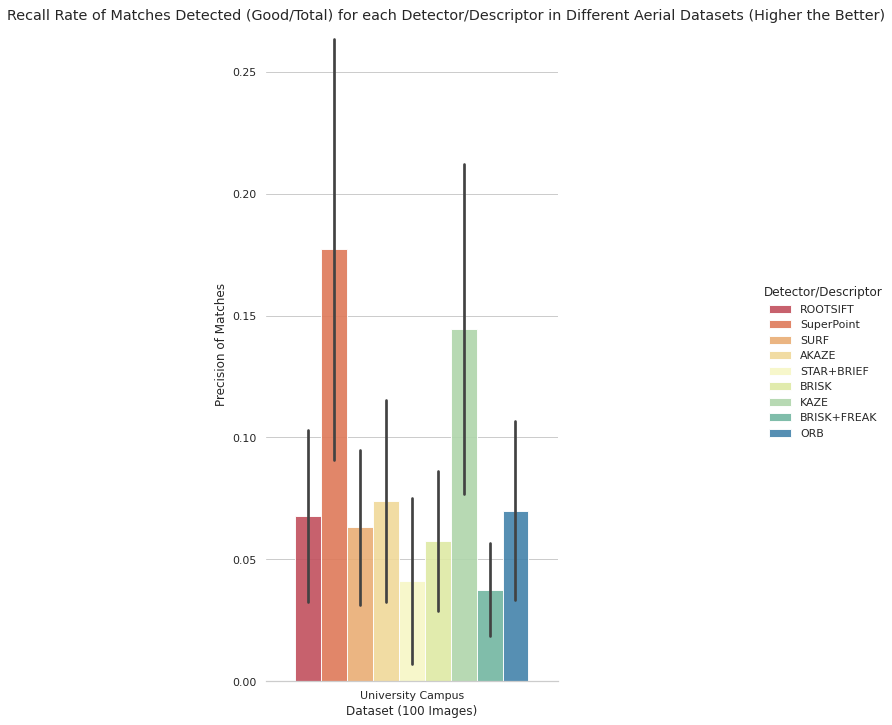

In [ ]:
import seaborn as sns
sns.set_theme(style='whitegrid')


g = sns.catplot(
    data=df_match_9, kind="bar",
    x="Dataset", y="Recall Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (100 Images)", "Precision of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/Recall_Rate_Matches_9.png')

In [ ]:
print(len(num_kps_rootsift[:60] +num_kps_rootsift[61:100] ))

99


In [ ]:
print(df_match_9)

     Unnamed: 0            Dataset  ...  Recall Rate of Matches  Number of KeyPoints
0           0.0  University Campus  ...                0.038135              30330.0
1           1.0  University Campus  ...                0.017436              28871.0
2           2.0  University Campus  ...                0.005320              35330.0
3           3.0  University Campus  ...                0.071066              32332.0
4           4.0  University Campus  ...                0.077596              32125.0
..          ...                ...  ...                     ...                  ...
589         NaN  University Campus  ...                0.051000                  NaN
590         NaN  University Campus  ...                0.041600                  NaN
591         NaN  University Campus  ...                0.065400                  NaN
592         NaN  University Campus  ...                0.129600                  NaN
593         NaN  University Campus  ...                0.100600  

In [ ]:
print(len(df_match3))

297


In [ ]:
print(df_match_9['Number of KeyPoints'].iloc[297:])

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
589   NaN
590   NaN
591   NaN
592   NaN
593   NaN
Name: Number of KeyPoints, Length: 594, dtype: float64


In [ ]:
print(len(num_kps_akaze[:60] +num_kps_akaze[61:100] +num_kps_star[:60] +num_kps_star[61:100]+ num_kps_brisk[:60] +num_kps_brisk[61:100] +num_kps_kaze[:60] +num_kps_kaze[61:100]+ num_kps_freak[:60] +num_kps_freak[61:100] + num_kps_orb[:60] +num_kps_orb[61:100]))

297


In [ ]:
df_match_9['Number of KeyPoints'].iloc[297:] = num_kps_akaze[:60] +num_kps_akaze[61:100] +num_kps_star[:60] +num_kps_star[61:100]+ num_kps_brisk[:60] +num_kps_brisk[61:100] +num_kps_kaze[:60] +num_kps_kaze[61:100]+ num_kps_freak[:60] +num_kps_freak[61:100] + num_kps_orb[:60] +num_kps_orb[61:100]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
df_match_3['Number of KeyPoints'] = num_kps_rootsift[:60] +num_kps_rootsift[61:100] + num_kps_superpoint[:60] +num_kps_superpoint[61:100] + num_kps_surf[:60] +num_kps_surf[61:100] 

In [ ]:
print(df_match_9.columns)

Index(['Unnamed: 0', 'Dataset', 'Number of Total Matches',
       'Number of Good Matches', 'Detector/Descriptor',
       'Precision Rate of Matches', 'Recall Rate of Matches',
       'Number of KeyPoints'],
      dtype='object')


In [ ]:
df_match_9['1 - Precision Rate of Matches'] = (df_match_9['Number of Total Matches'] - df_match_9['Number of Good Matches'])/df_match_9['Number of Total Matches']

Text(0.5, 0.98, '1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

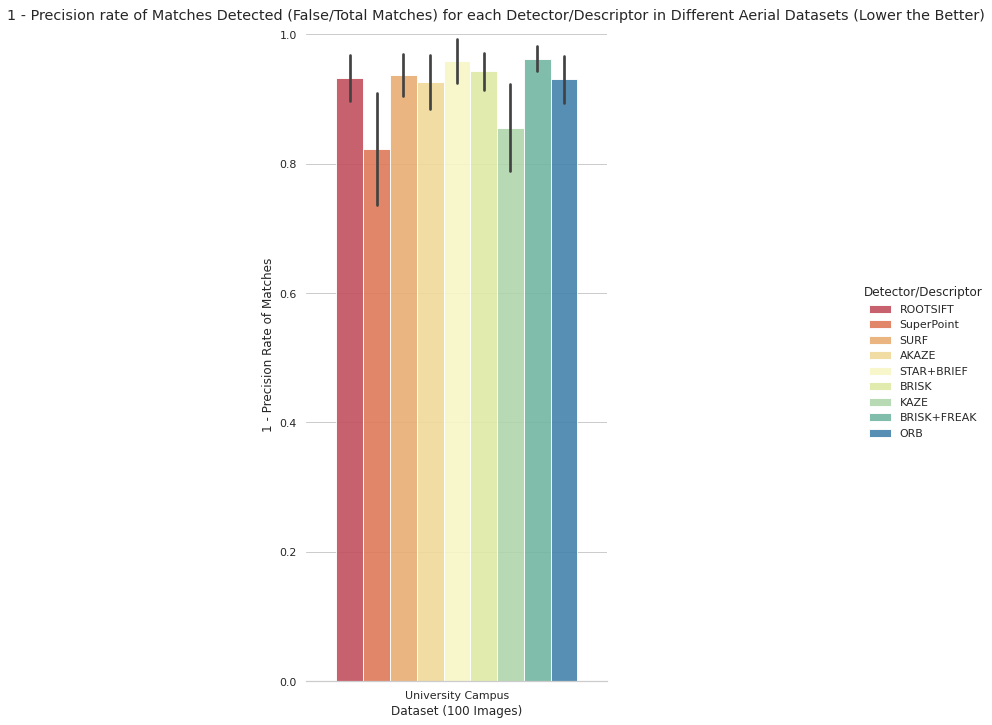

In [ ]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_9, kind="bar",
    x="Dataset", y="1 - Precision Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (100 Images)", "1 - Precision Rate of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/One_minus_Precision_Rate_Matches_9.png')

In [ ]:
print(df_match_9.columns)

Index(['Unnamed: 0', 'Dataset', 'Number of Total Matches',
       'Number of Good Matches', 'Detector/Descriptor',
       'Precision Rate of Matches', 'Recall Rate of Matches',
       'Number of KeyPoints', '1 - Precision Rate of Matches'],
      dtype='object')


In [ ]:
df_match_9['F-Score'] = (2* (1 - df_match_9['1 - Precision Rate of Matches']) * df_match_9['Recall Rate of Matches'])/((1 - df_match_9['1 - Precision Rate of Matches']) + df_match_9['Recall Rate of Matches'])

Text(0.5, 0.98, 'F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

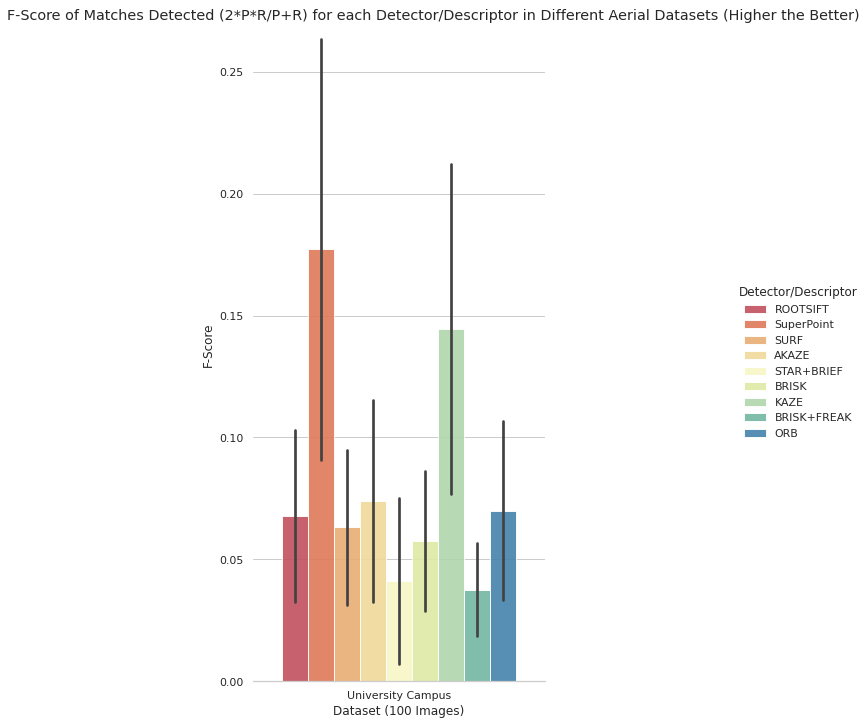

In [ ]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_9, kind="bar",
    x="Dataset", y="F-Score", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (100 Images)", "F-Score")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/F_Score_Rate_Matches_9.png')

In [ ]:
print(df_match_9)

     Unnamed: 0            Dataset  ...  1 - Precision Rate of Matches   F-Score
0           0.0  University Campus  ...                       0.961865  0.038135
1           1.0  University Campus  ...                       0.982564  0.017436
2           2.0  University Campus  ...                       0.994680  0.005320
3           3.0  University Campus  ...                       0.928934  0.071066
4           4.0  University Campus  ...                       0.922404  0.077596
..          ...                ...  ...                            ...       ...
589         NaN  University Campus  ...                       0.949000  0.051000
590         NaN  University Campus  ...                       0.958400  0.041600
591         NaN  University Campus  ...                       0.934600  0.065400
592         NaN  University Campus  ...                       0.870400  0.129600
593         NaN  University Campus  ...                       0.899400  0.100600

[891 rows x 10 columns]


In [ ]:
df_match_9.to_csv('drive/MyDrive/Matches_9.csv')

In [15]:
def warpnImages(images_left, images_right,H_left,H_right):
    #img1-centre,img2-left,img3-right

    h, w = images_left[0].shape[:2]

    pts_left = []
    pts_right = []

    pts_centre = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)

    for j in range(len(H_left)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_left.append(pts)

    for j in range(len(H_right)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_right.append(pts)

    pts_left_transformed=[]
    pts_right_transformed=[]



    for j,pts in enumerate(pts_left):
      if j==0:
        H_trans = H_left[j]
      else:
        H_trans = H_trans@H_left[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_left_transformed.append(pts_)

    for j,pts in enumerate(pts_right):
      if j==0:
        H_trans = H_right[j]
      else:
        H_trans = H_trans@H_right[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_right_transformed.append(pts_)


    print('Step1:Done')


    #pts = np.concatenate((pts1, pts2_), axis=0)

    pts_concat = np.concatenate((pts_centre,np.concatenate(np.array(pts_left_transformed),axis=0),np.concatenate(np.array(pts_right_transformed),axis=0)), axis=0)

    [xmin, ymin] = np.int32(pts_concat.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts_concat.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])  # translate

    print('Step2:Done')


    return xmax,xmin,ymax,ymin,t,h,w,Ht


In [16]:
def final_steps_left(images_left,images_right,H_left,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    warp_imgs_left = []


    for j,H in enumerate(H_left):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_left[j+1], H_trans, (xmax-xmin, ymax-ymin))

      if j==0:
        result[t[1]:h+t[1], t[0]:w+t[0]] = images_left[0]
      
      warp_imgs_left.append(result)

    print('Step31:Done')

    return warp_imgs_left

def final_steps_right(images_left,images_right,H_left,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    warp_imgs_right = []

    for j,H in enumerate(H_right):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_right[j+1], H_trans, (xmax-xmin, ymax-ymin))
      
      warp_imgs_right.append(result)

    print('Step32:Done')

    return warp_imgs_right

def final_steps_union(warp_imgs_left,warp_imgs_right):
    #Union

    warp_images_all = warp_imgs_left + warp_imgs_right

    warp_img_init = warp_images_all[0]



    #warp_final_all=[]

    for j,warp_img in enumerate(warp_images_all):
      if j==len(warp_images_all)-1:
        break
      black_pixels = np.where((warp_img_init[:, :, 0] == 0) & (warp_img_init[:, :, 1] == 0) & (warp_img_init[:, :, 2] == 0))

      warp_img_init[black_pixels] = warp_images_all[j+1][black_pixels]
    
      #warp_final = np.maximum(warp_img_init,warp_images_all[j+1])
      #warp_img_init = warp_final
      #warp_final_all.append(warp_final)

    print('Step4:Done')


    return warp_img_init


In [17]:
def final_steps_left_union(images_left,H_left,xmax,xmin,ymax,ymin,t,h,w,Ht):



    for j,H in enumerate(H_left):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_left[j+1], H_trans, (xmax-xmin, ymax-ymin))
      warp_img_init_curr = result

      if j==0:
        result[t[1]:h+t[1], t[0]:w+t[0]] = images_left[0]
        warp_img_init_prev = result
        continue

      black_pixels = np.where((warp_img_init_prev[:, :, 0] == 0) & (warp_img_init_prev[:, :, 1] == 0) & (warp_img_init_prev[:, :, 2] == 0))

      warp_img_init_prev[black_pixels] = warp_img_init_curr[black_pixels]

    print('Step31:Done')

    return warp_img_init_prev

def final_steps_right_union(warp_img_prev,images_right,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    for j,H in enumerate(H_right):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_right[j+1], H_trans, (xmax-xmin, ymax-ymin))
      warp_img_init_curr = result

      black_pixels = np.where((warp_img_prev[:, :, 0] == 0) & (warp_img_prev[:, :, 1] == 0) & (warp_img_prev[:, :, 2] == 0))

      warp_img_prev[black_pixels] = warp_img_init_curr[black_pixels]
      
    print('Step32:Done')

    return warp_img_prev


In [ ]:
print(left_files_path)

In [ ]:
print(right_files_path)

In [18]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr, images_right_bgr,H_left_brisk,H_right_brisk)

Step1:Done
Step2:Done


In [ ]:
warp_imgs_left = final_steps_left_union(images_left_bgr,H_left_brisk,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
warp_imgs_all_brisk = final_steps_right_union(warp_imgs_left, images_right_bgr,H_right_brisk,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_brisk , cv2.COLOR_BGR2RGB))
ax.set_title('61-Images Mosaic-BRISK')

In [30]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_sift,H_right_sift)

Step1:Done
Step2:Done


In [ ]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_sift,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
warp_imgs_all_sift = final_steps_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_sift,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_sift , cv2.COLOR_BGR2RGB))
ax.set_title('121-Images Mosaic-SIFT')

In [ ]:
fig.savefig('drive/MyDrive/121_sift.png',dpi=300)

Text(0.5, 1.0, '61-Images Mosaic-SIFT')

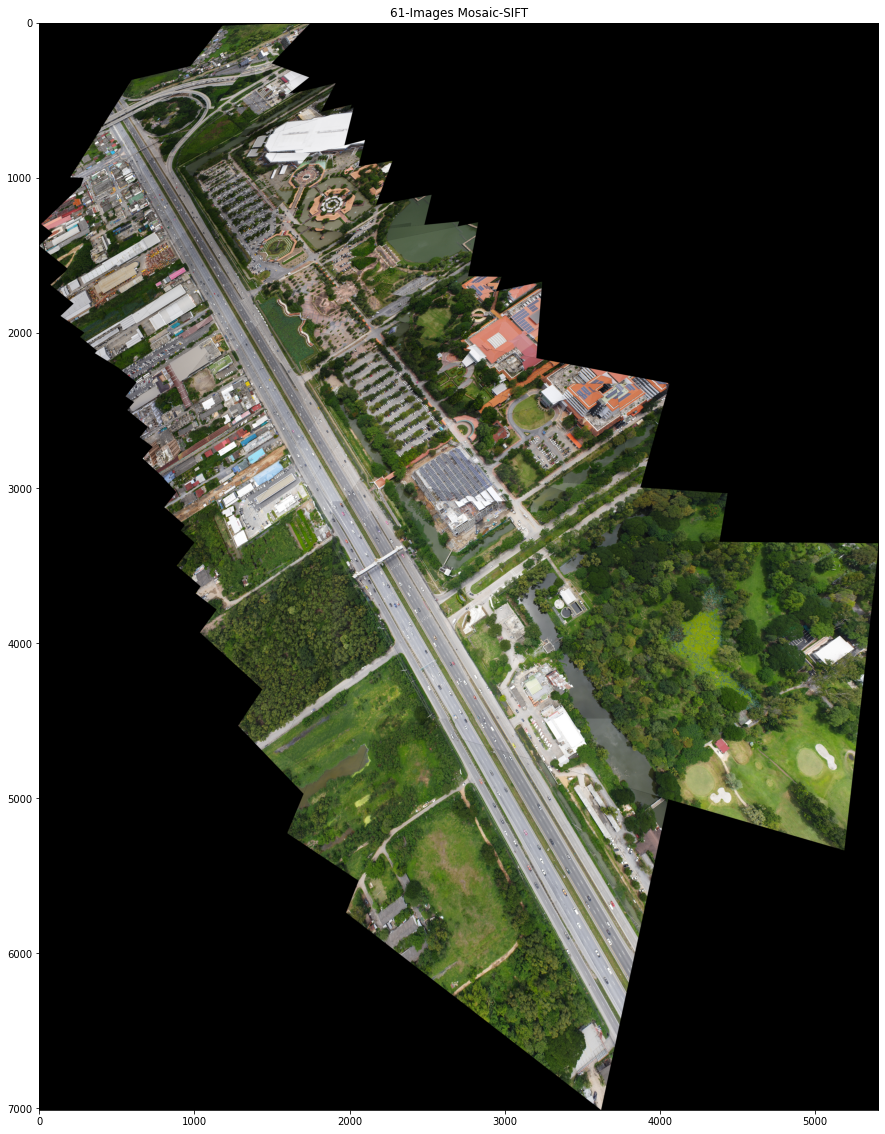

In [ ]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_sift , cv2.COLOR_BGR2RGB))
ax.set_title('61-Images Mosaic-SIFT')

In [ ]:
fig.savefig('drive/MyDrive/61.png',dpi=300)

In [ ]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_rootsift,H_right_rootsift)

Step1:Done
Step2:Done


In [ ]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_rootsift,xmax,xmin,ymax,ymin,t,h,w,Ht)

Step31:Done


In [ ]:
warp_imgs_all_rootsift = final_steps_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_rootsift,xmax,xmin,ymax,ymin,t,h,w,Ht)

Step32:Done


In [ ]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_rootsift , cv2.COLOR_BGR2RGB))
ax.set_title('121-Images Mosaic-RootSIFT')

In [ ]:
fig.savefig('drive/MyDrive/122_rootsift.png',dpi=300)

In [ ]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_orb,H_right_orb)

Step1:Done
Step2:Done
time: 3.51 ms (started: 2021-06-15 15:12:16 +00:00)


In [ ]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_orb,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
warp_imgs_all_orb = final_steps_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_orb,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_kaze,H_right_kaze)

In [ ]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_kaze,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
warp_imgs_all_kaze = final_steps_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_kaze,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_fast,H_right_fast)

Step1:Done
Step2:Done


In [ ]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_fast,xmax,xmin,ymax,ymin,t,h,w,Ht)

Step31:Done


In [ ]:
warp_imgs_all_fast = final_steps_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_fast,xmax,xmin,ymax,ymin,t,h,w,Ht)

Step32:Done


In [ ]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_fast , cv2.COLOR_BGR2RGB))
ax.set_title('61-Images Mosaic-SIFT')

In [ ]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_akaze,H_right_akaze)

In [ ]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_akaze,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
warp_imgs_all_akaze = final_steps_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_akaze,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [49]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr, images_right_bgr,H_left_surf,H_right_surf)

Step1:Done
Step2:Done


In [50]:
warp_imgs_left = final_steps_left_union(images_left_bgr,H_left_surf,xmax,xmin,ymax,ymin,t,h,w,Ht)

Step31:Done


In [51]:
warp_imgs_all_surf = final_steps_right_union(warp_imgs_left,images_right_bgr,H_right_surf,xmax,xmin,ymax,ymin,t,h,w,Ht)

Step32:Done


In [ ]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_surf , cv2.COLOR_BGR2RGB))
ax.set_title('61-Images Mosaic-SIFT')

In [ ]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_brief,H_right_brief)

In [ ]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_brief,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
warp_imgs_all_brief = final_steps_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_brief,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [54]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr, images_right_bgr,H_left_superpoint,H_right_superpoint)

Step1:Done
Step2:Done


In [55]:
warp_imgs_left = final_steps_left_union(images_left_bgr,H_left_superpoint,xmax,xmin,ymax,ymin,t,h,w,Ht)

Step31:Done


In [56]:
warp_imgs_all_superpoint = final_steps_right_union(warp_imgs_left,images_right_bgr,H_right_superpoint,xmax,xmin,ymax,ymin,t,h,w,Ht)

Step32:Done


In [ ]:
plt.figure(figsize = (25,25))

plt.imshow(cv2.cvtColor(warp_imgs_all_superpoint , cv2.COLOR_BGR2RGB))
plt.title('61-Images Mosaic-SIFT')

In [ ]:
plt.savefig('drive/MyDrive/61Images_Mosaic_sift.png',dpi=300)
plt.show()

<Figure size 432x288 with 0 Axes>

time: 254 ms (started: 2021-06-15 13:02:01 +00:00)


In [ ]:
plt.show()

time: 745 µs (started: 2021-06-15 13:02:33 +00:00)
